In [1]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, KFold, cross_val_predict, cross_validate
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from collections import OrderedDict
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
import matplotlib.cm as cm
import time
import scipy.sparse
import seaborn as sns
import lightgbm as lgb
from math import radians, sin, cos, atan2, sqrt
import re
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree
import pickle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from shapely.geometry import Polygon, box
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from tensorflow.keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Concatenate, Input, Dropout, Bidirectional, concatenate
from tensorflow.keras.layers import Reshape, Flatten, MultiHeadAttention, Attention
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.backend import clear_session
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import emoji
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
import os.path
import networkx as nx
from collections import Counter
from pecanpy import node2vec
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest, SelectFromModel, SelectFpr, SelectFdr
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack 
import stellargraph as sg
from io import BytesIO
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from nltk.tokenize import TweetTokenizer
from tensorflow.keras.optimizers.schedules import ExponentialDecay

%matplotlib inline

sns.set_theme()

In [2]:
unTPath = "../../../../../unT/ffunes/"
tmp_save = unTPath + "tmp_saves/"
figuresPath = unTPath + "figures/"

In [3]:
import os
os.environ["METIS_DLL"] = '/usr/local/lib/libmetis.so'

In [4]:
import metis

In [5]:
def extract_oslom(filename):
    """Funcion que extrae las comunidades detectadas por OSLOM a las que pertence un vertice de la red."""
    #clusters = {}
    #hashtag_clusters = {}
    data = []
    
    clusters = []
    
    with open(filename) as f:
        cluster = ""
        for line in f:
            m = re.search("^#module\s([0-9]+).*", line)
            #print line
            if (m is not None):
                cluster = int(m.group(1))
            else:
                l = line.replace('\n', ' ').strip().split(" ")
                l = list(map(int, l))
                
                clusters.append(cluster)
                #clusters[cluster] = l
                for i in l:
                    #if not i in hashtag_clusters:
                    #    hashtag_clusters[i] = set()
                    #hashtag_clusters[i].add(cluster)
                    data.append([i, cluster])
    return pd.DataFrame(data=data, columns=["id", "cluster"]), clusters

In [6]:
def extract_all_oslom(folder):
    basename = 'tp'
    
    all_clusters = {}
    
    train, clusters = extract_oslom(folder + basename)
    
    all_clusters[0] = clusters
    
    train = train.groupby(
        ["id"]
    )['cluster'].apply(list).reset_index(name='clusters')
    
    level = 1
    
    while os.path.isfile(folder + basename + str(level)):
        l_train, l_clusters = extract_oslom(folder + basename + str(level))
        
        l_train = l_train.groupby(
            ["id"]
        )['cluster'].apply(list).reset_index(name='clusters_' + str(level))
        
        train = pd.merge(
            left=train,
            right=l_train,
            how='left',
            validate='1:1'
        )
        
        all_clusters[level] = l_clusters
        
        level += 1
    
    return train, all_clusters

# Metrics

In [7]:
from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_dist(row):
    return haversine_distance(
        row["latitude_real"],
        row["longitude_real"],
        row["latitude_pred"],
        row["longitude_pred"]
    )
    
def determine_latlon(row):
    global leaves
        
    return leaves[row["real_place"]]['y_med_points'],\
        leaves[row["real_place"]]['x_med_points'],\
        leaves[row["predicted_place"]]['y_med_points'],\
        leaves[row["predicted_place"]]['x_med_points']
    

def accuracy_161km(real_places, pred_places):    
    df_prediction = pd.DataFrame({
        'predicted_place': pred_places,
        'real_place': real_places
    }, dtype=int)
            
    df_prediction[[
        "latitude_real",
        "longitude_real",
        "latitude_pred",
        "longitude_pred"
    ]] = df_prediction.apply(determine_latlon, axis=1, result_type="expand")
        
    dif_distance = df_prediction.apply(determine_dist, axis=1)
            
    total_positives = 0
    
    for val in dif_distance:
        if val <= 161:
            total_positives += 1
    
    return total_positives / len(dif_distance)

In [8]:
from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(real_place, predicted_place, places_with_coords):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        #'real_place': real_place,
        'real_lat': real_place[:,0],
        'real_lon': real_place[:,1]
    })#, dtype={'str'})
        
    df_prediction = df_prediction.astype({'predicted_place': str, 'real_lat': np.float64, 'real_lon': np.float64})
        
    df_prediction = pd.merge(
        left=df_prediction,
        right=places_with_coords,
        how='inner',
        left_on='predicted_place',
        right_on='class',
        #validate='m:1'
    ).rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'})
        
    '''df_prediction = pd.merge(
        left=df_prediction,
        right=places_with_coords,
        how='inner',
        left_on='real_place',
        right_on='class',
        #validate='m:1'
    ).rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'})    '''
        
    return df_prediction.apply(determine_distance, axis=1)

def accuracy_161km(real_place, pred_place, places_with_coords):
    dif_distance = get_difference_distance(real_place, pred_place, places_with_coords)
    
    total_positives = 0
    
    for val in dif_distance:
        if val <= 161:
            total_positives += 1

    return total_positives / len(dif_distance)

In [9]:
class Fold:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def unpack(self, val_split=None, random_state=40):
        if val_split:
            sss = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=random_state)
                                
            for train_ix, val_ix in sss.split(self.X_train, self.y_train):
                X_train_ = self.X_train.iloc[train_ix]
                X_val = self.X_train.iloc[val_ix]
                    
                y_train_, y_val = self.y_train[train_ix], self.y_train[val_ix]
                    
                return X_train_, y_train_, X_val, y_val, self.X_test, self.y_test
        
        return self.X_train, self.y_train, self.X_test, self.y_test

In [10]:
class FoldGen:
    def create_folds(self, X, y, outer_cv=5, random_state=40):
        outer_cv_fold = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=random_state)

        folds = []    
        test_idx = np.array([])

        for train_ix, test_ix in outer_cv_fold.split(X, y):
            X_train = X.iloc[train_ix]
            X_test = X.iloc[test_ix]

            y_train, y_test = y[train_ix], y[test_ix]

            folds.append(Fold(X_train, y_train, X_test, y_test))

            test_idx = np.concatenate([test_idx, test_ix])

        return folds, test_idx

In [11]:
class CrossValidator:
    def __init__(self, name, encoder=None):
        self.name = name
        self.encoder = encoder
    
    def classes_order(self):
        if self.encoder:
            return self.encoder.classes_
        
        return self.classes_
            
    def predict_proba(self, clf, X):
        return clf.predict_proba(X)
    
    def cross_predict(
            self, folds, test_idx, outer_cv=5, predict_proba=True, random_state=40, preprocess=None, *args, **kwargs
        ):
        results = None
        
        for fold in folds:
            if self.encoder:
                X_train, y_train, X_test, y_test = fold.unpack()
                
                if self.encoder:
                    self.encoder.fit(y_train)
                
                    y_train = self.encoder.transform(y_train)
                    y_test = self.encoder.transform(y_test)                    
                
                fold = Fold(X_train, y_train, X_test, y_test)
            
            if preprocess is not None:
                clf, X_test = preprocess(fold)
            
            try:
                self.classes_ = clf.classes_
            except:
                pass
            
            # Print best params when searching for best params
            try:
                print("Best params: ", clf.best_params_)
            except:
                pass
                        
            y_pred = self.predict_proba(clf, X_test)
    
            if not predict_proba:
                y_pred = np.array([self.classes_order()[x] for x in np.argmax(y_pred, axis=1)])
            
            if results is None:
                results = y_pred
            else:
                results = np.concatenate((results, y_pred))
            
        preds = results[test_idx.argsort()]

        return preds
    
class KerasCrossValidator(CrossValidator):
    def predict_proba(self, clf, X):
        return clf.predict(X).squeeze()

In [12]:
def kdtree_class_gen(df, min_samples_split=2):
    latitudes = df.latitude.values
    longitudes = df.longitude.values
    indexes = df.index.values
    
    i = 0

    leaves = {str(i): [longitudes, latitudes, indexes]}
    final_leaves = []

    #next_split_axis = 0 # X Axis

    finished = False

    while not finished:
        split_ocurred = False

        for leaf_id, coords in list(leaves.items()):
            dif_lon = np.max(coords[0]) - np.min(coords[0])
            dif_lat = np.max(coords[1]) - np.min(coords[1])
                            
            next_split_axis = 1 if dif_lat > dif_lon else 0
            
            median_val = np.median(coords[next_split_axis])
                
            l_split = [
                i for i, x in enumerate(coords[next_split_axis]) if x <= median_val
            ]

            r_split = [
                i for i, x in enumerate(coords[next_split_axis]) if x > median_val
            ]
            
            if len(l_split) >= min_samples_split and len(r_split) >= min_samples_split:                                
                main_axis_l = [coords[next_split_axis][x] for x in l_split]
                other_axis_l = [coords[(next_split_axis + 1) % 2][x] for x in l_split]
                
                main_axis_r = [coords[next_split_axis][x] for x in r_split]
                other_axis_r = [coords[(next_split_axis + 1) % 2][x] for x in r_split]
                
                if (next_split_axis == 0):
                    leaves[str(i+1)] = [
                        main_axis_l,
                        other_axis_l,
                        [coords[2][x] for x in l_split]
                    ]

                    leaves[str(i+2)] = [
                        main_axis_r,
                        other_axis_r,
                        [coords[2][x] for x in r_split]
                    ]
                else:
                    leaves[str(i+1)] = [
                        other_axis_l,
                        main_axis_l,
                        [coords[2][x] for x in l_split]
                    ]

                    leaves[str(i+2)] = [
                        other_axis_r,
                        main_axis_r,
                        [coords[2][x] for x in r_split]
                    ]
                
                del leaves[leaf_id]
                i += 2
                split_ocurred = True
            else:
                df.loc[coords[2], 'class'] = len(final_leaves)
                
                final_leaves.append({
                    "x_min": np.min(coords[0]),
                    "x_max": np.max(coords[0]),
                    "y_min": np.min(coords[1]),
                    "y_max": np.max(coords[1]),
                    "points": len(coords[0]),
                    'x_med_points': np.median(df.loc[coords[2], ["longitude"]]),
                    'y_med_points': np.median(df.loc[coords[2], ["latitude"]]),
                    'x_cent_points': np.sum(df.loc[coords[2], ["longitude"]].values)/len(coords[2]),
                    'y_cent_points': np.sum(df.loc[coords[2], ["latitude"]].values)/len(coords[2]),
                    'class': int(len(final_leaves))
                })

                del leaves[leaf_id]
        
        if split_ocurred:
            pass
            #next_split_axis = (next_split_axis + 1) % 2
        else:
            finished = True
    
    return final_leaves

In [13]:
def get_all_metrics(y_true, y_pred, classes_order, places_with_coords, users_coords):
    y_true_ = np.array([classes_order[x] for x in np.argmax(y_true, axis=1)])
    y_pred_ = np.array([classes_order[x] for x in np.argmax(y_pred, axis=1)])
    
    acc = accuracy_score(y_true_, y_pred_)
    acc_161 = accuracy_161km(users_coords, y_pred_, places_with_coords)
    bal_acc = balanced_accuracy_score(y_true_, y_pred_)
    
    try:
        roc_auc_ovo = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovo')
    except:
        roc_auc_ovo = "NaN"
        
    diffs_distance = get_difference_distance(users_coords, y_pred_, places_with_coords)
    
    #diffs_distance_ge_zero = [dist for dist in diffs_distance if dist > 0]
        
    return "Accuracy: {}\
        \nAcc@161: {}\
        \nBalanced Acc: {}\
        \nROC AUC Ovo: {}\
        \nMean Dist Err: {}\
        \nMedian Dist Err: {}".format(
        acc, acc_161, bal_acc, roc_auc_ovo, np.mean(diffs_distance), np.median(diffs_distance)
    )

# Mahmud Dataset

In [14]:
!cat ../Mahmud_ICWSM_2012/README.txt

cat: ../Mahmud_ICWSM_2012/README.txt: No such file or directory


In [3]:
mahmud = pd.read_csv("../paper_data/tweets_ids_.csv")

/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [134]:
mahmud.shape

NameError: name 'mahmud' is not defined

In [5]:
mahmud.columns

Index(['coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'id', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_user_id', 'lang', 'place',
       'possibly_sensitive', 'retweet_count', 'retweet_id',
       'retweet_screen_name', 'source', 'text', 'tweet_url', 'user_created_at',
       'user_screen_name', 'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name.1',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'],
      dtype='object')

In [108]:
{"created_at":"Tue Jun 28 19:45:35 +0000 2011",
 "id":85796001729884160,
 "id_str":"85796001729884160",
 "full_text":"@mvanhorn Is that a filter, or is the room *really* that purple? /cc @hutchins @mager",
 "truncated":false,
 "display_text_range":[0,85],
 "entities":{"hashtags":[],"symbols":[],
             "user_mentions":[{"screen_name":"mvanhorn","name":"Matt Van Horn","id":6238012,"id_str":"6238012","indices":[0,9]},{"screen_name":"hutchins","name":"Chris Hutchins","id":8953722,"id_str":"8953722","indices":[69,78]},{"screen_name":"mager","name":"Andrew Mager ♫","id":632023,"id_str":"632023","indices":[79,85]}],"urls":[]}
 ,"source":"<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>","in_reply_to_status_id":85795091842732030,"in_reply_to_status_id_str":"85795091842732032","in_reply_to_user_id":6238012,"in_reply_to_user_id_str":"6238012","in_reply_to_screen_name":"mvanhorn",
 "user":{"id":607,"id_str":"607","name":"Matt Galligan","screen_name":"mg","location":"💻🏡⛰✈️🌎","description":"VP of Design @earnestresearch, 👦🏼 Nash’s dad, 🌽 Midwesterner, 🎸 musician, 🍺 craft beer & coffee lover, 🍔 burger fiend, 🌎 remote worker, 📺 GIF enthusiast","url":"https://t.co/8Mlgh9MvHh","entities":{"url":{"urls":[{"url":"https://t.co/8Mlgh9MvHh","expanded_url":"https://galligan.co/about","display_url":"galligan.co/about","indices":[0,23]}]},"description":{"urls":[]}},"protected":false,"followers_count":25074,"friends_count":948,"listed_count":1441,"created_at":"Thu Jul 13 18:21:58 +0000 2006","favourites_count":14548,"utc_offset":null,"time_zone":null,"geo_enabled":true,"verified":true,"statuses_count":35726,"lang":null,"contributors_enabled":false,"is_translator":false,"is_translation_enabled":false,"profile_background_color":"F0E8DD","profile_background_image_url":"http://abs.twimg.com/images/themes/theme1/bg.png","profile_background_image_url_https":"https://abs.twimg.com/images/themes/theme1/bg.png","profile_background_tile":false,"profile_image_url":"http://pbs.twimg.com/profile_images/897144392712044547/9PWpsOB8_normal.jpg","profile_image_url_https":"https://pbs.twimg.com/profile_images/897144392712044547/9PWpsOB8_normal.jpg","profile_banner_url":"https://pbs.twimg.com/profile_banners/607/1472249744","profile_link_color":"5898AE","profile_sidebar_border_color":"FFFFFF","profile_sidebar_fill_color":"030516","profile_text_color":"A7394D","profile_use_background_image":false,"has_extended_profile":true,"default_profile":false,"default_profile_image":false,"following":false,"follow_request_sent":false,"notifications":false,"translator_type":"regular"},"geo":null,"coordinates":null,"place":{"id":"2b6ff8c22edd9576","url":"https://api.twitter.com/1.1/geo/id/2b6ff8c22edd9576.json","place_type":"neighborhood","name":"SoMa","full_name":"SoMa, San Francisco","country_code":"US","country":"United States","contained_within":[],"bounding_box":{"type":"Polygon","coordinates":[[[-122.42284884,37.76893497],[-122.3964,37.76893497],[-122.3964,37.78752897],[-122.42284884,37.78752897]]]},"attributes":{}},"contributors":null,"is_quote_status":false,"retweet_count":0,"favorite_count":0,"favorited":false,"retweeted":false,"lang":"en"}


NameError: name 'false' is not defined

In [6]:
usecols = [
    "coordinates",
    "hashtags",
    "id",
    "text",
    "source",
    "user_location",
    "user_name",
    "user_screen_name",
    "tweet_url",
    "urls",
    "user_time_zone"
]

mahmud = mahmud.loc[:, usecols]

In [7]:
mahmud.dropna(subset=["coordinates"]).shape

(235005, 11)

In [8]:
mahmud.head()

,coordinates,hashtags,id,text,source,user_location,user_name,user_screen_name,tweet_url,urls,user_time_zone
0,NaN,NaN,85796001729884160,"@mvanhorn Is that a filter, or is the room *re...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",💻🏡⛰✈️🌎,Matt Galligan,mg,https://twitter.com/mg/status/85796001729884160,NaN,NaN
1,NaN,NaN,110475105649438720,@JonCart Beautiful! Thank you.,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Portland, OR",Lane Collins,lane,https://twitter.com/lane/status/11047510564943...,NaN,NaN
2,NaN,picklesforever,108948131726630912,This roughly equates #picklesforever http://t...,"<a href=""http://twitter.com/download/iphone"" r...","Portland, OR",Lane Collins,lane,https://twitter.com/lane/status/10894813172663...,http://yfrog.com/18ptqej,NaN
3,NaN,NaN,109461576297357312,@hilatron @blackbeered lawlz,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Portland, OR",Lane Collins,lane,https://twitter.com/lane/status/10946157629735...,NaN,NaN
4,NaN,NaN,109732858414895104,@pinwheel @taryncowart @zackfranceschi I was i...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Portland, OR",Lane Collins,lane,https://twitter.com/lane/status/10973285841489...,NaN,NaN


In [16]:
def retrieve_mentions(row):
    if row["text"] is None:
        return None
    
    return [x[1:] for x in re.findall(r'@\w+', str(row["text"]))]

In [10]:
mahmud["mentions"] = mahmud.apply(retrieve_mentions, axis=1)

In [11]:
mahmud.head()

,coordinates,hashtags,id,text,source,user_location,user_name,user_screen_name,tweet_url,urls,user_time_zone,mentions
0,NaN,NaN,85796001729884160,"@mvanhorn Is that a filter, or is the room *re...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",💻🏡⛰✈️🌎,Matt Galligan,mg,https://twitter.com/mg/status/85796001729884160,NaN,NaN,"[mvanhorn, hutchins, mager]"
1,NaN,NaN,110475105649438720,@JonCart Beautiful! Thank you.,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Portland, OR",Lane Collins,lane,https://twitter.com/lane/status/11047510564943...,NaN,NaN,[JonCart]
2,NaN,picklesforever,108948131726630912,This roughly equates #picklesforever http://t...,"<a href=""http://twitter.com/download/iphone"" r...","Portland, OR",Lane Collins,lane,https://twitter.com/lane/status/10894813172663...,http://yfrog.com/18ptqej,NaN,[]
3,NaN,NaN,109461576297357312,@hilatron @blackbeered lawlz,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Portland, OR",Lane Collins,lane,https://twitter.com/lane/status/10946157629735...,NaN,NaN,"[hilatron, blackbeered]"
4,NaN,NaN,109732858414895104,@pinwheel @taryncowart @zackfranceschi I was i...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Portland, OR",Lane Collins,lane,https://twitter.com/lane/status/10973285841489...,NaN,NaN,"[pinwheel, taryncowart, zackfranceschi]"


In [12]:
mahmud_mentions = mahmud.loc[:, ["user_screen_name", "mentions"]].groupby(
        ["user_screen_name"]
    ).agg({'mentions': 'sum'}).reset_index()

In [13]:
users_ids = mahmud_mentions["user_screen_name"].unique()
users_ids

array(['007freddybond24', '01101001', '01560', ..., 'zuki_mike_82',
       'zulucal79', 'zztype'], dtype=object)

In [14]:
a = set()
for x in mahmud_mentions["mentions"].values:
    for val in x:
        a.add(str(val))
        
all_users_mentioned = list(a)

In [15]:
print("Users ids: ", len(users_ids), " - All users ids mentions: ", len(all_users_mentioned))

Users ids:  13042  - All users ids mentions:  156957


In [16]:
total_users = np.concatenate([users_ids, all_users_mentioned])

In [17]:
a = OrderedDict.fromkeys(total_users)

In [18]:
total_users = list(a)

In [19]:
print("total users: ", len(total_users))

total users:  167848


In [20]:
mahmud_mentions

,user_screen_name,mentions
0,007freddybond24,"[bucbabe39, bucbabe39, RuthMcmullen1, QBKILLA,..."
1,01101001,[]
2,01560,[]
3,01babylove,"[RuthlessO_o, ChevySitnPretty, PrincessQui23, ..."
4,02540,[]
...,...,...
13037,ztbarr,"[maggie_welsford, hjstaton, Dezeen, nmkjeldsen..."
13038,ztftw,"[iMagineerLeader, kmcwilliams21, asbergman, St..."
13039,zuki_mike_82,"[kelimepie, YonderalonsoU, D_Train35, C_Fn_Mas..."
13040,zulucal79,"[4browngirl, 4Browngirl, zulucal79]"


In [30]:
users_and_tweets_mahmud = pd.read_csv("../Mahmud_ICWSM_2012/topcitiesusersandtweets.csv")
users_and_tweets_mahmud.shape

(19390, 8)

Nos faltan 6k usuarios

In [31]:
users_and_tweets_mahmud.head(2)

,City,State,SW LAT,SW LONG,NE LAT,NE LONG,USER ID,TWEET ID
0,New York,New York,40.4774,-74.2591,40.9176,-73.7003,158433699,85580385068650496
1,New York,New York,40.4774,-74.2591,40.9176,-73.7003,37861099,85580392429649920


Como no tenemos los user id en nuestros datos, tenemos conseguir el user name

In [32]:
users_and_tweets_mahmud = pd.merge(
    left=users_and_tweets_mahmud,
    right=mahmud,
    how='inner',
    left_on="TWEET ID",
    right_on="id",
    validate="1:m"
).loc[:, ["user_screen_name", "City"]]

users_and_tweets_mahmud.shape

(5816, 2)

Esto es un inconveniente, de los 13.000 usuarios que rescatamos de los 19.000, solo pudimos conseguir los tweets que ubican a dichos usuarios de solo 5800 de ellos

In [34]:
mahmud_mentions = pd.merge(
    left=mahmud_mentions,
    right=users_and_tweets_mahmud,
    how='inner',
    on='user_screen_name',
    validate="1:1"
)

mahmud_mentions.head()

,user_screen_name,mentions,City
0,01560,[],Worcester
1,02540,[],Worcester
2,0305_adriana,"[agustinarana, agustinarana, Ventaneando13, se...",San Jose
3,1017leech,"[KiddJamNIGGA, Kodi_Paige, Kodi_Paige, Kodi_Pa...",Columbus
4,101SweetCandy,"[Da20thLetter, Jebreh800man, DeeTheDeeva, Meet...",Madison


In [21]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
    vocabulary=total_users
)

vector_of_mentions = vectorizer.fit_transform(mahmud_mentions["mentions"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_mentions

<13042x167848 sparse matrix of type '<class 'numpy.int64'>'
	with 194081 stored elements in Compressed Sparse Row format>

In [36]:
cx = vector_of_mentions.tocoo()
edges = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)

In [37]:
len(edges)

194081

In [41]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../results/papers/matrix/mentions/edges_mentions_weighted.csv", header=False, index=False)

In [42]:
start = time.time()

!cd ../oslom/OSLOM2 && \
./oslom_dir -f ../../results/papers/matrix/mentions/edges_mentions_weighted.csv -w -r 10 -seed 430430 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -w
setting -r
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/papers/matrix/mentions/edges_mentions_weighted.csv
Weighted: yes
First Level Runs:			10
Higher Level Runs:			50
-cp:			0.5
Random number generator seed:			430430
**************************************

allocating 192420 factorials...
done
rm: cannot remove '../../results/papers/matrix/mentions/edges_mentions_weighted.csv_oslo_files/*': No such file or directory
output files will be written in directory: ../../results/papers/matrix/mentions/edges_mentions_weighted.csv_oslo_files
network:: 167203 nodes and 192420 stubs;	 average degree = 1.15082
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 12926
collection done 


checked 0 modules 0 were found significant.  Modules to check: 11721. Percentage nodes done: 0
checked 100 modules 6 were found significant.  

checked 7000 modules 440 were found significant.  Modules to check: 4721. Percentage nodes done: 0.667679
checked 7100 modules 446 were found significant.  Modules to check: 4621. Percentage nodes done: 0.676112
checked 7200 modules 447 were found significant.  Modules to check: 4521. Percentage nodes done: 0.683522
checked 7300 modules 452 were found significant.  Modules to check: 4421. Percentage nodes done: 0.691262
checked 7400 modules 455 were found significant.  Modules to check: 4321. Percentage nodes done: 0.700029
checked 7500 modules 459 were found significant.  Modules to check: 4221. Percentage nodes done: 0.706363
checked 7600 modules 459 were found significant.  Modules to check: 4121. Percentage nodes done: 0.714126
checked 7700 modules 463 were found significant.  Modules to check: 4021. Percentage nodes done: 0.722206
checked 7800 modules 467 were found significant.  Modules to check: 3921. Percentage nodes done: 0.729748
checked 7900 modules 469 were found significan

checked 7400 unions. Fused: 0
checked 7500 unions. Fused: 0
checked 7600 unions. Fused: 0
checked 7700 unions. Fused: 0
checked 7800 unions. Fused: 0
checked 7900 unions. Fused: 0
checked 8000 unions. Fused: 0
checked 8100 unions. Fused: 0
checked 8200 unions. Fused: 0
checked 8300 unions. Fused: 0
checked 8400 unions. Fused: 0
checked 8500 unions. Fused: 0
checked 8600 unions. Fused: 0
checked 8700 unions. Fused: 0
checked 8800 unions. Fused: 0
checked 8900 unions. Fused: 0
checked 9000 unions. Fused: 0
checked 9100 unions. Fused: 0
checked 9200 unions. Fused: 0
checked 9300 unions. Fused: 0
checked 9400 unions. Fused: 0
checked 9500 unions. Fused: 0
checked 9600 unions. Fused: 0
checked 9700 unions. Fused: 0
checked 9800 unions. Fused: 0
checked 9900 unions. Fused: 0
checked 10000 unions. Fused: 0
checked 10100 unions. Fused: 0
checked 10200 unions. Fused: 0
checked 10300 unions. Fused: 0
checked 10400 unions. Fused: 0
checked 10500 unions. Fused: 0
checked 10600 unions. Fused: 0
che

checked 6300 modules 393 were found significant.  Modules to check: 5411. Percentage nodes done: 0.610378
checked 6400 modules 395 were found significant.  Modules to check: 5311. Percentage nodes done: 0.619403
checked 6500 modules 395 were found significant.  Modules to check: 5211. Percentage nodes done: 0.627471
checked 6600 modules 403 were found significant.  Modules to check: 5111. Percentage nodes done: 0.636394
checked 6700 modules 406 were found significant.  Modules to check: 5011. Percentage nodes done: 0.644976
checked 6800 modules 415 were found significant.  Modules to check: 4911. Percentage nodes done: 0.652967
checked 6900 modules 422 were found significant.  Modules to check: 4811. Percentage nodes done: 0.660796
checked 7000 modules 424 were found significant.  Modules to check: 4711. Percentage nodes done: 0.667889
checked 7100 modules 431 were found significant.  Modules to check: 4611. Percentage nodes done: 0.675879
checked 7200 modules 431 were found significan

checked 5100 unions. Fused: 0
checked 5200 unions. Fused: 0
checked 5300 unions. Fused: 0
checked 5400 unions. Fused: 0
checked 5500 unions. Fused: 0
checked 5600 unions. Fused: 0
checked 5700 unions. Fused: 0
checked 5800 unions. Fused: 0
checked 5900 unions. Fused: 0
checked 6000 unions. Fused: 0
checked 6100 unions. Fused: 0
checked 6200 unions. Fused: 0
checked 6300 unions. Fused: 0
checked 6400 unions. Fused: 0
checked 6500 unions. Fused: 0
checked 6600 unions. Fused: 0
checked 6700 unions. Fused: 0
checked 6800 unions. Fused: 0
checked 6900 unions. Fused: 0
checked 7000 unions. Fused: 0
checked 7100 unions. Fused: 0
checked 7200 unions. Fused: 0
checked 7300 unions. Fused: 0
checked 7400 unions. Fused: 0
checked 7500 unions. Fused: 0
checked 7600 unions. Fused: 0
checked 7700 unions. Fused: 0
checked 7800 unions. Fused: 0
checked 7900 unions. Fused: 0
checked 8000 unions. Fused: 0
checked 8100 unions. Fused: 0
checked 8200 unions. Fused: 0
checked 8300 unions. Fused: 0
checked 84

checked 5600 modules 340 were found significant.  Modules to check: 6107. Percentage nodes done: 0.552257
checked 5700 modules 348 were found significant.  Modules to check: 6007. Percentage nodes done: 0.561156
checked 5800 modules 351 were found significant.  Modules to check: 5907. Percentage nodes done: 0.569876
checked 5900 modules 357 were found significant.  Modules to check: 5807. Percentage nodes done: 0.578776
checked 6000 modules 359 were found significant.  Modules to check: 5707. Percentage nodes done: 0.586682
checked 6100 modules 360 were found significant.  Modules to check: 5607. Percentage nodes done: 0.595294
checked 6200 modules 364 were found significant.  Modules to check: 5507. Percentage nodes done: 0.603165
checked 6300 modules 367 were found significant.  Modules to check: 5407. Percentage nodes done: 0.611789
checked 6400 modules 368 were found significant.  Modules to check: 5307. Percentage nodes done: 0.620414
checked 6500 modules 375 were found significan

checked 2600 unions. Fused: 0
checked 2700 unions. Fused: 0
checked 2800 unions. Fused: 0
checked 2900 unions. Fused: 0
checked 3000 unions. Fused: 0
checked 3100 unions. Fused: 0
checked 3200 unions. Fused: 0
checked 3300 unions. Fused: 0
checked 3400 unions. Fused: 0
checked 3500 unions. Fused: 0
checked 3600 unions. Fused: 0
checked 3700 unions. Fused: 0
checked 3800 unions. Fused: 0
checked 3900 unions. Fused: 0
checked 4000 unions. Fused: 0
checked 4100 unions. Fused: 0
checked 4200 unions. Fused: 0
checked 4300 unions. Fused: 0
checked 4400 unions. Fused: 0
checked 4500 unions. Fused: 0
checked 4600 unions. Fused: 0
checked 4700 unions. Fused: 0
checked 4800 unions. Fused: 0
checked 4900 unions. Fused: 0
checked 5000 unions. Fused: 0
checked 5100 unions. Fused: 0
checked 5200 unions. Fused: 0
checked 5300 unions. Fused: 0
checked 5400 unions. Fused: 0
checked 5500 unions. Fused: 0
checked 5600 unions. Fused: 0
checked 5700 unions. Fused: 0
checked 5800 unions. Fused: 0
checked 59

checked 4900 modules 331 were found significant.  Modules to check: 6814. Percentage nodes done: 0.49114
checked 5000 modules 334 were found significant.  Modules to check: 6714. Percentage nodes done: 0.500105
checked 5100 modules 337 were found significant.  Modules to check: 6614. Percentage nodes done: 0.508627
checked 5200 modules 347 were found significant.  Modules to check: 6514. Percentage nodes done: 0.517246
checked 5300 modules 349 were found significant.  Modules to check: 6414. Percentage nodes done: 0.525218
checked 5400 modules 354 were found significant.  Modules to check: 6314. Percentage nodes done: 0.533465
checked 5500 modules 359 were found significant.  Modules to check: 6214. Percentage nodes done: 0.542
checked 5600 modules 364 were found significant.  Modules to check: 6114. Percentage nodes done: 0.550534
checked 5700 modules 370 were found significant.  Modules to check: 6014. Percentage nodes done: 0.558776
checked 5800 modules 374 were found significant.  

checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
checked 2500 unions. Fused: 0
checked 2600 unions. Fused: 0
checked 2700 unions. Fused: 0
checked 2800 unions. Fused: 0
checked 2900 unions. Fused: 0
checked 3000 unions. Fused: 0
checked 3100 unions. Fused: 0
checked 3200 unions. Fused: 0
checked 3300 unions. Fused: 0
checked 3400 unions

checked 4200 modules 291 were found significant.  Modules to check: 7512. Percentage nodes done: 0.433072
checked 4300 modules 295 were found significant.  Modules to check: 7412. Percentage nodes done: 0.442229
checked 4400 modules 300 were found significant.  Modules to check: 7312. Percentage nodes done: 0.450052
checked 4500 modules 306 were found significant.  Modules to check: 7212. Percentage nodes done: 0.458
checked 4600 modules 316 were found significant.  Modules to check: 7112. Percentage nodes done: 0.466804
checked 4700 modules 316 were found significant.  Modules to check: 7012. Percentage nodes done: 0.476295
checked 4800 modules 323 were found significant.  Modules to check: 6912. Percentage nodes done: 0.484561
checked 4900 modules 328 were found significant.  Modules to check: 6812. Percentage nodes done: 0.494369
checked 5000 modules 332 were found significant.  Modules to check: 6712. Percentage nodes done: 0.503681
checked 5100 modules 334 were found significant. 

iteration: 40 number of modules: 3359
collection done 


checking unions of not significant modules, modules to check: 965
iteration: 0 number of modules: 302
iteration: 20 number of modules: 118
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 262 modules to check, run: 0
***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 12547
collection done 


possible fusions to check: 11363
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fu

checked 3500 modules 251 were found significant.  Modules to check: 8187. Percentage nodes done: 0.36802
checked 3600 modules 254 were found significant.  Modules to check: 8087. Percentage nodes done: 0.376638
checked 3700 modules 256 were found significant.  Modules to check: 7987. Percentage nodes done: 0.385155
checked 3800 modules 264 were found significant.  Modules to check: 7887. Percentage nodes done: 0.394156
checked 3900 modules 268 were found significant.  Modules to check: 7787. Percentage nodes done: 0.402786
checked 4000 modules 274 were found significant.  Modules to check: 7687. Percentage nodes done: 0.412546
checked 4100 modules 281 were found significant.  Modules to check: 7587. Percentage nodes done: 0.422857
checked 4200 modules 285 were found significant.  Modules to check: 7487. Percentage nodes done: 0.431404
checked 4300 modules 291 were found significant.  Modules to check: 7387. Percentage nodes done: 0.440542
checked 4400 modules 293 were found significant

checked 11300 modules 530 were found significant.  Modules to check: 387. Percentage nodes done: 0.97811
checked 11400 modules 530 were found significant.  Modules to check: 287. Percentage nodes done: 0.983385
checked 11500 modules 530 were found significant.  Modules to check: 187. Percentage nodes done: 0.989097
checked 11600 modules 531 were found significant.  Modules to check: 87. Percentage nodes done: 0.995191
significance check done 


checking unions of not significant modules, modules to check: 11155
iteration: 0 number of modules: 4860
iteration: 20 number of modules: 3426
iteration: 40 number of modules: 3392
collection done 


checking unions of not significant modules, modules to check: 1002
iteration: 0 number of modules: 339
iteration: 20 number of modules: 128
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

minimality check: 269 module

checked 3000 modules 225 were found significant.  Modules to check: 8700. Percentage nodes done: 0.322889
checked 3100 modules 232 were found significant.  Modules to check: 8600. Percentage nodes done: 0.33244
checked 3200 modules 238 were found significant.  Modules to check: 8500. Percentage nodes done: 0.342703
checked 3300 modules 243 were found significant.  Modules to check: 8400. Percentage nodes done: 0.351082
checked 3400 modules 247 were found significant.  Modules to check: 8300. Percentage nodes done: 0.360843
checked 3500 modules 258 were found significant.  Modules to check: 8200. Percentage nodes done: 0.370113
checked 3600 modules 262 were found significant.  Modules to check: 8100. Percentage nodes done: 0.378492
checked 3700 modules 267 were found significant.  Modules to check: 8000. Percentage nodes done: 0.386626
checked 3800 modules 274 were found significant.  Modules to check: 7900. Percentage nodes done: 0.39525
checked 3900 modules 280 were found significant.

checked 10800 modules 530 were found significant.  Modules to check: 900. Percentage nodes done: 0.944253
checked 10900 modules 531 were found significant.  Modules to check: 800. Percentage nodes done: 0.950216
checked 11000 modules 531 were found significant.  Modules to check: 700. Percentage nodes done: 0.957291
checked 11100 modules 531 were found significant.  Modules to check: 600. Percentage nodes done: 0.963434
checked 11200 modules 533 were found significant.  Modules to check: 500. Percentage nodes done: 0.970395
checked 11300 modules 534 were found significant.  Modules to check: 400. Percentage nodes done: 0.976783
checked 11400 modules 535 were found significant.  Modules to check: 300. Percentage nodes done: 0.982925
checked 11500 modules 537 were found significant.  Modules to check: 200. Percentage nodes done: 0.987979
checked 11600 modules 537 were found significant.  Modules to check: 100. Percentage nodes done: 0.994504
significance check done 


checking unions of 

checked 2400 modules 173 were found significant.  Modules to check: 9332. Percentage nodes done: 0.260217
checked 2500 modules 183 were found significant.  Modules to check: 9232. Percentage nodes done: 0.269941
checked 2600 modules 193 were found significant.  Modules to check: 9132. Percentage nodes done: 0.279702
checked 2700 modules 194 were found significant.  Modules to check: 9032. Percentage nodes done: 0.288589
checked 2800 modules 199 were found significant.  Modules to check: 8932. Percentage nodes done: 0.29762
checked 2900 modules 211 were found significant.  Modules to check: 8832. Percentage nodes done: 0.309259
checked 3000 modules 216 were found significant.  Modules to check: 8732. Percentage nodes done: 0.319677
checked 3100 modules 227 were found significant.  Modules to check: 8632. Percentage nodes done: 0.330634
checked 3200 modules 231 were found significant.  Modules to check: 8532. Percentage nodes done: 0.339611
checked 3300 modules 234 were found significant

checked 10200 modules 527 were found significant.  Modules to check: 1532. Percentage nodes done: 0.905097
checked 10300 modules 528 were found significant.  Modules to check: 1432. Percentage nodes done: 0.912466
checked 10400 modules 530 were found significant.  Modules to check: 1332. Percentage nodes done: 0.919033
checked 10500 modules 534 were found significant.  Modules to check: 1232. Percentage nodes done: 0.92527
checked 10600 modules 535 were found significant.  Modules to check: 1132. Percentage nodes done: 0.931634
checked 10700 modules 539 were found significant.  Modules to check: 1032. Percentage nodes done: 0.938356
checked 10800 modules 540 were found significant.  Modules to check: 932. Percentage nodes done: 0.944247
checked 10900 modules 541 were found significant.  Modules to check: 832. Percentage nodes done: 0.950695
checked 11000 modules 541 were found significant.  Modules to check: 732. Percentage nodes done: 0.958057
checked 11100 modules 545 were found sign

checked 1800 modules 114 were found significant.  Modules to check: 9932. Percentage nodes done: 0.200182
checked 1900 modules 122 were found significant.  Modules to check: 9832. Percentage nodes done: 0.212263
checked 2000 modules 132 were found significant.  Modules to check: 9732. Percentage nodes done: 0.222992
checked 2100 modules 139 were found significant.  Modules to check: 9632. Percentage nodes done: 0.23356
checked 2200 modules 144 were found significant.  Modules to check: 9532. Percentage nodes done: 0.243124
checked 2300 modules 147 were found significant.  Modules to check: 9432. Percentage nodes done: 0.251712
checked 2400 modules 158 were found significant.  Modules to check: 9332. Percentage nodes done: 0.262023
checked 2500 modules 165 were found significant.  Modules to check: 9232. Percentage nodes done: 0.271275
checked 2600 modules 176 were found significant.  Modules to check: 9132. Percentage nodes done: 0.281879
checked 2700 modules 183 were found significant

checked 9600 modules 490 were found significant.  Modules to check: 2132. Percentage nodes done: 0.86026
checked 9700 modules 491 were found significant.  Modules to check: 2032. Percentage nodes done: 0.866994
checked 9800 modules 494 were found significant.  Modules to check: 1932. Percentage nodes done: 0.874117
checked 9900 modules 495 were found significant.  Modules to check: 1832. Percentage nodes done: 0.880839
checked 10000 modules 500 were found significant.  Modules to check: 1732. Percentage nodes done: 0.889314
checked 10100 modules 502 were found significant.  Modules to check: 1632. Percentage nodes done: 0.896246
checked 10200 modules 503 were found significant.  Modules to check: 1532. Percentage nodes done: 0.903471
checked 10300 modules 504 were found significant.  Modules to check: 1432. Percentage nodes done: 0.910659
checked 10400 modules 508 were found significant.  Modules to check: 1332. Percentage nodes done: 0.917585
checked 10500 modules 509 were found signi

checked 1200 modules 74 were found significant.  Modules to check: 10536. Percentage nodes done: 0.144094
checked 1300 modules 82 were found significant.  Modules to check: 10436. Percentage nodes done: 0.154166
checked 1400 modules 90 were found significant.  Modules to check: 10336. Percentage nodes done: 0.164226
checked 1500 modules 93 were found significant.  Modules to check: 10236. Percentage nodes done: 0.173161
checked 1600 modules 103 were found significant.  Modules to check: 10136. Percentage nodes done: 0.183077
checked 1700 modules 110 were found significant.  Modules to check: 10036. Percentage nodes done: 0.1934
checked 1800 modules 122 were found significant.  Modules to check: 9936. Percentage nodes done: 0.201205
checked 1900 modules 133 were found significant.  Modules to check: 9836. Percentage nodes done: 0.21392
checked 2000 modules 140 were found significant.  Modules to check: 9736. Percentage nodes done: 0.224332
checked 2100 modules 150 were found significant

checked 9000 modules 475 were found significant.  Modules to check: 2736. Percentage nodes done: 0.817892
checked 9100 modules 478 were found significant.  Modules to check: 2636. Percentage nodes done: 0.825368
checked 9200 modules 482 were found significant.  Modules to check: 2536. Percentage nodes done: 0.832306
checked 9300 modules 484 were found significant.  Modules to check: 2436. Percentage nodes done: 0.84032
checked 9400 modules 486 were found significant.  Modules to check: 2336. Percentage nodes done: 0.847317
checked 9500 modules 489 were found significant.  Modules to check: 2236. Percentage nodes done: 0.85444
checked 9600 modules 490 were found significant.  Modules to check: 2136. Percentage nodes done: 0.861593
checked 9700 modules 492 were found significant.  Modules to check: 2036. Percentage nodes done: 0.86828
checked 9800 modules 494 were found significant.  Modules to check: 1936. Percentage nodes done: 0.875241
checked 9900 modules 494 were found significant. 

assigning homeless nodes. Homeless at this point: 23785
assigning homeless nodes. Homeless at this point: 23185
assigning homeless nodes. Homeless at this point: 22942
assigning homeless nodes. Homeless at this point: 22847
assigning homeless nodes. Homeless at this point: 22802
assigning homeless nodes. Homeless at this point: 22780
assigning homeless nodes. Homeless at this point: 22770
assigning homeless nodes. Homeless at this point: 22769
assigning homeless nodes. Homeless at this point: 22761
writing final solution in file ../../results/papers/matrix/mentions/edges_mentions_weighted.csv_oslo_files/tp
******** module_collection ******** 249 modules. writing... 
DONE   ****************************
network:: 23010 nodes and 42775 stubs;	 average degree = 1.85897
STARTING! HIERARCHICAL LEVEL: 1
***************************************************************** RUN: #1
iteration: 0 number of modules: 2753
collection done 


checked 0 modules 0 were found significant.  Modules to check:

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 2703
collection done 


possible fusions to check: 2463
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
c

checked 2400 modules 2 were found significant.  Modules to check: 63. Percentage nodes done: 0.978922
significance check done 


checking unions of not significant modules, modules to check: 2461
iteration: 0 number of modules: 2370
collection done 


checking unions of not significant modules, modules to check: 83
iteration: 0 number of modules: 83
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 2679
collection done 


possible fusions to check: 2464
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
che

checked 1900 modules 2 were found significant.  Modules to check: 560. Percentage nodes done: 0.791134
checked 2000 modules 2 were found significant.  Modules to check: 460. Percentage nodes done: 0.833464
checked 2100 modules 2 were found significant.  Modules to check: 360. Percentage nodes done: 0.872186
checked 2200 modules 2 were found significant.  Modules to check: 260. Percentage nodes done: 0.907345
checked 2300 modules 2 were found significant.  Modules to check: 160. Percentage nodes done: 0.945502
checked 2400 modules 2 were found significant.  Modules to check: 60. Percentage nodes done: 0.979791
significance check done 


checking unions of not significant modules, modules to check: 2458
iteration: 0 number of modules: 2370
collection done 


checking unions of not significant modules, modules to check: 82
iteration: 0 number of modules: 81
collection done 


checking unions of not significant modules done 


***************************************************************

checked 1400 modules 2 were found significant.  Modules to check: 1061. Percentage nodes done: 0.590917
checked 1500 modules 2 were found significant.  Modules to check: 961. Percentage nodes done: 0.63216
checked 1600 modules 2 were found significant.  Modules to check: 861. Percentage nodes done: 0.671969
checked 1700 modules 2 were found significant.  Modules to check: 761. Percentage nodes done: 0.710734
checked 1800 modules 2 were found significant.  Modules to check: 661. Percentage nodes done: 0.749587
checked 1900 modules 2 were found significant.  Modules to check: 561. Percentage nodes done: 0.791699
checked 2000 modules 2 were found significant.  Modules to check: 461. Percentage nodes done: 0.832768
checked 2100 modules 2 were found significant.  Modules to check: 361. Percentage nodes done: 0.871143
checked 2200 modules 2 were found significant.  Modules to check: 261. Percentage nodes done: 0.906867
checked 2300 modules 2 were found significant.  Modules to check: 161. Pe

checked 900 modules 2 were found significant.  Modules to check: 1560. Percentage nodes done: 0.384094
checked 1000 modules 2 were found significant.  Modules to check: 1460. Percentage nodes done: 0.423816
checked 1100 modules 2 were found significant.  Modules to check: 1360. Percentage nodes done: 0.465971
checked 1200 modules 2 were found significant.  Modules to check: 1260. Percentage nodes done: 0.504346
checked 1300 modules 2 were found significant.  Modules to check: 1160. Percentage nodes done: 0.551543
checked 1400 modules 2 were found significant.  Modules to check: 1060. Percentage nodes done: 0.591482
checked 1500 modules 2 were found significant.  Modules to check: 960. Percentage nodes done: 0.632334
checked 1600 modules 2 were found significant.  Modules to check: 860. Percentage nodes done: 0.672273
checked 1700 modules 2 were found significant.  Modules to check: 760. Percentage nodes done: 0.711256
checked 1800 modules 2 were found significant.  Modules to check: 66

checked 400 modules 2 were found significant.  Modules to check: 2060. Percentage nodes done: 0.179922
checked 500 modules 2 were found significant.  Modules to check: 1960. Percentage nodes done: 0.221469
checked 600 modules 2 were found significant.  Modules to check: 1860. Percentage nodes done: 0.259279
checked 700 modules 2 were found significant.  Modules to check: 1760. Percentage nodes done: 0.298827
checked 800 modules 2 were found significant.  Modules to check: 1660. Percentage nodes done: 0.339113
checked 900 modules 2 were found significant.  Modules to check: 1560. Percentage nodes done: 0.383138
checked 1000 modules 2 were found significant.  Modules to check: 1460. Percentage nodes done: 0.423642
checked 1100 modules 2 were found significant.  Modules to check: 1360. Percentage nodes done: 0.465667
checked 1200 modules 2 were found significant.  Modules to check: 1260. Percentage nodes done: 0.503694
checked 1300 modules 2 were found significant.  Modules to check: 1160

DONE   ****************************
***************************************************************** RUN: #14
iteration: 0 number of modules: 2728
collection done 


checked 0 modules 0 were found significant.  Modules to check: 2462. Percentage nodes done: 0
checked 100 modules 2 were found significant.  Modules to check: 2362. Percentage nodes done: 0.0514993
checked 200 modules 2 were found significant.  Modules to check: 2262. Percentage nodes done: 0.0938288
checked 300 modules 2 were found significant.  Modules to check: 2162. Percentage nodes done: 0.133333
checked 400 modules 2 were found significant.  Modules to check: 2062. Percentage nodes done: 0.178835
checked 500 modules 2 were found significant.  Modules to check: 1962. Percentage nodes done: 0.219252
checked 600 modules 2 were found significant.  Modules to check: 1862. Percentage nodes done: 0.256888
checked 700 modules 2 were found significant.  Modules to check: 1762. Percentage nodes done: 0.296436
checked 800 modu

checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #16
iteration: 0 number of modules: 2749
collection done 


checked 0 modules 0 were found significant.  Modules to check: 2464. Percentage nodes done: 0
checked 100 modules 2 were found significant.  Modules to check: 2364. Percentage nodes done: 0.0517166
checked 200 modules 2 were found significant. 

iteration: 0 number of modules: 2701
collection done 


possible fusions to check: 2461
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
****

checking unions of not significant modules, modules to check: 83
iteration: 0 number of modules: 82
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 2731
collection done 


possible fusions to check: 2463
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 union

checked 2100 modules 2 were found significant.  Modules to check: 362. Percentage nodes done: 0.870752
checked 2200 modules 2 were found significant.  Modules to check: 262. Percentage nodes done: 0.906128
checked 2300 modules 2 were found significant.  Modules to check: 162. Percentage nodes done: 0.944502
checked 2400 modules 2 were found significant.  Modules to check: 62. Percentage nodes done: 0.978792
significance check done 


checking unions of not significant modules, modules to check: 2460
iteration: 0 number of modules: 2370
collection done 


checking unions of not significant modules, modules to check: 83
iteration: 0 number of modules: 83
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using co

checked 1600 modules 2 were found significant.  Modules to check: 860. Percentage nodes done: 0.671664
checked 1700 modules 2 were found significant.  Modules to check: 760. Percentage nodes done: 0.710256
checked 1800 modules 2 were found significant.  Modules to check: 660. Percentage nodes done: 0.749109
checked 1900 modules 2 were found significant.  Modules to check: 560. Percentage nodes done: 0.791743
checked 2000 modules 2 were found significant.  Modules to check: 460. Percentage nodes done: 0.832768
checked 2100 modules 2 were found significant.  Modules to check: 360. Percentage nodes done: 0.87136
checked 2200 modules 2 were found significant.  Modules to check: 260. Percentage nodes done: 0.906953
checked 2300 modules 2 were found significant.  Modules to check: 160. Percentage nodes done: 0.945154
checked 2400 modules 2 were found significant.  Modules to check: 60. Percentage nodes done: 0.979748
significance check done 


checking unions of not significant modules, modu

checked 1100 modules 2 were found significant.  Modules to check: 1363. Percentage nodes done: 0.462017
checked 1200 modules 2 were found significant.  Modules to check: 1263. Percentage nodes done: 0.500261
checked 1300 modules 2 were found significant.  Modules to check: 1163. Percentage nodes done: 0.549804
checked 1400 modules 2 were found significant.  Modules to check: 1063. Percentage nodes done: 0.589657
checked 1500 modules 2 were found significant.  Modules to check: 963. Percentage nodes done: 0.631117
checked 1600 modules 2 were found significant.  Modules to check: 863. Percentage nodes done: 0.670882
checked 1700 modules 2 were found significant.  Modules to check: 763. Percentage nodes done: 0.709561
checked 1800 modules 2 were found significant.  Modules to check: 663. Percentage nodes done: 0.747327
checked 1900 modules 2 were found significant.  Modules to check: 563. Percentage nodes done: 0.790048
checked 2000 modules 2 were found significant.  Modules to check: 463

checked 600 modules 2 were found significant.  Modules to check: 1859. Percentage nodes done: 0.257453
checked 700 modules 2 were found significant.  Modules to check: 1759. Percentage nodes done: 0.297436
checked 800 modules 2 were found significant.  Modules to check: 1659. Percentage nodes done: 0.336723
checked 900 modules 2 were found significant.  Modules to check: 1559. Percentage nodes done: 0.382225
checked 1000 modules 2 were found significant.  Modules to check: 1459. Percentage nodes done: 0.422468
checked 1100 modules 2 were found significant.  Modules to check: 1359. Percentage nodes done: 0.464711
checked 1200 modules 2 were found significant.  Modules to check: 1259. Percentage nodes done: 0.502608
checked 1300 modules 2 were found significant.  Modules to check: 1159. Percentage nodes done: 0.55189
checked 1400 modules 2 were found significant.  Modules to check: 1059. Percentage nodes done: 0.591178
checked 1500 modules 2 were found significant.  Modules to check: 959

checked 100 modules 2 were found significant.  Modules to check: 2361. Percentage nodes done: 0.0504563
checked 200 modules 2 were found significant.  Modules to check: 2261. Percentage nodes done: 0.0923946
checked 300 modules 2 were found significant.  Modules to check: 2161. Percentage nodes done: 0.132595
checked 400 modules 2 were found significant.  Modules to check: 2061. Percentage nodes done: 0.178705
checked 500 modules 2 were found significant.  Modules to check: 1961. Percentage nodes done: 0.218383
checked 600 modules 2 were found significant.  Modules to check: 1861. Percentage nodes done: 0.256106
checked 700 modules 2 were found significant.  Modules to check: 1761. Percentage nodes done: 0.295611
checked 800 modules 2 were found significant.  Modules to check: 1661. Percentage nodes done: 0.334767
checked 900 modules 2 were found significant.  Modules to check: 1561. Percentage nodes done: 0.379704
checked 1000 modules 2 were found significant.  Modules to check: 1461.

checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #31
iteration: 0 number of modules: 2720
collection done 


checked 0 modules 0 were found significant.  Modules to check: 2461. Percentage nodes done: 0
checked 100 modules 2 were found significant.  Modules to check: 2361. Percentage nodes done: 0.0514993
checked 200 modules 2 were found significant.  Modules to check: 2261. Percentage nodes done: 0.0927423
checked 300 modules 2 were found significant.  Modules to check: 2161. Percentage nodes done: 0.132638
checked 400 modules 2 were found significant.  Modules to check: 2061. Percentage nodes done: 0.178966
checke

checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
*****************************************************

checking unions of not significant modules, modules to check: 85
iteration: 0 number of modules: 84
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 2711
collection done 


possible fusions to check: 2461
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 union

checked 2100 modules 2 were found significant.  Modules to check: 363. Percentage nodes done: 0.871317
checked 2200 modules 2 were found significant.  Modules to check: 263. Percentage nodes done: 0.906345
checked 2300 modules 2 were found significant.  Modules to check: 163. Percentage nodes done: 0.944807
checked 2400 modules 2 were found significant.  Modules to check: 63. Percentage nodes done: 0.978879
significance check done 


checking unions of not significant modules, modules to check: 2461
iteration: 0 number of modules: 2369
collection done 


checking unions of not significant modules, modules to check: 83
iteration: 0 number of modules: 83
collection done 


checking unions of not significant modules done 


***************************************************************************
COLLECTING SIGNIFICANT MODULES DONE

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using co

checked 1600 modules 2 were found significant.  Modules to check: 861. Percentage nodes done: 0.671925
checked 1700 modules 2 were found significant.  Modules to check: 761. Percentage nodes done: 0.710952
checked 1800 modules 2 were found significant.  Modules to check: 661. Percentage nodes done: 0.750196
checked 1900 modules 2 were found significant.  Modules to check: 561. Percentage nodes done: 0.792786
checked 2000 modules 2 were found significant.  Modules to check: 461. Percentage nodes done: 0.833681
checked 2100 modules 2 were found significant.  Modules to check: 361. Percentage nodes done: 0.871447
checked 2200 modules 2 were found significant.  Modules to check: 261. Percentage nodes done: 0.90691
checked 2300 modules 2 were found significant.  Modules to check: 161. Percentage nodes done: 0.944894
checked 2400 modules 2 were found significant.  Modules to check: 61. Percentage nodes done: 0.979444
significance check done 


checking unions of not significant modules, modu

checked 1100 modules 2 were found significant.  Modules to check: 1364. Percentage nodes done: 0.462668
checked 1200 modules 2 were found significant.  Modules to check: 1264. Percentage nodes done: 0.502086
checked 1300 modules 2 were found significant.  Modules to check: 1164. Percentage nodes done: 0.549674
checked 1400 modules 2 were found significant.  Modules to check: 1064. Percentage nodes done: 0.590004
checked 1500 modules 2 were found significant.  Modules to check: 964. Percentage nodes done: 0.630639
checked 1600 modules 2 were found significant.  Modules to check: 864. Percentage nodes done: 0.670491
checked 1700 modules 2 were found significant.  Modules to check: 764. Percentage nodes done: 0.708953
checked 1800 modules 2 were found significant.  Modules to check: 664. Percentage nodes done: 0.748457
checked 1900 modules 2 were found significant.  Modules to check: 564. Percentage nodes done: 0.790395
checked 2000 modules 2 were found significant.  Modules to check: 464

checked 600 modules 2 were found significant.  Modules to check: 1861. Percentage nodes done: 0.258105
checked 700 modules 2 were found significant.  Modules to check: 1761. Percentage nodes done: 0.297784
checked 800 modules 2 were found significant.  Modules to check: 1661. Percentage nodes done: 0.337288
checked 900 modules 2 were found significant.  Modules to check: 1561. Percentage nodes done: 0.381791
checked 1000 modules 2 were found significant.  Modules to check: 1461. Percentage nodes done: 0.421947
checked 1100 modules 2 were found significant.  Modules to check: 1361. Percentage nodes done: 0.464711
checked 1200 modules 2 were found significant.  Modules to check: 1261. Percentage nodes done: 0.502999
checked 1300 modules 2 were found significant.  Modules to check: 1161. Percentage nodes done: 0.551673
checked 1400 modules 2 were found significant.  Modules to check: 1061. Percentage nodes done: 0.591265
checked 1500 modules 2 were found significant.  Modules to check: 96

checked 100 modules 2 were found significant.  Modules to check: 2363. Percentage nodes done: 0.0518036
checked 200 modules 2 were found significant.  Modules to check: 2263. Percentage nodes done: 0.0942199
checked 300 modules 2 were found significant.  Modules to check: 2163. Percentage nodes done: 0.133333
checked 400 modules 2 were found significant.  Modules to check: 2063. Percentage nodes done: 0.179096
checked 500 modules 2 were found significant.  Modules to check: 1963. Percentage nodes done: 0.22073
checked 600 modules 2 were found significant.  Modules to check: 1863. Percentage nodes done: 0.258322
checked 700 modules 2 were found significant.  Modules to check: 1763. Percentage nodes done: 0.29787
checked 800 modules 2 were found significant.  Modules to check: 1663. Percentage nodes done: 0.338288
checked 900 modules 2 were found significant.  Modules to check: 1563. Percentage nodes done: 0.382964
checked 1000 modules 2 were found significant.  Modules to check: 1463. P

checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #46
iteration: 0 number of modules: 2766
collection done 


checked 0 modules 0 were found significant.  Modules to check: 2461. Percentage nodes done: 0
checked 100 modules 2 were found significant.  Modules to check: 2361. Percentage nodes done: 0.0508475
checked 200 modules 2 were found significant.  Modules to check: 2261. Percentage nodes done: 0.0926554
checked 300 modules 2 were found significant.  Modules to check: 2161. Percentage nodes done: 0.132377
checked 400 modules 2 were found significant.  Modules to check: 2061. Percentage nodes done: 0.17814
checked

checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
checking highly intersecting modules

pairs to check: 0
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 1 modules. writing... 
DONE   ****************************
*****************************************************

***************************************************************************
MINIMALITY CHECK DONE
checking similar modules

check unions of modules using community network

iteration: 0 number of modules: 2699
collection done 


possible fusions to check: 2464
checked 0 unions. Fused: 0
checked 100 unions. Fused: 0
checked 200 unions. Fused: 0
checked 300 unions. Fused: 0
checked 400 unions. Fused: 0
checked 500 unions. Fused: 0
checked 600 unions. Fused: 0
checked 700 unions. Fused: 0
checked 800 unions. Fused: 0
checked 900 unions. Fused: 0
checked 1000 unions. Fused: 0
checked 1100 unions. Fused: 0
checked 1200 unions. Fused: 0
checked 1300 unions. Fused: 0
checked 1400 unions. Fused: 0
checked 1500 unions. Fused: 0
checked 1600 unions. Fused: 0
checked 1700 unions. Fused: 0
checked 1800 unions. Fused: 0
checked 1900 unions. Fused: 0
checked 2000 unions. Fused: 0
checked 2100 unions. Fused: 0
checked 2200 unions. Fused: 0
checked 2300 unions. Fused: 0
checked 2400 unions. Fused: 0
c

In [45]:
print((end - start)/60/60)

5.07510955505901


In [47]:
train, clusters = extract_oslom('../results/papers/matrix/mentions/edges_mentions_weighted.csv_oslo_files/tp')

In [48]:
train

,id,cluster
0,4592,0
1,9452,0
2,13208,0
3,21829,0
4,22921,0
...,...,...
167203,109433,23005
167204,137684,23006
167205,13040,23007
167206,143563,23008


In [53]:
def get_original_user_id(row):
    return total_users[row["id"]]

train["real_user_id"] = train.apply(get_original_user_id, axis=1)

In [79]:
users_train_final = pd.merge(
    left=train,
    right=mahmud_mentions,
    how='inner',
    left_on="real_user_id",
    right_on="user_screen_name",
    validate="m:1"
)

In [80]:
users_train_final.head()

,id,cluster,real_user_id,user_screen_name,mentions,City
0,4592,0,PeterSchorschFL,PeterSchorschFL,"[KirkPepper, brianjburgess, KirkPepper, brianj...",Saint Petersburg
1,9452,0,jen_vt,jen_vt,"[FrancoRipple, FLGovScott, adamsmithtimes, new...",Tampa
2,1359,5,DCornelius_44,DCornelius_44,"[JDbbs79, Cassa_Bear, Cassa_Bear, Cassa_Bear, ...",Glendale
3,2077,5,GPA_Athletics,GPA_Athletics,"[BlondieSoBrazyy, dcclopton, _nataleeee, Jb_do...",Glendale
4,3098,6,K_Gonze,K_Gonze,"[fuckingzu5, Issjackie, fuckingzu5, fuckingzu5...",Riverside


In [81]:
users_train_final = users_train_final.loc[:, ["real_user_id", "cluster", "City"]]

In [82]:
users_train_final = users_train_final.groupby(
        ["real_user_id", "City"]
    )['cluster'].apply(list).reset_index(name='clusters')

In [83]:
users_train_final

,real_user_id,City,clusters
0,0305_adriana,San Jose,[238]
1,1017leech,Columbus,[291]
2,101SweetCandy,Madison,[81]
3,11SaraC,Madison,[306]
4,13sa25,Oxnard,[182]
...,...,...,...
5595,zombiecomin4u,San Diego,[192]
5596,zoswizard,Tampa,[246]
5597,zrmoyers,Austin,[80]
5598,ztbarr,Jersey City,[23001]


In [89]:
cities_to_use = users_train_final.groupby("City").count().sort_values('real_user_id', ascending=True).reset_index()
cities_to_use = cities_to_use.loc[cities_to_use["real_user_id"] >= 7, ["City"]]
cities_to_use.shape

(134, 1)

In [90]:
users_train_final = pd.merge(
    left=cities_to_use,
    right=users_train_final,
    how='inner',
    on='City'
)

users_train_final.shape

(5587, 3)

In [91]:
users_city = users_train_final["City"].values
class_names = sorted(users_train_final['City'].unique())

In [92]:
users_train_final["clusters"] = users_train_final["clusters"].apply(lambda l: list(map(str, l)))

In [93]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=False,
)

vector_of_clusters = vectorizer.fit_transform(users_train_final["clusters"].apply(lambda x: ' '.join(x))).astype('bool').astype('int')
vector_of_clusters

<5587x1211 sparse matrix of type '<class 'numpy.int64'>'
	with 5582 stored elements in Compressed Sparse Row format>

In [94]:
estimators = [
    {
        "name": "LightGBM",
        "estimator": lgb.LGBMClassifier(n_jobs=1, objective="multiclass", random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, -1], 'class_weight': ['balanced']}
    },    
    {
        "name": "SVC",
        "estimator": SVC(kernel="rbf", probability=True, random_state=1500),
        "params_grid": {"C": [1, 10, 100], "gamma": [.01, .1], 'class_weight': ['balanced']}
    },
    {
        "name": "DecisionTree",
        "estimator": DecisionTreeClassifier(random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
    },
    {
        "name": "RandomForest",
        "estimator": RandomForestClassifier(n_jobs=-1, random_state=1500),
        "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
    }
]

In [95]:
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=44540570)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=45405450)

In [96]:
scores = {}
predictions = {}

for estimator in estimators:
    clf = GridSearchCV(
        estimator=estimator["estimator"],
        param_grid=estimator["params_grid"],
        cv=inner_cv,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo'],
        refit='roc_auc_ovo'
    )
    
    nested_score = cross_validate(
        clf,
        X=vector_of_clusters.astype('float'),
        y=users_city,
        cv=outer_cv,
        n_jobs=-1,
        scoring={
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'roc_auc_ovo': 'roc_auc_ovo',
           # 'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
        }
    )
    
    nested_predict = cross_val_predict(
        clf,
        X=vector_of_clusters.astype('float'),
        y=users_city,
        cv=outer_cv,
        n_jobs=-1,
        method='predict'
    )
        
    scores[estimator["name"]] = nested_score
    predictions[estimator["name"]] = nested_predict

In [97]:
scores

{'LightGBM': {'fit_time': array([269.56962347, 271.62751508, 274.24053764, 272.31405616,
         271.90705919]),
  'score_time': array([10.10495472, 12.2074182 , 10.85857749, 10.40600538, 10.47162819]),
  'test_accuracy': array([0.00447227, 0.00626118, 0.00626679, 0.00716204, 0.00447628]),
  'test_balanced_accuracy': array([0.00559701, 0.00875681, 0.00746269, 0.00794243, 0.00621891]),
  'test_roc_auc_ovo': array([0.52865718, 0.51618064, 0.5171967 , 0.52369961, 0.52737993])},
 'SVC': {'fit_time': array([286.74503088, 287.5603354 , 290.43726778, 285.28668523,
         295.26153445]),
  'score_time': array([8.1479001 , 8.29206157, 7.97452235, 9.27672076, 7.82395244]),
  'test_accuracy': array([0.02415027, 0.02415027, 0.01342883, 0.02238138, 0.02685765]),
  'test_balanced_accuracy': array([0.02557432, 0.02476094, 0.01197584, 0.01968876, 0.02573765]),
  'test_roc_auc_ovo': array([0.5226015 , 0.52648643, 0.52415862, 0.52031742, 0.52384439])},
 'DecisionTree': {'fit_time': array([133.9984154

# Twitter NA

# TWITTER NA - Finding mentions and parsing tweets

In [70]:
colnames=["username", "latitude", "longitude", "all_tweets"]
usecols=["username", "latitude", "longitude", "all_tweets"]

dtypes = {
    "username": str,
    "all_tweets": str,
    "latitude": np.longdouble,
    "longitude": np.longdouble,
}

train_na = pd.read_csv("../../location/datasets/na/user_info.train", sep="\t", names=colnames, usecols=usecols, dtype=dtypes)
test_na = pd.read_csv("../../location/datasets/na/user_info.test", sep="\t", names=colnames, usecols=usecols, dtype=dtypes)
val_na = pd.read_csv("../../location/datasets/na/user_info.dev", sep="\t", names=colnames, usecols=usecols, dtype=dtypes)

twitter_na = pd.concat([train_na, val_na, test_na])

In [71]:
twitter_na.shape

(449650, 4)

In [72]:
twitter_na.head()

,username,latitude,longitude,all_tweets
0,DanielPPeterson,43.478622,-84.014946,"I'm at Subway (327 N Main St, Frankenmuth) htt..."
1,530productions,43.164857,-79.055586,"What's up, Tweet us let's chat! ||| Please lik..."
2,sarahset24,35.831288,-83.573236,These horses are wearing diapers.. and clearly...
3,Javeonthaprince,31.299422,-92.486251,@SlimGotDimples damn slim ya twin was on tha m...
4,KushNMyTweet__,33.366996,-86.818111,"If you see ian say nun the first time, why are..."


Tenemos usuarios con username parecidos

In [9]:
twitter_na[twitter_na["username"].str.lower().duplicated(keep=False)].sort_values("username").head(10)

,username,latitude,longitude,all_tweets
227599,1DecAsh,36.779057,-121.669487,@_JuicyJenny I fb'd you my reply was too passi...
370193,1decash,36.698647,-121.652794,Damn that lady has a big ass! ||| @T_ROY01 lol...
7717,2GuddaGoneWild,34.073830,-88.706757,Off work Finna go get the hair cut my ride jus...
22999,2Guddagonewild,34.105965,-88.859779,@townsendboi: Ion like skool 4 shitNIGGA STOP....
21925,4EVERUrsDarlene,40.842541,-73.937218,Funny shit is that the white ppl really be lik...
55442,4everUrsDarlene,40.842834,-73.938408,"@spectacular172 wayy better thnx,give me a hin..."
129939,ABSOLUTELYkerr,34.065910,-118.195702,69? ||| ew. sorry but theres nothing i hate mo...
77215,AErnisse2,43.741806,-87.830482,Fuck why does everything bad happen when somet...
51923,AJ_Rotger,41.571053,-74.030800,@NickSwisher thanks for the DP was cool to be ...
129652,ALEXACUSTODIOnj,39.403629,-74.659271,@Foboman this is a little creepy but I was jus...


In [10]:
def retrieve_mentions(row):
    if row["all_tweets"] is None:
        return None
    
    all_mentions = [x[1:] for x in re.findall(r'@\w+', str(row["all_tweets"]))]
    
    return [x for x in all_mentions if x != row["username"]]

twitter_na["mentions"] = twitter_na.apply(retrieve_mentions, axis=1)

def retrieve_hashtags(row):
    if row["all_tweets"] is None:
        return None
    
    all_hashtags = [x[1:] for x in re.findall(r'#\w+', str(row["all_tweets"]))]
    
    return [x for x in all_hashtags]

twitter_na["mentions"] = twitter_na.apply(retrieve_mentions, axis=1)
twitter_na["hashtags"] = twitter_na.apply(retrieve_hashtags, axis=1)

In [11]:
twitter_na.head()

,username,latitude,longitude,all_tweets,mentions,hashtags
0,DanielPPeterson,43.478622,-84.014946,"I'm at Subway (327 N Main St, Frankenmuth) htt...","[foursquare, foursquare, foursquare, foursquar...","[justsayin, fb, fb, fb, goblue, fb, rockandrol..."
1,530productions,43.164856,-79.055588,"What's up, Tweet us let's chat! ||| Please lik...",[lestackmusic],"[nowplaying, nobodyshero]"
2,sarahset24,35.831287,-83.573235,These horses are wearing diapers.. and clearly...,"[taydillibar13, BrandonKIsaacs, drew_truitt, M...","[yum, ewww, yum, twitterless, ridiculous, smh]"
3,Javeonthaprince,31.299423,-92.486252,@SlimGotDimples damn slim ya twin was on tha m...,"[SlimGotDimples, Chyna_Doll_89, MR_YMCMB, Rec_...","[wetwetfarting, ihate, ItsokayToCheatif, zzzzz..."
4,KushNMyTweet__,33.366997,-86.818108,"If you see ian say nun the first time, why are...",[uHO3S_EnvyMe],[WhenIWasLittle]


In [12]:
replacements = [
    r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})',
    r'@\w+',
    r'#\w+',
    r'[!"$%&()*+,-./:;<=>?[\]^_`{}~#@]',
    r'(?<=[a-z])\'(?=[a-z])'
]

pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def parse_tweets(tweets):
    try:
        tweets = tweets.lower()

        for replacement in replacements:
            tweets = re.sub(replacement, '', tweets) 
        tweets = re.sub(emoji.get_emoji_regexp(), '', tweets)
        tweets = re.sub(r'\r\n?|\n', ' ', tweets)
        tweets = tweets.replace('\'', '')
        tweets = pattern.sub('', tweets)
        tweets = ' '.join(tweets.split())
        
        return tweets
    except:
        print("Exception")
        return tweets
    
def simple_parse(row):
    tweets = row["all_tweets"]
    
    return parse_tweets(tweets)

twitter_na["all_tweets"] = twitter_na.apply(simple_parse, axis=1)

In [13]:
twitter_na["all_tweets"]

0       im subway 327 n main st frankenmuth ||| im ste...
1       whats tweet us lets chat ||| please like us fa...
2       horses wearing diapers clearly theyre full eww...
3       damn slim ya twin tha move cummin tha schultz ...
4       see ian say nun first time still trying ||| le...
                              ...                        
9995    mane ear still hurt ||| bit lol ||| cant tell ...
9996    ||| could possibly want christmas dinner movie...
9997    dont see room jesus ||| cant see ||| adam time...
9998    taking one head ||| first tweet month ||| ahhh...
9999    finally found car dunn loringmerrifield metro ...
Name: all_tweets, Length: 449650, dtype: object

In [15]:
max_unique_mentions = 20

twitter_na_ex = twitter_na.explode(column="mentions").loc[:, ["username", "mentions"]]
count_mentions = twitter_na_ex.drop_duplicates()
count_mentions = count_mentions.groupby("mentions").count().reset_index()
count_mentions = count_mentions[count_mentions["username"] < max_unique_mentions].loc[:, ["mentions"]]

twitter_na_ex = pd.merge(
    left=twitter_na_ex,
    right=count_mentions,
    how='inner',
    validate="m:1"
)

twitter_na_ex = twitter_na_ex.groupby(
    ["username"]
)['mentions'].apply(list).reset_index(name='mentions')

twitter_na_co = pd.merge(
    left=twitter_na.loc[:, ["username", "latitude", "longitude", "all_tweets", "hashtags"]],
    right=twitter_na_ex,
    how='left',
    validate="1:m"
)

twitter_na_co.head()

,username,latitude,longitude,all_tweets,hashtags,mentions
0,DanielPPeterson,43.478622,-84.014946,im subway 327 n main st frankenmuth ||| im ste...,"[justsayin, fb, fb, fb, goblue, fb, rockandrol...","[clgray64, AntBlair4Real, AntBlair4Real, AntBl..."
1,530productions,43.164856,-79.055588,whats tweet us lets chat ||| please like us fa...,"[nowplaying, nobodyshero]",[lestackmusic]
2,sarahset24,35.831287,-83.573235,horses wearing diapers clearly theyre full eww...,"[yum, ewww, yum, twitterless, ridiculous, smh]","[taydillibar13, taydillibar13, taydillibar13, ..."
3,Javeonthaprince,31.299423,-92.486252,damn slim ya twin tha move cummin tha schultz ...,"[wetwetfarting, ihate, ItsokayToCheatif, zzzzz...","[SlimGotDimples, SlimGotDimples, Chyna_Doll_89..."
4,KushNMyTweet__,33.366997,-86.818108,see ian say nun first time still trying ||| le...,[WhenIWasLittle],[uHO3S_EnvyMe]


In [16]:
def try_join(l):
    try:
        return '|||'.join(map(str, l))
    except TypeError:
        return np.nan

twitter_na['mentions'] = [try_join(l) for l in twitter_na['mentions']]
twitter_na_co['mentions'] = [try_join(l) for l in twitter_na_co['mentions']]
twitter_na['hashtags'] = [try_join(l) for l in twitter_na['hashtags']]
twitter_na_co['hashtags'] = [try_join(l) for l in twitter_na_co['hashtags']]

In [17]:
twitter_na.to_csv("../../location/datasets/na/users_parsed.total", index=False)
twitter_na_co.to_csv("../../location/datasets/na/users_parsed_comentions.total", index=False)

# Carga de datos

In [93]:
dtypes = {
    "username": str,
    "all_tweets": str,
    "latitude": np.float32,
    "longitude": np.float32,
    "mentions": str,
    "hashtags": str
}

twitter_na = pd.read_csv("../../location/datasets/na/users_parsed_comentions.total")

In [94]:
twitter_na.shape

(449650, 6)

In [95]:
def string_to_mentions(row):
    try:
        return row["mentions"].split('|||')
    except:
        return row["mentions"]

def string_to_hashtags(row):
    try:
        return row["hashtags"].split('|||')
    except:
        return row["hashtags"]    

In [96]:
twitter_na['mentions'] = twitter_na.apply(string_to_mentions, axis=1)
twitter_na['hashtags'] = twitter_na.apply(string_to_hashtags, axis=1)

In [97]:
twitter_na.loc[twitter_na['mentions'].isnull(), ['mentions']] = twitter_na.loc[twitter_na['mentions'].isnull(),'mentions'].apply(lambda x: [])
twitter_na.loc[twitter_na['hashtags'].isnull(), ['hashtags']] = twitter_na.loc[twitter_na['hashtags'].isnull(),'hashtags'].apply(lambda x: [])

In [19]:
twitter_na

,username,latitude,longitude,all_tweets,hashtags,mentions
0,DanielPPeterson,43.478622,-84.014946,im subway 327 n main st frankenmuth ||| im ste...,"[justsayin, fb, fb, fb, goblue, fb, rockandrol...","[clgray64, AntBlair4Real, AntBlair4Real, AntBl..."
1,530productions,43.164856,-79.055590,whats tweet us lets chat ||| please like us fa...,"[nowplaying, nobodyshero]",[lestackmusic]
2,sarahset24,35.831287,-83.573235,horses wearing diapers clearly theyre full eww...,"[yum, ewww, yum, twitterless, ridiculous, smh]","[taydillibar13, taydillibar13, taydillibar13, ..."
3,Javeonthaprince,31.299423,-92.486250,damn slim ya twin tha move cummin tha schultz ...,"[wetwetfarting, ihate, ItsokayToCheatif, zzzzz...","[SlimGotDimples, SlimGotDimples, Chyna_Doll_89..."
4,KushNMyTweet__,33.366997,-86.818110,see ian say nun first time still trying ||| le...,[WhenIWasLittle],[uHO3S_EnvyMe]
...,...,...,...,...,...,...
449645,Cbookie_225,32.413740,-93.779050,mane ear still hurt ||| bit lol ||| cant tell ...,"[basketball4lyfe, np, Motorolawalkietalkie, wi...","[Hi_imTAYlORR, Hi_imTAYlORR, RichKidAjXXX, The..."
449646,jenii_babyy,29.420090,-98.497410,||| could possibly want christmas dinner movie...,"[headshot, tacos, coleworld, WTF, johnstina, r...","[SweetAssSteph, Zombree2312, Zombree2312, Zomb..."
449647,haleyringo,32.902134,-96.984276,dont see room jesus ||| cant see ||| adam time...,"[fog, isthatamaninthebackground, neverreallygo...","[michaelbleecker, ryan_polly, ryan_polly, ryan..."
449648,bummsayyo,34.084850,-117.383160,taking one head ||| first tweet month ||| ahhh...,[justSaying],"[DjWall_e, DjWall_e, CloserProds, CloserProds,..."


In [20]:
def to_lower(row):
    try:
        return row["hashtags"].lower()
    except:
        return row["hashtags"]

In [21]:
hashtags_used = twitter_na.loc[:, ["username", "hashtags"]]
hashtags_used = hashtags_used.explode("hashtags")
hashtags_used["hashtags"] = hashtags_used.apply(to_lower, axis=1)
hashtags_used = hashtags_used.drop_duplicates()

hashtags_count = hashtags_used.groupby("hashtags").count().reset_index()
hashtags_count = hashtags_count.loc[hashtags_count["username"] > 10, ["hashtags"]]
hashtags_count.shape

(47414, 1)

In [22]:
hashtags_used = pd.merge(
    left=hashtags_used,
    right=hashtags_count,
    how='left',
    left_on='hashtags',
    right_on='hashtags'
)

hashtags_used.shape

(6151442, 2)

In [23]:
hashtags_used = hashtags_used.dropna()

In [24]:
hashtags_used = hashtags_used.groupby(
    ["username"]
)['hashtags'].apply(list).reset_index(name='hashtags')

hashtags_used.shape

(379661, 2)

In [25]:
del twitter_na["hashtags"]

twitter_na = pd.merge(
    left=twitter_na,
    right=hashtags_used,
    how='left',
    left_on='username',
    right_on='username'
)

twitter_na.loc[twitter_na['hashtags'].isnull(), ['hashtags']] = twitter_na.loc[twitter_na['hashtags'].isnull(),'hashtags'].apply(lambda x: [])
twitter_na.shape

(449650, 6)

In [13]:
#twitter_na.dropna(subset=["mentions"], inplace=True)
#twitter_na.reset_index(drop=True, inplace=True)
#twitter_na.shape

Armado matriz de menciones

In [60]:
twitter_na.shape

(449650, 13)

In [98]:
users_ids = twitter_na["username"].unique()

set_users = set(users_ids)

for x in twitter_na["mentions"].to_numpy():
    set_users |= set(x)

mentioned_users = list(set_users.difference(set(users_ids)))

total_users = list(users_ids) + mentioned_users
len(total_users)

4080831

In [99]:
#Verify order

value = True

for i in range(0, len(twitter_na["username"])):
    if total_users[i] != twitter_na["username"][i]:
        value = False

print(value)

True


In [100]:
graph_mentions_dir = nx.DiGraph()

graph_mentions_dir.add_nodes_from(users_ids)

for user_id, users_mentioned in zip(users_ids, twitter_na["mentions"].to_numpy()):
    ocurrences = list(Counter(users_mentioned).items())
            
    graph_mentions_dir.add_weighted_edges_from(list(map(lambda x: (user_id, x[0], x[1]), ocurrences)))
                    
graph_mentions_dir.remove_edges_from(nx.selfloop_edges(graph_mentions_dir))

In [101]:
vector_of_mentions_dir = nx.adjacency_matrix(graph_mentions_dir, nodelist=total_users).astype(np.uint8)
vector_of_mentions_dir

<4080831x4080831 sparse matrix of type '<class 'numpy.uint8'>'
	with 6477659 stored elements in Compressed Sparse Row format>

In [102]:
vector_of_mentions_dir_local = vector_of_mentions_dir[0:len(users_ids), 0:len(users_ids)]
vector_of_mentions_dir_local

<449650x449650 sparse matrix of type '<class 'numpy.uint8'>'
	with 451714 stored elements in Compressed Sparse Row format>

In [103]:
vector_of_mentions_undir_local = vector_of_mentions_dir_local + vector_of_mentions_dir_local.T
vector_of_mentions_undir_local

<449650x449650 sparse matrix of type '<class 'numpy.uint8'>'
	with 748308 stored elements in Compressed Sparse Row format>

In [104]:
vector_of_mentions_dir_bip = vector_of_mentions_dir[:len(users_ids), len(users_ids):]
# Convertimos a bool para que los pesos de las aristas pasen a ser todos 1
vector_of_mentions_dir_bip = vector_of_mentions_dir_bip.astype(bool).astype(np.uint8)
vector_of_mentions_dir_bip

<449650x3631181 sparse matrix of type '<class 'numpy.uint8'>'
	with 6025945 stored elements in Compressed Sparse Row format>

In [105]:
vector_of_comentions_ext = vector_of_mentions_dir_bip.dot(vector_of_mentions_dir_bip.T)
# Eliminamos la diagonal
vector_of_comentions_ext.setdiag(0, k=0)
vector_of_comentions_ext.eliminate_zeros()
vector_of_comentions_ext

/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<449650x449650 sparse matrix of type '<class 'numpy.uint8'>'
	with 11255728 stored elements in Compressed Sparse Row format>

In [106]:
vector_of_col_mentions = vector_of_mentions_undir_local + vector_of_comentions_ext
vector_of_col_mentions

<449650x449650 sparse matrix of type '<class 'numpy.uint8'>'
	with 11688798 stored elements in Compressed Sparse Row format>

In [70]:
cx = vector_of_col_mentions.tocoo()
edges = []
already_passed = {}

for i in range(vector_of_col_mentions.shape[0]):
    already_passed[i] = []

for i,j,v in zip(cx.row, cx.col, cx.data):
    if v <= 0:
        continue
    
    if i in already_passed[j]:
        continue
        
    format_str = str(i) + " " + str(j) + " " + str(v)
    edges.append(format_str)
    
    already_passed[i].append(j)

In [71]:
df = pd.DataFrame({"edges": edges})
df.to_csv("../../results/papers/matrix/mentions/edges_colmentions_twitter_na.csv", header=False, index=False)

# Oslom runs

In [ ]:
start = time.time()

!cd ../../oslom/OSLOM2 && \
./oslom_undir -f ../../results/papers/matrix/mentions/edges_colmentions_twitter_na.csv -w -r 10 -hr 50 -seed 42 -cp 0.5

end = time.time()
print(end - start)

setting -f
setting -w
setting -r
setting -hr
setting -seed
setting -cp
**************************************
Threshold:			0.1
Network file:			../../results/papers/matrix/mentions/edges_comentions_twitter_na.csv
Weighted: yes
First Level Runs:			10
Higher Level Runs:			50
-cp:			0.5
Random number generator seed:			42
**************************************

allocating 12290698 factorials...
done
mkdir: cannot create directory ‘../../results/papers/matrix/mentions/edges_comentions_twitter_na.csv_oslo_files’: File exists
output files will be written in directory: ../../results/papers/matrix/mentions/edges_comentions_twitter_na.csv_oslo_files
network:: 387205 nodes and 1.22907e+07 stubs;	 average degree = 31.7421
STARTING! HIERARCHICAL LEVEL: 0
***************************************************************** RUN: #1
iteration: 0 number of modules: 81333
iteration: 20 number of modules: 15633
iteration: 40 number of modules: 15544
collection done 


checked 0 modules 0 were found significa

checked 6800 modules 6739 were found significant.  Modules to check: 9087. Percentage nodes done: 0.880348
checked 6900 modules 6839 were found significant.  Modules to check: 8987. Percentage nodes done: 0.883111
checked 7000 modules 6939 were found significant.  Modules to check: 8887. Percentage nodes done: 0.88622
checked 7100 modules 7039 were found significant.  Modules to check: 8787. Percentage nodes done: 0.888713
checked 7200 modules 7136 were found significant.  Modules to check: 8687. Percentage nodes done: 0.891329
checked 7300 modules 7235 were found significant.  Modules to check: 8587. Percentage nodes done: 0.894087
checked 7400 modules 7329 were found significant.  Modules to check: 8487. Percentage nodes done: 0.896329
checked 7500 modules 7427 were found significant.  Modules to check: 8387. Percentage nodes done: 0.898914
checked 7600 modules 7524 were found significant.  Modules to check: 8287. Percentage nodes done: 0.901215
checked 7700 modules 7621 were found s

checked 14400 modules 13486 were found significant.  Modules to check: 1487. Percentage nodes done: 0.991219
checked 14500 modules 13536 were found significant.  Modules to check: 1387. Percentage nodes done: 0.991891
checked 14600 modules 13591 were found significant.  Modules to check: 1287. Percentage nodes done: 0.992544
checked 14700 modules 13638 were found significant.  Modules to check: 1187. Percentage nodes done: 0.993203
checked 14800 modules 13686 were found significant.  Modules to check: 1087. Percentage nodes done: 0.993807
checked 14900 modules 13741 were found significant.  Modules to check: 987. Percentage nodes done: 0.994419
checked 15000 modules 13787 were found significant.  Modules to check: 887. Percentage nodes done: 0.995021
checked 15100 modules 13830 were found significant.  Modules to check: 787. Percentage nodes done: 0.995617
checked 15200 modules 13865 were found significant.  Modules to check: 687. Percentage nodes done: 0.996227
checked 15300 modules 1

minimality check: 5 modules to check, run: 1
minimality check: 5 modules to check, run: 1
pairs to check: 1641
minimality check: 8 modules to check, run: 1
minimality check: 10 modules to check, run: 1
pairs to check: 750
minimality check: 15 modules to check, run: 1
pairs to check: 409
pairs to check: 378
pairs to check: 20
***************************************************************************
CHECK UNIONS AND SIMILAR MODULES DONE
******** module_collection ******** 12948 modules. writing... 
DONE   ****************************
***************************************************************** RUN: #2
iteration: 0 number of modules: 81530
iteration: 20 number of modules: 15749
iteration: 40 number of modules: 15524
collection done 


checked 0 modules 0 were found significant.  Modules to check: 15858. Percentage nodes done: 0
checked 100 modules 96 were found significant.  Modules to check: 15758. Percentage nodes done: 0.165798
checked 200 modules 193 were found significant.  Mo

checked 7000 modules 6941 were found significant.  Modules to check: 8858. Percentage nodes done: 0.887266
checked 7100 modules 7039 were found significant.  Modules to check: 8758. Percentage nodes done: 0.889803
checked 7200 modules 7136 were found significant.  Modules to check: 8658. Percentage nodes done: 0.892127
checked 7300 modules 7232 were found significant.  Modules to check: 8558. Percentage nodes done: 0.894637
checked 7400 modules 7329 were found significant.  Modules to check: 8458. Percentage nodes done: 0.896956
checked 7500 modules 7425 were found significant.  Modules to check: 8358. Percentage nodes done: 0.899673
checked 7600 modules 7524 were found significant.  Modules to check: 8258. Percentage nodes done: 0.901809
checked 7700 modules 7624 were found significant.  Modules to check: 8158. Percentage nodes done: 0.904356
checked 7800 modules 7722 were found significant.  Modules to check: 8058. Percentage nodes done: 0.906605
checked 7900 modules 7819 were found 

checked 14600 modules 13579 were found significant.  Modules to check: 1258. Percentage nodes done: 0.992714
checked 14700 modules 13623 were found significant.  Modules to check: 1158. Percentage nodes done: 0.993339
checked 14800 modules 13666 were found significant.  Modules to check: 1058. Percentage nodes done: 0.993946
checked 14900 modules 13722 were found significant.  Modules to check: 958. Percentage nodes done: 0.994579
checked 15000 modules 13764 were found significant.  Modules to check: 858. Percentage nodes done: 0.995168
checked 15100 modules 13809 were found significant.  Modules to check: 758. Percentage nodes done: 0.995783
checked 15200 modules 13844 were found significant.  Modules to check: 658. Percentage nodes done: 0.996364
checked 15300 modules 13875 were found significant.  Modules to check: 558. Percentage nodes done: 0.996937
checked 15400 modules 13912 were found significant.  Modules to check: 458. Percentage nodes done: 0.997526
checked 15500 modules 139

minimality check: 7 modules to check, run: 1
pairs to check: 11179
minimality check: 6 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 6 modules to check, run: 1
minimality check: 11 modules to check, run: 1
minimality check: 6 modules to check, run: 1
minimality check: 18 modules to check, run: 1
minimality check: 5 modules to check, run: 2
minimality check: 11 modules to check, run: 1
minimality check: 6 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 6 modules to check, run: 1
minimality check: 16 modules to check, run: 1
minimality check: 13 modules to check, run: 1
minimality check: 14 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 10 modules to check, run: 1
minimality check: 11 modules to check, run: 1
pairs to check: 4607
mini

checked 5900 modules 5853 were found significant.  Modules to check: 10195. Percentage nodes done: 0.851043
checked 6000 modules 5950 were found significant.  Modules to check: 10095. Percentage nodes done: 0.854119
checked 6100 modules 6050 were found significant.  Modules to check: 9995. Percentage nodes done: 0.856978
checked 6200 modules 6150 were found significant.  Modules to check: 9895. Percentage nodes done: 0.860756
checked 6300 modules 6247 were found significant.  Modules to check: 9795. Percentage nodes done: 0.864431
checked 6400 modules 6346 were found significant.  Modules to check: 9695. Percentage nodes done: 0.867318
checked 6500 modules 6443 were found significant.  Modules to check: 9595. Percentage nodes done: 0.870079
checked 6600 modules 6540 were found significant.  Modules to check: 9495. Percentage nodes done: 0.873018
checked 6700 modules 6637 were found significant.  Modules to check: 9395. Percentage nodes done: 0.875851
checked 6800 modules 6735 were foun

checked 13500 modules 12929 were found significant.  Modules to check: 2595. Percentage nodes done: 0.983172
checked 13600 modules 13005 were found significant.  Modules to check: 2495. Percentage nodes done: 0.983977
checked 13700 modules 13077 were found significant.  Modules to check: 2395. Percentage nodes done: 0.984778
checked 13800 modules 13146 were found significant.  Modules to check: 2295. Percentage nodes done: 0.985571
checked 13900 modules 13224 were found significant.  Modules to check: 2195. Percentage nodes done: 0.986297
checked 14000 modules 13296 were found significant.  Modules to check: 2095. Percentage nodes done: 0.987025
checked 14100 modules 13374 were found significant.  Modules to check: 1995. Percentage nodes done: 0.987766
checked 14200 modules 13444 were found significant.  Modules to check: 1895. Percentage nodes done: 0.988484
checked 14300 modules 13507 were found significant.  Modules to check: 1795. Percentage nodes done: 0.989187
checked 14400 modul

minimality check: 10 modules to check, run: 1
minimality check: 7 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 7 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 6 modules to check, run: 1
minimality check: 8 modules to check, run: 1
minimality check: 7 modules to check, run: 1
minimality check: 12 modules to check, run: 1
minimality check: 8 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 8 modules to check, run: 1
pairs to check: 11851
minimality check: 5 modules to check, run: 1
minimality check: 21 modules to check, run: 1
minimality check: 5 modules to check, run: 1
minimality check: 7 modules to check, run: 1
minimality check: 12 modules to check, run: 1
minimality check: 16 modules 

checked 5300 modules 5261 were found significant.  Modules to check: 10527. Percentage nodes done: 0.832691
checked 5400 modules 5359 were found significant.  Modules to check: 10427. Percentage nodes done: 0.836642
checked 5500 modules 5458 were found significant.  Modules to check: 10327. Percentage nodes done: 0.840374
checked 5600 modules 5556 were found significant.  Modules to check: 10227. Percentage nodes done: 0.844072
checked 5700 modules 5655 were found significant.  Modules to check: 10127. Percentage nodes done: 0.846887
checked 5800 modules 5755 were found significant.  Modules to check: 10027. Percentage nodes done: 0.850921
checked 5900 modules 5853 were found significant.  Modules to check: 9927. Percentage nodes done: 0.85448
checked 6000 modules 5952 were found significant.  Modules to check: 9827. Percentage nodes done: 0.857721
checked 6100 modules 6052 were found significant.  Modules to check: 9727. Percentage nodes done: 0.860552
checked 6200 modules 6152 were f

checked 13000 modules 12492 were found significant.  Modules to check: 2827. Percentage nodes done: 0.981147
checked 13100 modules 12571 were found significant.  Modules to check: 2727. Percentage nodes done: 0.981958
checked 13200 modules 12649 were found significant.  Modules to check: 2627. Percentage nodes done: 0.982867
checked 13300 modules 12721 were found significant.  Modules to check: 2527. Percentage nodes done: 0.983693
checked 13400 modules 12799 were found significant.  Modules to check: 2427. Percentage nodes done: 0.984445
checked 13500 modules 12869 were found significant.  Modules to check: 2327. Percentage nodes done: 0.985282
checked 13600 modules 12934 were found significant.  Modules to check: 2227. Percentage nodes done: 0.986033
checked 13700 modules 13005 were found significant.  Modules to check: 2127. Percentage nodes done: 0.98679
checked 13800 modules 13070 were found significant.  Modules to check: 2027. Percentage nodes done: 0.987541
checked 13900 module

In [17]:
print((end - start)/60/60)

6.46624074459076


In [18]:
!ls ../results/papers/matrix/mentions/edges_mentions_twitter_na.csv_oslo_files

net1  partitions_level_0  short_tp1		  statistics_level_1.dat  tp1
net2  partitions_level_1  short_tp2		  statistics_level_2.dat  tp2
net3  partitions_level_2  short_tp3		  statistics_level_3.dat  tp3
net4  partitions_level_3  statistics_level_0.dat  tp


Guardemos datos temporalmente por consumo excesivo de RAM

In [35]:
with open(tmp_save + 'vector_of_colmentions_twitter_us.pickle', 'wb') as handle:
    pickle.dump(vector_of_col_mentions, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(tmp_save + 'vector_of_local_mentions_twitter_us.pickle', 'wb') as handle:
    pickle.dump(vector_of_mentions_undir_local, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(tmp_save + 'vector_of_comentions_ext_twitter_us.pickle', 'wb') as handle:
    pickle.dump(vector_of_comentions_ext, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(tmp_save + 'total_users_twitter_us.pickle', 'wb') as handle:
    pickle.dump(total_users, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(tmp_save + 'twitter_na.pickle', 'wb') as handle:
    pickle.dump(twitter_na.loc[:, ["username", "latitude", "longitude", "all_tweets", "hashtags"]], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
def apply_tokenizer(row):
    tweets = row["all_tweets"].lower()
    
    tweets = re.sub('|||', ' ', tweets)
    
    return TweetTokenizer(reduce_len=3).tokenize(tweets)

In [ ]:
twitter_na["all_tweets"] = twitter_na.apply(apply_tokenizer, axis=1)

In [17]:
def split_tweets(row):
    return ' '.join(row["all_tweets"])

In [18]:
twitter_na["all_tweets"] = twitter_na.apply(split_tweets, axis=1)

In [66]:
twitter_na = twitter_na.loc[:, ["username", "latitude", "longitude", "all_tweets", "hashtags"]]

In [22]:
with open(tmp_save + 'twitter_na_tweets_tokenized.pickle', 'wb') as handle:
    pickle.dump(twitter_na.loc[:, ["username", "latitude", "longitude", "all_tweets", "hashtags"]], handle, protocol=pickle.HIGHEST_PROTOCOL)

Cargamos todo

In [14]:
with open(tmp_save + 'vector_of_colmentions_twitter_us.pickle', 'rb') as handle:
    vector_of_col_mentions = pickle.load(handle)
    
with open(tmp_save + 'total_users_twitter_us.pickle', 'rb') as handle:
    total_users = pickle.load(handle)
    
with open(tmp_save + 'twitter_na.pickle', 'rb') as handle:
    twitter_na = pickle.load(handle)
#with open(tmp_save + 'twitter_na_tweets_tokenized.pickle', 'rb') as handle:
#    twitter_na = pickle.load(handle)

In [15]:
twitter_na.head()

,username,latitude,longitude,all_tweets,hashtags
0,DanielPPeterson,43.478622,-84.014946,im subway 327 n main st frankenmuth ||| im ste...,"[justsayin, fb, goblue, rockandroll, longlivet..."
1,530productions,43.164856,-79.055590,whats tweet us lets chat ||| please like us fa...,"[nowplaying, nobodyshero]"
2,sarahset24,35.831287,-83.573235,horses wearing diapers clearly theyre full eww...,"[yum, ewww, twitterless, ridiculous, smh]"
3,Javeonthaprince,31.299423,-92.486250,damn slim ya twin tha move cummin tha schultz ...,"[wetwetfarting, ihate, itsokaytocheatif, zzzzz..."
4,KushNMyTweet__,33.366997,-86.818110,see ian say nun first time still trying ||| le...,[wheniwaslittle]


In [16]:
users_ids = twitter_na["username"].unique()

# Class generation

In [17]:
leaves = kdtree_class_gen(twitter_na, 1200)
print("Total classes:", len(leaves))

Total classes: 256


In [18]:
leaves_df = gpd.GeoDataFrame(leaves)

def create_regions(row):
    return box(row["x_min"], row["y_min"], row["x_max"], row["y_max"])

def create_mid_point(row):
    return Point(row["x_med_points"], row["y_med_points"])

leaves_df["region"] = leaves_df.apply(create_regions, axis=1)
leaves_df["mid_point"] = leaves_df.apply(create_mid_point, axis=1)

region_df = gpd.GeoDataFrame(leaves_df, geometry='region')
med_df = gpd.GeoDataFrame(leaves_df, geometry='mid_point')

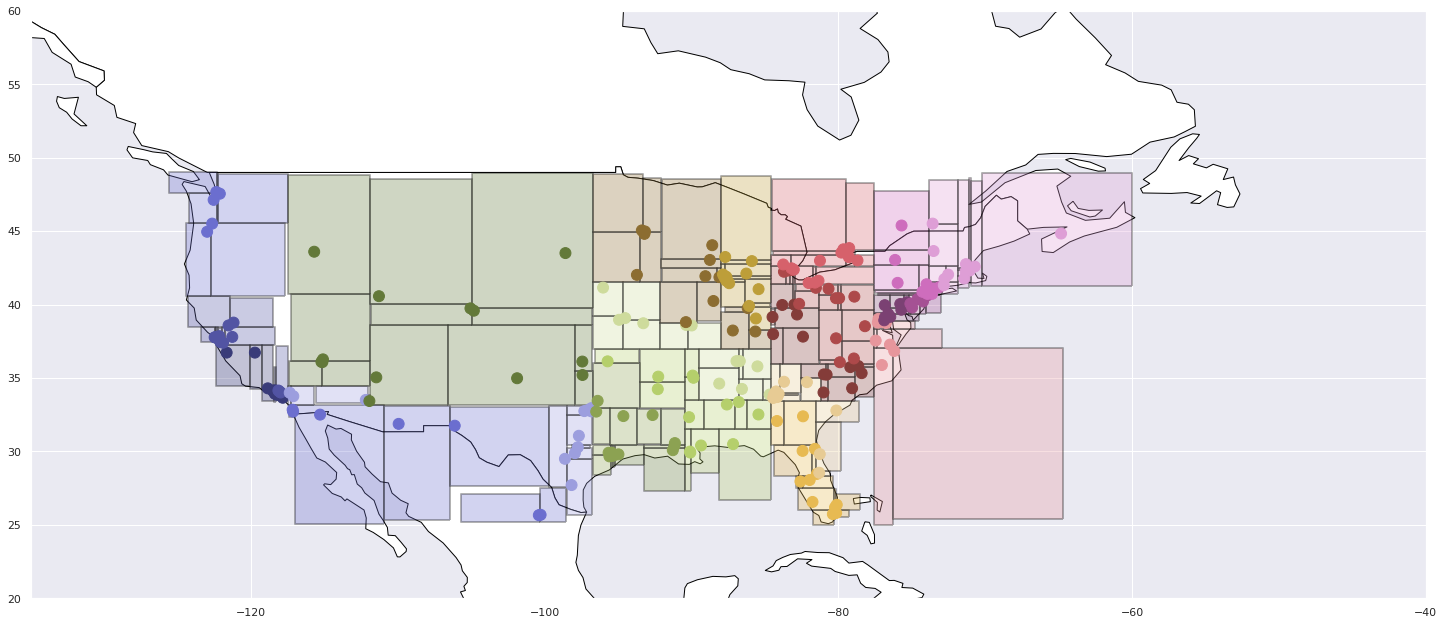

In [19]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

usa = world.query('continent == "North America"')

fig, ax = plt.subplots(figsize=(25, 20))

ax.set_aspect('equal')

usa.plot(ax=ax, color='white', edgecolor='black')

region_df.plot(ax=ax, cmap="tab20b", alpha=0.3, linewidth=2, linestyle='-', edgecolor="black")
med_df.plot(ax=ax, marker='o', markersize=120, cmap="tab20b", alpha=1.0)

ax.set_xlim(-135, -40)
ax.set_ylim(20, 60)

fig.savefig(figuresPath + 'twitter_us/kdtree_twitter_us.pdf', bbox_inches = 'tight')

plt.show();

In [20]:
colnames = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "feature class",
    "feature code",
    "country code",
    "cc2",
    "admin1 code",
    "admin2 code",
    "admin3 code",
    "admin4 code",
    "population",
    "elevation",
    "dem",
    "timezone",
    "modification date"
]

dtypes = {
    "geonameid": np.int32,
    "name": str,
    "asciiname": str,
    "alternatenames": str,
    "latitude": np.float32,
    "longitude": np.float32,
    "feature class": str,
    "feature code": str,
    "country code": str,
    "cc2": str,
    "admin1 code": str,
    "admin2 code": str,
    "admin3 code": str,
    "admin4 code": str,
    "population": np.uint64,
    "elevation": np.float32,
    "dem": str,
    "timezone": str,
    "modification date": str    
}

geonames = pd.read_csv(
    unTPath + 'geonames_us/cities15000.txt',
    sep="\t",
    names=colnames,
    dtype=dtypes
)

geonames = geonames.rename(columns={"asciiname": "city_name"})
geonames = geonames.fillna("")
geonames.shape

(25298, 19)

In [22]:
def admin2_codes_filter(row):
    if len(row["admin2 code"]) > 4 or len(row["admin2 code"]) == 0:
        return ""
    
    return "-" + row["admin2 code"]
    
geonames["admin2 code"] = geonames.apply(admin2_codes_filter, axis=1)
geonames["unified_name"] = geonames["city_name"] + "-" + geonames["admin1 code"] + geonames["admin2 code"] + "-" + geonames["country code"]
geonames["unique_code"] = geonames["admin1 code"] + geonames["admin2 code"] + "-" + geonames["country code"]

In [22]:
geonames.head(2)

,geonameid,name,city_name,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,...,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification date,unified_name,unique_code
0,3040051,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",42.50729,1.53414,P,PPLA,AD,,...,,,,15853,,1033,Europe/Andorra,2008-10-15,les Escaldes-08-AD,08-AD
1,3041563,Andorra la Vella,Andorra la Vella,"ALV,Ando-la-Vyey,Andora,Andora la Vela,Andora ...",42.50779,1.52109,P,PPLC,AD,,...,,,,20430,,1037,Europe/Andorra,2020-03-03,Andorra la Vella-07-AD,07-AD


In [23]:
biggest_cities_list = []

def collapse_cities(row, biggest_cities):
    city_to_check = biggest_cities.loc[biggest_cities["unique_code"] == row["unique_code"]].iloc[0]
    dist = haversine_distance(row["latitude"], row["longitude"], city_to_check["latitude"], city_to_check["longitude"])
    
    if dist <= 50.0:
        biggest_cities.loc[biggest_cities["unique_code"] == row["unique_code"], ["population"]] += row["population"]
        return -1
    
    return row["population"]

while geonames.shape[0] > 0:
    biggest_cities = geonames.loc[:, [
        "unique_code", "population",
    ]].groupby("unique_code").max().reset_index()

    biggest_cities = pd.merge(
        left=geonames.loc[:, ["city_name", "latitude", "longitude", "admin1 code", "admin2 code", "country code", "unified_name", "unique_code", "population"]],
        right=biggest_cities,
        how='inner',
        on=["unique_code", "population"]
    )

    geonames = geonames[~geonames['unified_name'].isin(biggest_cities["unified_name"].to_numpy())]
    
    print("Geonames size after finding biggest C cities per region: ", geonames.shape[0])

    geonames["population"] = geonames.apply(collapse_cities, axis=1, biggest_cities=biggest_cities)   
    geonames = geonames[geonames["population"] > -1]
    
    print("Geonames size after collapsing: ", geonames.shape)
    
    biggest_cities_list.append(biggest_cities)

Geonames size after finding biggest C cities per region:  17805
Geonames size after collapsing:  (6091, 21)
Geonames size after finding biggest C cities per region:  4778
Geonames size after collapsing:  (3538, 21)
Geonames size after finding biggest C cities per region:  2915
Geonames size after collapsing:  (2433, 21)
Geonames size after finding biggest C cities per region:  2096
Geonames size after collapsing:  (1847, 21)
Geonames size after finding biggest C cities per region:  1656
Geonames size after collapsing:  (1494, 21)
Geonames size after finding biggest C cities per region:  1365
Geonames size after collapsing:  (1283, 21)
Geonames size after finding biggest C cities per region:  1191
Geonames size after collapsing:  (1109, 21)
Geonames size after finding biggest C cities per region:  1032
Geonames size after collapsing:  (953, 21)
Geonames size after finding biggest C cities per region:  888
Geonames size after collapsing:  (845, 21)
Geonames size after finding biggest C c

In [24]:
top_cities = biggest_cities_list[0]

for i in range(1, len(biggest_cities_list)):
    top_cities = pd.concat((top_cities, biggest_cities_list[i]))

In [25]:
top_cities = top_cities[top_cities["population"] >= 100000]
top_cities.shape

(4145, 9)

In [41]:
with open(tmp_save + 'top_cities.pickle', 'wb') as handle:
    pickle.dump(top_cities, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open(tmp_save + 'top_cities.pickle', 'rb') as handle:
    top_cities = pickle.load(handle)     

In [22]:
cities_geonames = top_cities.unified_name.to_numpy()

In [23]:
tree = BallTree(top_cities[["latitude", "longitude"]])              

dist, ind = tree.query(twitter_na[["latitude", "longitude"]].to_numpy(), k=1)

twitter_na["closest_city"] = cities_geonames[ind].squeeze()

In [24]:
twitter_na["closest_city"].nunique()

407

In [25]:
twitter_na.shape

(449650, 7)

In [26]:
twitter_na.head()

,username,latitude,longitude,all_tweets,hashtags,class,closest_city
0,DanielPPeterson,43.478622,-84.014946,im subway 327 n main st frankenmuth ||| im ste...,"[justsayin, fb, goblue, rockandroll, longlivet...",186.0,Flint-MI-049-US
1,530productions,43.164856,-79.055590,whats tweet us lets chat ||| please like us fa...,"[nowplaying, nobodyshero]",188.0,Niagara Falls-08-CA
2,sarahset24,35.831287,-83.573235,horses wearing diapers clearly theyre full eww...,"[yum, ewww, twitterless, ridiculous, smh]",151.0,Knoxville-TN-093-US
3,Javeonthaprince,31.299423,-92.486250,damn slim ya twin tha move cummin tha schultz ...,"[wetwetfarting, ihate, itsokaytocheatif, zzzzz...",74.0,Lafayette-LA-055-US
4,KushNMyTweet__,33.366997,-86.818110,see ian say nun first time still trying ||| le...,[wheniwaslittle],86.0,Birmingham-AL-073-US


In [27]:
def tweets_split(row):
    return row["all_tweets"].split('|||')[:100]

#twitter_na_txt = twitter_na.loc[:, ["username", "latitude", "longitude", "all_tweets", "class", "closest_city"]]
#twitter_na_txt["all_tweets"] = twitter_na_txt.apply(tweets_split, axis=1)

In [28]:
#twitter_na_txt = twitter_na_txt.explode("all_tweets")

In [29]:
#twitter_na_txt.head()

In [29]:
#with open(tmp_save + 'twitter_na_explode_txt.pickle', 'wb') as handle:
#    pickle.dump(twitter_na_txt, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
#with open(tmp_save + 'twitter_na_explode_txt.pickle', 'rb') as handle:
#    twitter_na_txt = pickle.load(handle)

In [28]:
#txt_dist = twitter_na_txt["all_tweets"].apply(lambda x: x.split(' ')).str.len()

#print(
#    "Median:", txt_dist.median(),
#    "Mean:", txt_dist.mean(),
#    "Max:", txt_dist.max(),
#    "Min:", txt_dist.min()
#)

Median: 7.0 Mean: 8.006623190337454 Max: 62 Min: 1


# Predictions run

# Co-mentions prediction

In [30]:
train, clusters = extract_all_oslom('../../results/papers/matrix/mentions/edges_comentions_twitter_na.csv_oslo_files/')

In [31]:
train.head(2)

,id,clusters,clusters_1,clusters_2,clusters_3,clusters_4,clusters_5
0,0,"[5802, 11449]",[2239],[186],[25],[0],[0]
1,3,[15133],[2917],[243],[46],[0],[0]


In [32]:
total_clusters_lvls = 6

In [33]:
train["id"].nunique()

387205

In [34]:
#len(all_clusters)

In [35]:
def get_original_user_id(row):
    return total_users[row["id"]]

train["id"] = train.apply(get_original_user_id, axis=1)

In [36]:
twitter_na = pd.merge(
    left=twitter_na,
    right=train,
    how='left',
    left_on='username',
    right_on='id',
    validate="1:m"
)

del twitter_na["id"]

twitter_na.head(2)

,username,latitude,longitude,all_tweets,hashtags,class,closest_city,clusters,clusters_1,clusters_2,clusters_3,clusters_4,clusters_5
0,DanielPPeterson,43.478622,-84.014946,im subway 327 n main st frankenmuth ||| im ste...,"[justsayin, fb, goblue, rockandroll, longlivet...",186.0,Flint-MI-049-US,"[5802, 11449]",[2239],[186],[25],[0],[0]
1,530productions,43.164856,-79.055590,whats tweet us lets chat ||| please like us fa...,"[nowplaying, nobodyshero]",188.0,Niagara Falls-08-CA,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
twitter_na = twitter_na.rename(columns={
    "clusters": "clusters_mentions_0",
    "clusters_1": "clusters_mentions_1",
    "clusters_2": "clusters_mentions_2",
    "clusters_3": "clusters_mentions_3",
    "clusters_4": "clusters_mentions_4",
    "clusters_5": "clusters_mentions_5",
})

In [38]:
for i in range(total_clusters_lvls):
    ind = str(i)
    twitter_na.loc[twitter_na['clusters_mentions_' + ind].isnull(), ['clusters_mentions_' + ind]] = twitter_na.loc[twitter_na['clusters_mentions_' + ind].isnull(),'clusters_mentions_' + ind].apply(lambda x: [])

In [39]:
twitter_na.head(2)

,username,latitude,longitude,all_tweets,hashtags,class,closest_city,clusters_mentions_0,clusters_mentions_1,clusters_mentions_2,clusters_mentions_3,clusters_mentions_4,clusters_mentions_5
0,DanielPPeterson,43.478622,-84.014946,im subway 327 n main st frankenmuth ||| im ste...,"[justsayin, fb, goblue, rockandroll, longlivet...",186.0,Flint-MI-049-US,"[5802, 11449]",[2239],[186],[25],[0],[0]
1,530productions,43.164856,-79.055590,whats tweet us lets chat ||| please like us fa...,"[nowplaying, nobodyshero]",188.0,Niagara Falls-08-CA,[],[],[],[],[],[]


In [40]:
colnames=["username"]
usecols=["username"]

dtypes = {
    "username": str,
}

train_na = pd.read_csv("../../location/datasets/na/user_info.train", sep="\t", names=colnames, usecols=usecols, dtype=dtypes)
test_na = pd.read_csv("../../location/datasets/na/user_info.test", sep="\t", names=colnames, usecols=usecols, dtype=dtypes)
val_na = pd.read_csv("../../location/datasets/na/user_info.dev", sep="\t", names=colnames, usecols=usecols, dtype=dtypes)

train_na = pd.merge(
    left=train_na,
    right=twitter_na,
    how='inner',
    validate="1:1"
)
         
test_na = pd.merge(
    left=test_na,
    right=twitter_na,
    how='inner',
    validate="1:1"
)

val_na = pd.merge(
    left=val_na,
    right=twitter_na,
    how='inner',
    validate="1:1"
)

print(train_na.shape, val_na.shape, test_na.shape)

(429652, 13) (9998, 13) (10000, 13)


In [41]:
count = train_na.groupby("closest_city").count().reset_index().loc[:, ["closest_city", "username"]]
count = count.loc[count["username"] >= 10, ["closest_city"]]

train_na_cities = pd.merge(
    left=train_na,
    right=count,
    how='inner',
    on="closest_city"
)

In [42]:
train_na["index"] = train_na.index

In [43]:
count = train_na.groupby("closest_city").count().reset_index().loc[:, ["closest_city", "username"]]
count = count.loc[count["username"] >= 10, ["closest_city"]]

train_na_cities = pd.merge(
    left=train_na,
    right=count,
    how='inner',
    on="closest_city"
)

In [44]:
train_regions = train_na["class"].astype("int").to_numpy()
val_regions = val_na["class"].astype("int").to_numpy()
test_regions = test_na["class"].astype("int").to_numpy()

encoder = LabelBinarizer()#sparse_output=True)

train_regions_enc = encoder.fit_transform(train_regions)
val_regions_enc = encoder.transform(val_regions)
test_regions_enc = encoder.transform(test_regions)

train_cities = train_na_cities["closest_city"].to_numpy()
val_cities = val_na["closest_city"].to_numpy()
test_cities = test_na["closest_city"].to_numpy()

encoder_city = LabelBinarizer()

train_cities_enc = encoder_city.fit_transform(train_cities)
val_cities_enc = encoder_city.transform(val_cities)
test_cities_enc = encoder_city.transform(test_cities)

In [45]:
train_tweets = train_na["all_tweets"].to_numpy()
train_cities_tweets = train_na_cities["all_tweets"].to_numpy()
val_tweets = val_na["all_tweets"].to_numpy()
test_tweets = test_na["all_tweets"].to_numpy()

In [46]:
places_with_coords = (pd.DataFrame(leaves)
                      .rename(columns={"y_med_points": 'latitude', "x_med_points": "longitude"})
                      .loc[:, ["class", "latitude", "longitude"]])

places_with_coords = places_with_coords.astype({"class": str})

places_with_coords.head(2)

,class,latitude,longitude
0,0,36.731544,-121.656166
1,1,36.731190,-119.733500


In [47]:
cities_with_coords = top_cities.loc[:, ["unified_name", "latitude", "longitude"]].rename(columns={"unified_name": "class"})
cities_with_coords.head(2)

,class,latitude,longitude
3,Ras Al Khaimah City-05-AE,25.78953,55.943199
5,Dubai-03-AE,25.07725,55.309269


In [48]:
total_regions = places_with_coords["class"].nunique()
total_cities = cities_with_coords["class"].nunique()

In [49]:
users_coords = train_na[["latitude", "longitude"]].to_numpy()
users_cities_coords = train_na_cities[["latitude", "longitude"]].to_numpy()
users_coords_test = test_na[["latitude", "longitude"]].to_numpy()

In [50]:
folds_kd, test_kd_idxs = FoldGen().create_folds(train_na, train_regions)
folds_cities, test_cities_idxs = FoldGen().create_folds(train_na_cities, train_cities)

In [46]:
# New saves

#regions = [train_regions, val_regions, test_regions, encoder]

#with open(tmp_save + 'regions_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(regions, handle, protocol=4)
    
#cities = [train_cities, val_cities, test_cities, encoder_city]

#with open(tmp_save + 'cities_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(cities, handle, protocol=4)
    
#with open(tmp_save + 'train_na_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(train_na, handle, protocol=4)
        
#with open(tmp_save + 'train_na_cities_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(train_na_cities, handle, protocol=4)
    
#with open(tmp_save + 'val_na_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(val_na, handle, protocol=4)
    
#with open(tmp_save + 'test_na_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(test_na, handle, protocol=4)

In [47]:
#with open(tmp_save + 'folds_kd_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(folds_kd, handle, protocol=4) 
    
#with open(tmp_save + 'test_kd_idxs_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(test_kd_idxs, handle, protocol=4)  
    
#with open(tmp_save + 'folds_cities_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(folds_cities, handle, protocol=4)
    
#with open(tmp_save + 'test_cities_idxs_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(test_cities_idxs, handle, protocol=4)

#regions = [train_regions, val_regions, test_regions, train_regions_enc, val_regions_enc, test_regions_enc]
#cities = [train_cities, val_cities, test_cities, train_cities_enc, val_cities_enc, test_cities_enc]

#with open(tmp_save + 'train_na_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(train_na, handle, protocol=4)
        
#with open(tmp_save + 'train_na_cities_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(train_na_cities, handle, protocol=4)
    
#with open(tmp_save + 'val_na_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(val_na, handle, protocol=4)
    
#with open(tmp_save + 'test_na_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(test_na, handle, protocol=4)
    
#with open(tmp_save + 'regions_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(regions, handle, protocol=4)
    
#with open(tmp_save + 'cities_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(cities, handle, protocol=4)    

# Entrenamiento TWITTER-US

# Chi2 Términos/Hashtags más significativos (LIW)

In [46]:
class ChiSelector(BaseEstimator, TransformerMixin):
    def __init__(self, vocab, k=50):
        self.vocab = vocab
        self.k = k

    def fit(self, X, y):
        features_sel = np.array([])
        
        #print("Finding chi2 most significative terms")
        
        for target in np.unique(y):
            chi, p = chi2(X, y==target)
            
            idxs = np.argsort(chi)[-self.k:]
            
            features_sel = np.concatenate([features_sel, idxs])
        
        #print("Found chi2 most significative terms")
        
        features_sel = np.unique(features_sel)
        
        self.features_selected = features_sel
        
        return self
        
    def transform(self, X, y=None, **fit_params):
        return X[:, self.features_selected]

In [40]:
vocab = tokenizer.word_index.copy()

for i in vocab.keys():
    vocab[i] -= 1

In [ ]:
i = 0

def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        max_df=0.1,
        min_df=10,
        #vocabulary=vocab
        #ngram_range=(1, 3)
    )
    
    tweets_train = X_train["all_tweets"]
    hashtags_train = X_train["hashtags"].apply(lambda x: ' '.join(x))
    
    content_train = tweets_train + hashtags_train
    
    X_train = vectorizer.fit_transform(content_train.to_numpy()).astype(np.uint8)
    
    print("Using vocabulary of size: ", X_train.shape[1])
    
    tweets_test = X_test["all_tweets"]
    hashtags_test = X_test["hashtags"].apply(lambda x: ' '.join(x))
    
    content_test = tweets_test + hashtags_test
    
    X_test = vectorizer.transform(content_test).astype(np.uint8)
    
    estimator = Pipeline(
        [
            ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=60)),
            #("naive_bayes", LogisticRegression(n_jobs=-1, solver='sag'))
            ("naive_bayes", MultinomialNB(alpha=0.5 if i == 0 else 0.05))
        ]
    )
    
    clf = estimator
    
    '''clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            #"naive_bayes__alpha": [0.05, 0.1, 0.5],
            "naive_bayes__alpha": [0.05, 0.1, 0.5],
            "chi2__k": [50, 100, 150, 300, 400]
            #"chi2__k": [100]
        },
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )'''
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Contenido Chi2 + Naive Bayes",
)

content_preds = cn_cross_val.cross_predict(
    folds_kd,
    test_kd_idxs,
    preprocess=preprocess
)

count_score_kd = get_all_metrics(train_regions_enc, content_preds, cn_cross_val.classes_order(), places_with_coords, users_coords)

content_preds_city = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(train_cities_enc, content_preds_city, cn_cross_val.classes_order(), cities_with_coords, users_cities_coords)

Using vocabulary of size:  2487232


In [58]:
print(count_score_kd)

Accuracy: 0.20207284034520961        
Acc@161: 0.41835019969649856        
Balanced Acc: 0.20208758621513906        
ROC AUC Ovo: 0.7790261486278383        
Mean Dist Err: 775.7295151684808        
Median Dist Err: 303.94527033106993


In [64]:
print(count_score_city)

Accuracy: 0.2616010185295097        
Acc@161: 0.4415939893724732        
Balanced Acc: 0.19200079068974996        
ROC AUC Ovo: 0.7934797385514943        
Mean Dist Err: 797.8659883064074        
Median Dist Err: 278.86803590592933


In [69]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents='ascii',
        lowercase=True,
        analyzer=lambda x: x,
        binary=True
        #max_df=0.1,
        #min_df=10,
        #vocabulary=vocab
        #ngram_range=(1, 3)
    )
        
    X_train = vectorizer.fit_transform(X_train["hashtags"].to_numpy()).astype(np.uint8)
    
    print("Using vocabulary of size: ", X_train.shape[1])
        
    X_test = vectorizer.transform(X_test["hashtags"].to_numpy()).astype(np.uint8)
    
    estimator = Pipeline(
        [
            ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=100)),
            ("naive_bayes", MultinomialNB(alpha=0.05))
        ]
    )
    
    clf = estimator
    
    '''clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            "naive_bayes__alpha": [0.05, 0.1],
            "chi2__k": [50, 100, 150, 300, 400]
        },
        cv=3,
        #n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )'''
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Contenido Chi2 + Naive Bayes",
)

hashtag_preds = cn_cross_val.cross_predict(
    folds_kd,
    test_kd_idxs,
    preprocess=preprocess
)

count_score_kd = get_all_metrics(train_regions_enc, hashtag_preds, cn_cross_val.classes_order(), places_with_coords, users_coords)

hashtag_city_preds = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(train_cities_enc, hashtag_city_preds, cn_cross_val.classes_order(), cities_with_coords, users_cities_coords)

Using vocabulary of size:  1175445
Using vocabulary of size:  1172333
Using vocabulary of size:  1177745
Using vocabulary of size:  1171066
Using vocabulary of size:  1171663
Using vocabulary of size:  1170430
Using vocabulary of size:  1172026
Using vocabulary of size:  1179861
Using vocabulary of size:  1172867
Using vocabulary of size:  1172804


In [70]:
print(count_score_kd)

Accuracy: 0.1025046608897237        
Acc@161: 0.19248485356310763        
Balanced Acc: 0.04331205656768197        
ROC AUC Ovo: 0.6539821249006317        
Mean Dist Err: 1916.7212807788549        
Median Dist Err: 1977.58671681972


In [66]:
#with open(tmp_save + 'content_preds_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(content_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [68]:
#with open(tmp_save + 'content_preds_cities_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(content_preds_city, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [71]:
#with open(tmp_save + 'hashtag_preds_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(hashtag_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [72]:
#with open(tmp_save + 'hashtag_preds_city_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(hashtag_city_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [49]:
with open(tmp_save + 'content_preds_twitter_us.pickle', 'rb') as handle:
    content_preds = pickle.load(handle)  

In [50]:
with open(tmp_save + 'content_preds_cities_twitter_us.pickle', 'rb') as handle:
    content_preds_city = pickle.load(handle)  

In [49]:
with open(tmp_save + 'hashtag_preds_twitter_us.pickle', 'rb') as handle:
    hashtag_preds = pickle.load(handle)

In [50]:
with open(tmp_save + 'hashtag_preds_city_twitter_us.pickle', 'rb') as handle:
    hashtag_city_preds = pickle.load(handle)

Chi2 fit sobre todo el conjunto de entrenamiento

In [73]:
vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents='ascii',
    lowercase=True,
    max_df=0.1,
    min_df=10,
    #ngram_range=(1, 3)
)

tweets_train = train_na["all_tweets"]
hashtags_train = train_na["hashtags"].apply(lambda x: ' '.join(x))
    
content_train = tweets_train + hashtags_train

X_train = vectorizer.fit_transform(content_train.to_numpy()).astype(np.uint8)

clf = Pipeline(
    [
        ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=60)),
        ("naive_bayes", MultinomialNB(alpha=0.5))
    ]
)
    
clf.fit(X_train, train_regions)

vectorizer_city = CountVectorizer(
    #strip_accents='unicode',
    strip_accents='ascii',
    lowercase=True,
    max_df=0.1,
    min_df=10,
    #ngram_range=(1, 3)
)

tweets_train = train_na_cities["all_tweets"]
hashtags_train = train_na_cities["hashtags"].apply(lambda x: ' '.join(x))
    
content_train = tweets_train + hashtags_train

X_train = vectorizer_city.fit_transform(content_train.to_numpy()).astype(np.uint8)

clf_city = Pipeline(
    [
        ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=60)),
        ("naive_bayes", MultinomialNB(alpha=0.05))
    ]
)

clf_city.fit(X_train, train_cities)

Pipeline(steps=[('chi2',
                 ChiSelector(k=60,
                             vocab=array(['00', '000', '000000', ..., 'zzzzzzzzzzzzzz', 'zzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzz'], dtype='<U80'))),
                ('naive_bayes', MultinomialNB(alpha=0.05))])

In [74]:
tweets_test = test_na["all_tweets"]
hashtags_test = test_na["hashtags"].apply(lambda x: ' '.join(x))
    
content_test = tweets_test + hashtags_test

tweets_val = val_na["all_tweets"]
hashtags_val = val_na["hashtags"].apply(lambda x: ' '.join(x))
    
content_val = tweets_val + hashtags_val

X_test = vectorizer.transform(content_test.to_numpy())
X_val = vectorizer.transform(content_val.to_numpy())

content_preds_fit = clf.predict_proba(
    X_test
)

content_preds_fit_val = clf.predict_proba(
    X_val
)

X_test = vectorizer_city.transform(content_test.to_numpy())
X_val = vectorizer_city.transform(content_val.to_numpy())

content_preds_city_fit = clf_city.predict_proba(
    X_test
)

content_preds_city_fit_val = clf_city.predict_proba(
    X_val
)

In [161]:
print(get_all_metrics(test_regions_enc, content_preds_fit, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.2131        
Acc@161: 0.4301        
Balanced Acc: 0.2134299265261612        
ROC AUC Ovo: 0.7861470169728951        
Mean Dist Err: 739.4797613811702        
Median Dist Err: 270.88745378747774


In [52]:
print(get_all_metrics(test_cities_enc, content_preds_city_fit, encoder_city.classes_, cities_with_coords, users_coords_test))

/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Accuracy: 0.252        
Acc@161: 0.4386        
Balanced Acc: 0.20136787679149645        
ROC AUC Ovo: NaN        
Mean Dist Err: 780.1000322312422        
Median Dist Err: 270.77995747252766


In [81]:
#with open(tmp_save + 'content_preds_fit_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(content_preds_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(tmp_save + 'content_preds_fit_twitter_us_val.pickle', 'wb') as handle:
#    pickle.dump(content_preds_fit_val, handle, protocol=pickle.HIGHEST_PROTOCOL) 

#with open(tmp_save + 'content_predscities_fit_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(content_preds_city_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(tmp_save + 'content_predscities_fit_twitter_us_val.pickle', 'wb') as handle:
#    pickle.dump(content_preds_city_fit_val, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
with open(tmp_save + 'content_preds_fit_twitter_us.pickle', 'rb') as handle:
    content_preds_fit = pickle.load(handle)
    
with open(tmp_save + 'content_preds_fit_twitter_us_val.pickle', 'rb') as handle:
    content_preds_fit_val = pickle.load(handle)
    
with open(tmp_save + 'content_predscities_fit_twitter_us.pickle', 'rb') as handle:
    content_preds_city_fit = pickle.load(handle)
    
with open(tmp_save + 'content_predscities_fit_twitter_us_val.pickle', 'rb') as handle:
    content_preds_city_fit_val = pickle.load(handle)

Solo hashtags fit

In [75]:
vectorizer = CountVectorizer(
    strip_accents='ascii',
    lowercase=True,
    analyzer=lambda x: x,
    binary=True
)
        
X_train = vectorizer.fit_transform(train_na["hashtags"].to_numpy()).astype(np.uint8)
        
estimator = Pipeline(
    [
        ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=100)),
        ("naive_bayes", MultinomialNB(alpha=0.05))
    ]
)
    
clf = estimator

clf.fit(X_train, train_regions)

Pipeline(steps=[('chi2',
                 ChiSelector(k=100,
                             vocab=array(['0', '00', '000', ..., 'ｒｅｔｗｅｅｔ', 'ｒｔ', 'ﾟдﾟ'], dtype='<U139'))),
                ('naive_bayes', MultinomialNB(alpha=0.05))])

In [76]:
X_test = vectorizer.transform(test_na["hashtags"].to_numpy())

In [77]:
hashtag_preds_fit = clf.predict_proba(
    X_test
)

In [78]:
vectorizer = CountVectorizer(
    strip_accents='ascii',
    lowercase=True,
    analyzer=lambda x: x,
    binary=True
)
        
X_train = vectorizer.fit_transform(train_na_cities["hashtags"].to_numpy()).astype(np.uint8)
        
estimator = Pipeline(
    [
        ("chi2", ChiSelector(np.array(vectorizer.get_feature_names()), k=100)),
        ("naive_bayes", MultinomialNB(alpha=0.05))
    ]
)
    
clf = estimator

clf.fit(X_train, train_cities)

Pipeline(steps=[('chi2',
                 ChiSelector(k=100,
                             vocab=array(['0', '00', '000', ..., 'ｒｅｔｗｅｅｔ', 'ｒｔ', 'ﾟдﾟ'], dtype='<U139'))),
                ('naive_bayes', MultinomialNB(alpha=0.05))])

In [79]:
X_test = vectorizer.transform(test_na["hashtags"].to_numpy())

In [80]:
hashtag_preds_city_fit = clf.predict_proba(
    X_test
)

In [81]:
#with open(tmp_save + 'hashtags_kd_fit_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(hashtag_preds_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open(tmp_save + 'hashtags_cities_fit_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(hashtag_preds_city_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)

word2vec

In [36]:
embedding_dim = 300
sequence_length = 1024

In [33]:
def parse_stopwords(row, av_words):
    tweets = row["all_tweets"].lower()

    return ' '.join([word for word in re.split("\W+", tweets) if word in av_words])

vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents=None,
    lowercase=True,
    max_df=0.05,
    min_df=10
)

vector_of_words = vectorizer.fit_transform(train_tweets).astype(np.uint8)
    
av_words = set(vectorizer.get_feature_names())

tweets_filtered = train_na.apply(parse_stopwords, axis=1, av_words=av_words).to_numpy()

tweets_filtered_list = list(map(lambda x: x.split(' '), tweets_filtered))
    
bigrams_detector = Phrases(tweets_filtered_list, 
            delimiter=' ', min_count=10, threshold=10)

bigrams_detector = Phraser(bigrams_detector)
    
trigrams_detector = Phrases(bigrams_detector[tweets_filtered_list], 
            delimiter=' ', min_count=10, threshold=10)

trigrams_detector = Phraser(trigrams_detector)
    
tweets_filtered_list = list(bigrams_detector[tweets_filtered_list])
tweets_filtered_list = list(trigrams_detector[tweets_filtered_list])

In [52]:
#with open(tmp_save + 'vocabulary_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(tweets_filtered_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
with open(tmp_save + 'vocabulary_twitter_us.pickle', 'rb') as handle:
    tweets_filtered_list = pickle.load(handle)  

In [38]:
max_features = 50000

In [39]:
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tweets_filtered_list)
print('Tokens unicos %s' % len(tokenizer.word_index))
print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))

Tokens unicos 493051
Embedding dim recomendado:  26.498601923258857


In [40]:
word2vec = Word2Vec(
    tweets_filtered_list,
    vector_size=embedding_dim,
    window=5,
    min_count=0,
    sg=1,
    workers=7,
    epochs=10
)

In [49]:
# 64 dim
#with open(tmp_save + 'word2vec_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(word2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
# 300 dim
#with open(tmp_save + 'word2vec_twitter_us_300dim.pickle', 'wb') as handle:
#    pickle.dump(word2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
with open(tmp_save + 'word2vec_twitter_us.pickle', 'rb') as handle:
    word2vec = pickle.load(handle)  

In [42]:
# Matriz de embeddings con +1 por el elemento agregado por el Tokenizer
embeddings = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, idx in tokenizer.word_index.items():
    try:
        embeddings[idx] =  word2vec.wv[word]
    except:
        pass

In [148]:
def create_nlp_model(
    optimizer, num_classes, input_text_length, embeddings_text, words_dim, embedding_text_dim
):
    clear_session()
    
    nlp_input = Input(shape=(input_text_length, ))
    nlp_emb = Embedding(words_dim, embedding_text_dim, input_length=input_text_length, 
                    weights=[embeddings_text],trainable=False)(nlp_input)
    sdrop = SpatialDropout1D(0.4)(nlp_emb)
    nlp_output = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(sdrop)
    #nlp_output = Attention(use_scale=True)([nlp_output, nlp_output])
    
    #nlp_output = MultiHeadAttention(num_heads=6, key_dim=6)(nlp_output, nlp_output)
        
    #nlp_output = Flatten()(nlp_output)
            
    output = Dense(num_classes, activation='softmax')(nlp_output)

    model = Model(inputs=[nlp_input], outputs=[output])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [ ]:
train_nlp = tokenizer.texts_to_sequences(train_tweets)
train_nlp = pad_sequences(train_nlp, maxlen=sequence_length, truncating='post', padding='pre')

val_nlp = tokenizer.texts_to_sequences(val_tweets)
val_nlp = pad_sequences(val_nlp, maxlen=sequence_length, truncating='post', padding='pre')

test_nlp = tokenizer.texts_to_sequences(test_tweets)
test_nlp = pad_sequences(test_nlp, maxlen=sequence_length, truncating='post', padding='pre')

In [149]:
nlp_model = create_nlp_model(
    num_classes=total_regions,
    
    input_text_length=sequence_length,
    embeddings_text=embeddings,
    embedding_text_dim=embedding_dim,
    words_dim=len(tokenizer.word_index) + 1,

    optimizer="adam",
)

nlp_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 64)           31555328  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dense (Dense)                (None, 128)               25728     
Total params: 31,713,056
Trainable params: 157,728
Non-trainable params: 31,555,328
_________________________________________________________________


In [152]:
nlp_model.fit(
    train_nlp,
    train_regions_enc,
    validation_data=(val_nlp, val_regions_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)],
    epochs=30,
    batch_size=64   
)

Epoch 1/30
6714/6714 [==============================] - 1292s 192ms/step - loss: 3.7715 - accuracy: 0.1435 - val_loss: 3.5796 - val_accuracy: 0.1730
Epoch 2/30
5083/6714 [=====================>........] - ETA: 5:10 - loss: 3.7181 - accuracy: 0.1527

KeyboardInterrupt: 

# Transformador con pre-embeddings GloVe

In [ ]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [ ]:
glove_100d = load_glove_model(tmp_save + 'glove_100d.txt')

In [48]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [49]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [50]:
def create_transformer_model(optimizer, num_classes, input_length, vocab_size, emb_dim, num_heads, ff_dim):
    inputs = layers.Input(shape=(input_length,))
    
    embedding_layer = TokenAndPositionEmbedding(input_length, vocab_size, emb_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(emb_dim, num_heads, ff_dim)
    x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    #x = layers.Dense(20, activation="relu")(x)
    #x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [108]:
model = create_transformer_model("adam", 256, 256, 50000, 32, 6, 32)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
token_and_position_embedding (None, 256, 32)           1608192   
_________________________________________________________________
transformer_block (Transform (None, 256, 32)           27424     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               8448      
Total params: 1,644,064
Trainable params: 1,644,064
Non-trainable params: 0
___________________________________________________

In [187]:
i = 0

train_regions_unique = len(np.unique(train_regions))
train_cities_unique = len(np.unique(train_cities))

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    sequence_length = 512
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents=None,
        lowercase=True,
        max_df=0.7,
        min_df=10,
        dtype=np.uint8
    )

    vectorizer.fit(train_tweets)

    av_words = set(vectorizer.get_feature_names())

    train_tweets = np.array(list(map(lambda tweets: ' '.join([word for word in re.split("\W+", tweets) if word in av_words]), train_tweets)), dtype=object)
    
    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))
    
    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

    clf = create_transformer_model(
        optimizer="adam",
        num_classes=train_regions_unique if i == 0 else train_cities_unique,
        input_length=sequence_length,
        vocab_size=max_features,
        emb_dim=32,
        num_heads=6,
        ff_dim=32
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001, restore_best_weights=True)],
        epochs=30,
        batch_size=64        
    )
    
    return clf, X_test
    
cn_cross_val = KerasCrossValidator(
    name="Contenido Mutual information + Naive Bayes",
    encoder=LabelBinarizer()
)

transformer_preds = cn_cross_val.cross_predict(
    folds_kd,
    test_kd_idxs,
    preprocess=preprocess
)

count_score_kd = get_all_metrics(train_regions_enc, transformer_preds, cn_cross_val.classes_order(), places_with_coords, users_coords)

i += 1

transformer_preds_city = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(train_cities_enc, transformer_preds_city, cn_cross_val.classes_order(), cities_with_coords, users_cities_coords)

Tokens unicos 2997590
Embedding dim recomendado:  41.609553719274416
Epoch 1/30
4834/4834 [==============================] - 1693s 350ms/step - loss: 4.5115 - accuracy: 0.0942 - val_loss: 3.9463 - val_accuracy: 0.1650
Epoch 2/30
4834/4834 [==============================] - 1691s 350ms/step - loss: 3.7062 - accuracy: 0.1902 - val_loss: 3.8595 - val_accuracy: 0.1874
Epoch 3/30
4076/4834 [========================>.....] - ETA: 4:12 - loss: 3.3465 - accuracy: 0.2362

KeyboardInterrupt: 

In [ ]:
#with open(tmp_save + 'transformer_kd_preds_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(transformer_preds, handle, protocol=4)

In [116]:
with open(tmp_save + 'transformer_kd_preds_twitter_us.pickle', 'rb') as handle:
    transformer_preds = pickle.load(handle)
    
count_score_kd = get_all_metrics(train_regions_enc, transformer_preds, encoder.classes_, places_with_coords, users_coords)

In [ ]:
transformer_preds = []

with open(tmp_save + 'transformer_kd_preds_twitter_us_1.pickle', 'rb') as handle:
    transformer_preds = pickle.load(handle)
    
with open(tmp_save + 'transformer_kd_preds_twitter_us_2.pickle', 'rb') as handle:
    transformer_preds = np.concatenate((transformer_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_kd_preds_twitter_us_3.pickle', 'rb') as handle:
    transformer_preds = np.concatenate((transformer_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_kd_preds_twitter_us_4.pickle', 'rb') as handle:
    transformer_preds = np.concatenate((transformer_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_kd_preds_twitter_us_5.pickle', 'rb') as handle:
    transformer_preds = np.concatenate((transformer_preds, pickle.load(handle)))
    
transformer_preds = transformer_preds[test_kd_idxs.argsort()]

count_score_kd = get_all_metrics(train_regions_enc, transformer_preds, encoder.classes_, places_with_coords, users_coords)

In [53]:
print(count_score_kd)

Accuracy: 0.20818476348300485        
Acc@161: 0.4790155753959018        
Balanced Acc: 0.20819323595821745        
ROC AUC Ovo: 0.9139434020863897        
Mean Dist Err: 648.5760456450319        
Median Dist Err: 184.2255573209216


In [54]:
transformer_city_preds = []

with open(tmp_save + 'transformer_city_preds_fit_1_v2.pickle', 'rb') as handle:
    transformer_city_preds = pickle.load(handle)
    
with open(tmp_save + 'transformer_city_preds_fit_2_v2.pickle', 'rb') as handle:
    transformer_city_preds = np.concatenate((transformer_city_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_city_preds_fit_3_v2.pickle', 'rb') as handle:
    transformer_city_preds = np.concatenate((transformer_city_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_city_preds_fit_4_v2.pickle', 'rb') as handle:
    transformer_city_preds = np.concatenate((transformer_city_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_city_preds_fit_5_v2.pickle', 'rb') as handle:
    transformer_city_preds = np.concatenate((transformer_city_preds, pickle.load(handle)))
    
transformer_city_preds = transformer_city_preds[test_cities_idxs.argsort()]

In [55]:
count_score_kd = get_all_metrics(train_cities_enc, transformer_city_preds, encoder_city.classes_, cities_with_coords, users_cities_coords)

In [56]:
print(count_score_kd)

Accuracy: 0.28711313451525583        
Acc@161: 0.5001896941385675        
Balanced Acc: 0.18893769445987432        
ROC AUC Ovo: 0.9174775059241199        
Mean Dist Err: 656.6197173344874        
Median Dist Err: 160.73637918344866


Transformer fit preds

In [ ]:
max_features = 50000
sequence_length = 512
    
train_tweets = train_na["all_tweets"].to_numpy()
val_tweets = val_na["all_tweets"].to_numpy()
test_tweets = test_na["all_tweets"].to_numpy()

tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_tweets)

X_train = tokenizer.texts_to_sequences(train_tweets)
X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
X_val = tokenizer.texts_to_sequences(val_tweets)
X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
X_test = tokenizer.texts_to_sequences(test_tweets)
X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

clf = create_transformer_model(
    optimizer="adam",
    num_classes=total_regions,
    input_length=sequence_length,
    vocab_size=max_features,
    emb_dim=128,
    num_heads=8,
    ff_dim=128
)
    
clf.fit(
    X_train,
    train_regions_enc,
    validation_data=(X_val, val_regions_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)],
    epochs=300,
    batch_size=64        
)

transformer_kd_fit_preds = clf.predict(X_test).squeeze()

In [ ]:
max_features = 50000
sequence_length = 512
    
train_tweets = train_na_cities["all_tweets"].to_numpy()
val_tweets = val_na["all_tweets"].to_numpy()
test_tweets = test_na["all_tweets"].to_numpy()

tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_tweets)

X_train = tokenizer.texts_to_sequences(train_tweets)
X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
X_val = tokenizer.texts_to_sequences(val_tweets)
X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
X_test = tokenizer.texts_to_sequences(test_tweets)
X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

    
clf = create_transformer_model(
    optimizer="adam",
    num_classes=total_cities,
    input_length=sequence_length,
    vocab_size=max_features,
    emb_dim=128,
    num_heads=8,
    ff_dim=128
)
    
clf.fit(
    X_train,
    train_cities_enc,
    validation_data=(X_val, val_cities_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)],
    epochs=300,
    batch_size=64        
)

transformer_city_fit_preds = clf.predict(X_test).squeeze()

In [ ]:
#with open('/kaggle/working/transformer_kd_preds_fit3.pickle', 'wb') as handle:
#    pickle.dump(transformer_kd_fit_preds, handle, protocol=4)

#with open('/kaggle/working/transformer_cities_preds_fit.pickle', 'wb') as handle:
#    pickle.dump(transformer_city_fit_preds, handle, protocol=4)

In [57]:
with open(tmp_save + 'transformer_kd_preds_fit6.pickle', 'rb') as handle:
    transformer_kd_fit_preds = pickle.load(handle)
    
count_score_kd = get_all_metrics(test_regions_enc, transformer_kd_fit_preds, encoder.classes_, places_with_coords, users_coords_test)

In [119]:
print(count_score_kd)

Accuracy: 0.2324        
Acc@161: 0.5024        
Balanced Acc: 0.23130255126037558        
ROC AUC Ovo: 0.9201757732932739        
Mean Dist Err: 605.9041769364449        
Median Dist Err: 158.5066796031915


In [58]:
with open(tmp_save + 'transformer_cities_preds_fit3.pickle', 'rb') as handle:
    transformer_city_fit_preds = pickle.load(handle)
    
count_score_city = get_all_metrics(test_cities_enc, transformer_city_fit_preds, encoder_city.classes_, cities_with_coords, users_coords_test)

/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [59]:
print(count_score_city)

Accuracy: 0.3009        
Acc@161: 0.5156        
Balanced Acc: 0.20538400784994076        
ROC AUC Ovo: NaN        
Mean Dist Err: 625.2429502368356        
Median Dist Err: 141.51207091696287


# BiLSTM con pre-embeddings GloVe

In [ ]:
def create_bilstm_model(optimizer, num_classes, input_length, vocab_size, emb_dim, weights):
    inputs = layers.Input(shape=(input_length,))
    
    emb = Embedding(input_dim=vocab_size, output_dim=emb_dim, weights=[weights], trainable=True)(inputs)
    
    sdrop = SpatialDropout1D(0.3)(emb)
    
    nlp_output = Bidirectional(LSTM(50, dropout=0.2))(sdrop)

    outputs = layers.Dense(num_classes, activation="softmax")(nlp_output)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        #loss=CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [ ]:
i = 0

train_regions_unique = len(np.unique(train_regions))
train_cities_unique = len(np.unique(train_cities))

def preprocess(fold):   
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    sequence_length = 256
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents=None,
        lowercase=True,
        max_df=0.7,
        min_df=10,
        dtype=np.uint8
    )

    vectorizer.fit(train_tweets)

    av_words = set(vectorizer.get_feature_names())

    train_tweets = np.array(list(map(lambda tweets: ' '.join([word for word in re.split("\W+", tweets) if word in av_words]), train_tweets)), dtype=object)
    
    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))
    
    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

    clf = create_bilstm_model(
        optimizer="adam",#Adam(learning_rate=3e-4),
        num_classes=train_regions_unique if i == 0 else train_cities_unique,
        input_length=sequence_length,
        vocab_size=embeddings.shape[0],
        emb_dim=100,
        weights=embeddings
    )
    
    clf.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001, restore_best_weights=True)],
        epochs=30,
        batch_size=64        
    )
    
    return clf, X_test
    
cn_cross_val = KerasCrossValidator(
    name="Contenido Mutual information + Naive Bayes",
    encoder=LabelBinarizer()
)

bilstm_preds = cn_cross_val.cross_predict(
    folds_kd,
    test_kd_idxs,
    preprocess=preprocess
)

count_score_kd = get_all_metrics(train_regions_enc, bilstm_preds, cn_cross_val.classes_order(), places_with_coords, users_coords)

i += 1

bilstm_preds_city = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(train_cities_enc, bilstm_preds_city, cn_cross_val.classes_order(), cities_with_coords, users_cities_coords)

In [65]:
bilstm_preds = []

with open(tmp_save + 'transformer_kd_preds_bilstm_0.pickle', 'rb') as handle:
    bilstm_preds = pickle.load(handle)
    
with open(tmp_save + 'transformer_kd_preds_bilstm_1.pickle', 'rb') as handle:
    bilstm_preds = np.concatenate((bilstm_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_kd_preds_bilstm_2.pickle', 'rb') as handle:
    bilstm_preds = np.concatenate((bilstm_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_kd_preds_bilstm_3.pickle', 'rb') as handle:
    bilstm_preds = np.concatenate((bilstm_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_kd_preds_bilstm_4.pickle', 'rb') as handle:
    bilstm_preds = np.concatenate((bilstm_preds, pickle.load(handle)))
    
bilstm_preds = bilstm_preds[test_kd_idxs.argsort()]

count_score_kd = get_all_metrics(train_regions_enc, bilstm_preds, encoder.classes_, places_with_coords, users_coords)

In [71]:
print(count_score_kd)

Accuracy: 0.17731094001657155        
Acc@161: 0.4605773975217152        
Balanced Acc: 0.1773291810353812        
ROC AUC Ovo: 0.904492955853263        
Mean Dist Err: 649.0542979610854        
Median Dist Err: 205.01431949052858


In [72]:
bilstm_city_preds = []

with open(tmp_save + 'transformer_city_preds_bilstm_0.pickle', 'rb') as handle:
    bilstm_city_preds = pickle.load(handle)
    
with open(tmp_save + 'transformer_city_preds_bilstm_1.pickle', 'rb') as handle:
    bilstm_city_preds = np.concatenate((bilstm_city_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_city_preds_bilstm_2.pickle', 'rb') as handle:
    bilstm_city_preds = np.concatenate((bilstm_city_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_city_preds_bilstm_3.pickle', 'rb') as handle:
    bilstm_city_preds = np.concatenate((bilstm_city_preds, pickle.load(handle)))
    
with open(tmp_save + 'transformer_city_preds_bilstm_4.pickle', 'rb') as handle:
    bilstm_city_preds = np.concatenate((bilstm_city_preds, pickle.load(handle)))
    
bilstm_city_preds = bilstm_city_preds[test_cities_idxs.argsort()]

count_score_city = get_all_metrics(train_cities_enc, bilstm_city_preds, encoder_city.classes_, cities_with_coords, users_cities_coords)

In [73]:
print(count_score_city)

Accuracy: 0.2516554595835108        
Acc@161: 0.4781712088520828        
Balanced Acc: 0.13285696165251556        
ROC AUC Ovo: 0.9051042791422996        
Mean Dist Err: 662.0017805450656        
Median Dist Err: 189.85365616980877


BiLstm fit

In [ ]:
sequence_length = 512
    
vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents=None,
    lowercase=True,
    max_df=0.7,
    min_df=10,
    dtype=np.uint8
)
    
train_tweets = train_na["all_tweets"].to_numpy()
val_tweets = val_na["all_tweets"].to_numpy()
test_tweets = test_na["all_tweets"].to_numpy()

vectorizer.fit(train_tweets)

av_words = set(vectorizer.get_feature_names())

train_tweets = np.array(list(map(lambda tweets: ' '.join([word for word in re.split("\W+", tweets) if word in av_words]), train_tweets)), dtype=object)

tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_tweets)

X_train = tokenizer.texts_to_sequences(train_tweets)
X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
X_val = tokenizer.texts_to_sequences(val_tweets)
X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
X_test = tokenizer.texts_to_sequences(test_tweets)
X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

clf = create_bilstm_model(
    optimizer="adam",#Adam(learning_rate=3e-4),
    num_classes=train_regions_unique,
    input_length=sequence_length,
    vocab_size=embeddings.shape[0],
    emb_dim=100,
    weights=embeddings
)
    
clf.fit(
    X_train,
    train_regions_enc,
    validation_data=(X_val, val_regions_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)],
    epochs=300,
    batch_size=64        
)

bilstm_kd_fit_preds = clf.predict(X_test).squeeze()

In [ ]:
sequence_length = 512
    
vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents=None,
    lowercase=True,
    max_df=0.7,
    min_df=10,
    dtype=np.uint8
)
    
train_tweets = train_na["all_tweets"].to_numpy()
val_tweets = val_na["all_tweets"].to_numpy()
test_tweets = test_na["all_tweets"].to_numpy()

vectorizer.fit(train_tweets)

av_words = set(vectorizer.get_feature_names())

train_tweets = np.array(list(map(lambda tweets: ' '.join([word for word in re.split("\W+", tweets) if word in av_words]), train_tweets)), dtype=object)

tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_tweets)

X_train = tokenizer.texts_to_sequences(train_tweets)
X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
X_val = tokenizer.texts_to_sequences(val_tweets)
X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
X_test = tokenizer.texts_to_sequences(test_tweets)
X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

clf = create_bilstm_model(
    optimizer="adam",#Adam(learning_rate=3e-4),
    num_classes=train_cities_unique,
    input_length=sequence_length,
    vocab_size=embeddings.shape[0],
    emb_dim=100,
    weights=embeddings
)
    
clf.fit(
    X_train,
    train_cities_enc,
    validation_data=(X_val, val_cities_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)],
    epochs=300,
    batch_size=64        
)

bilstm_city_fit_preds = clf.predict(X_test).squeeze()

In [74]:
with open(tmp_save + 'transformer_kd_preds_fit_test_bisltm.pickle', 'rb') as handle:
    bilstm_kd_fit_preds = pickle.load(handle)
    
count_score_kd = get_all_metrics(test_regions_enc, bilstm_kd_fit_preds, encoder.classes_, places_with_coords, users_coords_test)

In [75]:
print(count_score_kd)

Accuracy: 0.2052        
Acc@161: 0.4857        
Balanced Acc: 0.20504714629943815        
ROC AUC Ovo: 0.9151819853320103        
Mean Dist Err: 610.0084401204205        
Median Dist Err: 173.3988824390015


In [78]:
with open(tmp_save + 'transformer_city_preds_fit_test_bilstm.pickle', 'rb') as handle:
    bilstm_city_fit_preds = pickle.load(handle)
    
count_score_city = get_all_metrics(test_cities_enc, bilstm_city_fit_preds, encoder_city.classes_, cities_with_coords, users_coords_test)

In [79]:
print(count_score_city)

Accuracy: 0.2724        
Acc@161: 0.4925        
Balanced Acc: 0.1691649546331077        
ROC AUC Ovo: NaN        
Mean Dist Err: 609.4443256283739        
Median Dist Err: 170.1343971536699


node2vec

In [43]:
def node2vec_pecanpy(
    adj_mat, out_dim=128, p=1.0, q=1.0, num_walks=10, length_walks=100
):    
    tmp_fold = tmp_save
    
    cx = adj_mat.tocoo()

    edges = []

    already_passed = {}

    for i in range(adj_mat.shape[0]):
        already_passed[i] = []

    for i,j,v in zip(cx.row, cx.col, cx.data):    
        if i in already_passed[j]:
            continue

        #edges.append(str(users_ids[i]) + "\t" + str(users_ids[j]) + "\t" + str(v))
        edges.append(str(i) + "\t" + str(j) + "\t" + str(v))

        already_passed[i].append(j)    
        
    edges = pd.DataFrame({"edges": edges})
    
    save_in = tmp_fold + "edges_node2vec_twitter_us.edg"
    emb_save_in = tmp_fold + "edges_node2vec_twitter_us.emb"
    
    edges.to_csv(save_in, header=False, index=False)
    
    !pecanpy --input $save_in --output $emb_save_in --mode SparseOTF\
    --dimensions $out_dim --walk-length $length_walks --num-walks $num_walks --p $p --q $q --weighted
    
    df = pd.read_csv(emb_save_in, header=None,  skiprows=[0], sep=" ")
    
    all_users_ids = set(np.arange(len(users_ids)))
    users_embedded = set(df[0].to_numpy())
    missing_users = np.array(list(all_users_ids.difference(users_embedded)))
    missing_embs = [np.append(np.array([int(x)]), np.zeros(shape=(1, out_dim))) for x in missing_users]
    
    return df.append(missing_embs).sort_values(0).to_numpy()[:,1:]

In [44]:
node2vec_pec_embs = node2vec_pecanpy(vector_of_col_mentions, num_walks=20, length_walks=100, p=1.0, q=0.5)

Took 00:00:14.20 to load graph
Took 00:00:00.00 to pre-compute transition probabilities
Took 00:19:39.12 to generate walks
Took 00:53:46.01 to train embeddings


In [45]:
#with open(tmp_save + 'node2vec_pec_embs_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(node2vec_pec_embs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
with open(tmp_save + 'node2vec_pec_embs_twitter_us.pickle', 'rb') as handle:
    node2vec_pec_embs = pickle.load(handle)

In [112]:
i = 0

def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    if i == 0:
        X_train = node2vec_pec_embs[X_train.index.to_numpy()]
        X_test = node2vec_pec_embs[X_test.index.to_numpy()]
    else:
        X_train = node2vec_pec_embs[X_train["index"].to_numpy()]
        X_test = node2vec_pec_embs[X_test["index"].to_numpy()] 
        
    clf=GridSearchCV(
        estimator=LogisticRegression(random_state=35,n_jobs=-1),
        param_grid={'C': [0.05, 0.1, 0.5, 1.0]},
        cv=3,
        n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Node2vec",
)

node2vec_preds = cn_cross_val.cross_predict(
    folds_kd,
    test_kd_idxs,
    preprocess=preprocess
)

count_score_kd = get_all_metrics(train_regions_enc, content_preds, cn_cross_val.classes_order(), places_with_coords, users_coords)

i += 1

node2vec_preds_city = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(train_cities_enc, content_preds_city, cn_cross_val.classes_order(), cities_with_coords, users_cities_coords)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.1}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params:  {'C': 0.5}


In [115]:
print(count_score_kd)

Accuracy: 0.2074027352368894        
Acc@161: 0.42946384515840724        
Balanced Acc: 0.20741793935188663        
ROC AUC Ovo: 0.7823325558809547        
Mean Dist Err: 756.8087896267816        
Median Dist Err: 276.3998853806887


In [116]:
print(count_score_city)

Accuracy: 0.2616010185295097        
Acc@161: 0.4415939893724732        
Balanced Acc: 0.19200079068974996        
ROC AUC Ovo: 0.7934797385514943        
Mean Dist Err: 797.8659883064074        
Median Dist Err: 278.86803590592933


In [114]:
#with open(tmp_save + 'node2vec_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(node2vec_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(tmp_save + 'node2vec_cities_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(node2vec_preds_city, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [80]:
with open(tmp_save + 'node2vec_twitter_us.pickle', 'rb') as handle:
    node2vec_preds = pickle.load(handle)
    
with open(tmp_save + 'node2vec_cities_twitter_us.pickle', 'rb') as handle:
    node2vec_preds_city = pickle.load(handle)  

node2vec

In [120]:
clf = LogisticRegression(C=0.1, random_state=35, n_jobs=-1)

'''GridSearchCV(
    estimator=LogisticRegression(random_state=35,n_jobs=-1),
    param_grid={'C': [0.05, 0.1, 0.5, 1.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)'''
    
clf.fit(node2vec_pec_embs[0:train_na.shape[0]], train_regions)
#print(clf.best_params_)

clf_city = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

'''GridSearchCV(
    estimator=LogisticRegression(random_state=35,n_jobs=-1),
    param_grid={'C': [0.05, 0.1, 0.5, 1.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)'''
    
clf_city.fit(node2vec_pec_embs[train_na_cities["index"].to_numpy()], train_cities)
#print(clf_city.best_params_)

LogisticRegression(C=0.5, n_jobs=-1, random_state=35)

In [121]:
node2vec_preds_fit = clf.predict_proba(
    node2vec_pec_embs[train_na.shape[0]+val_na.shape[0]:train_na.shape[0]+val_na.shape[0]+test_na.shape[0]]
)

In [122]:
node2vec_preds_city_fit = clf_city.predict_proba(
    node2vec_pec_embs[train_na.shape[0]+val_na.shape[0]:train_na.shape[0]+val_na.shape[0]+test_na.shape[0]]
)

In [135]:
print(get_all_metrics(test_regions_enc, node2vec_preds_fit, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.2688        
Acc@161: 0.527        
Balanced Acc: 0.26856159035948346        
ROC AUC Ovo: 0.900126530747339        
Mean Dist Err: 710.698924564338        
Median Dist Err: 132.7133415824623


In [138]:
print(get_all_metrics(test_cities_enc, node2vec_preds_city_fit, encoder_city.classes_, cities_with_coords, users_coords_test))

/var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Accuracy: 0.351        
Acc@161: 0.5516        
Balanced Acc: 0.24268734554874039        
ROC AUC Ovo: NaN        
Mean Dist Err: 797.9439286637597        
Median Dist Err: 98.58094198840173


In [139]:
#with open(tmp_save + 'node2vec_fit_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(node2vec_preds_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(tmp_save + 'node2vec_fit_cities_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(node2vec_preds_city_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
with open(tmp_save + 'node2vec_fit_twitter_us.pickle', 'rb') as handle:
    node2vec_preds_fit = pickle.load(handle)  
    
with open(tmp_save + 'node2vec_fit_cities_twitter_us.pickle', 'rb') as handle:
    node2vec_preds_city_fit = pickle.load(handle)    

meta transformer

In [143]:
clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

'''GridSearchCV(
    estimator=LogisticRegression(random_state=35,n_jobs=-1),
    param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)
'''
total_preds_train = transformer_preds

total_preds_train = np.concatenate((total_preds_train, node2vec_preds, content_preds), axis=1)

clf.fit(total_preds_train, train_regions)

total_fit_preds = transformer_kd_fit_preds

total_fit_preds = np.concatenate((total_fit_preds, node2vec_preds_fit, content_preds_fit), axis=1)

meta_preds = clf.predict_proba(
    total_fit_preds
)

print(get_all_metrics(test_regions_enc, meta_preds, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.3654        
Acc@161: 0.6697        
Balanced Acc: 0.3649315850557562        
ROC AUC Ovo: 0.9465524792089199        
Mean Dist Err: 394.7647035785224        
Median Dist Err: 57.03704247894968


In [153]:
clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

'''GridSearchCV(
    estimator=LogisticRegression(random_state=35,n_jobs=-1),
    param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)
'''
total_preds_train = transformer_city_preds

total_preds_train = np.concatenate((total_preds_train, node2vec_preds_city, content_preds_city), axis=1)

clf.fit(total_preds_train, train_cities)

total_fit_preds = transformer_city_fit_preds

total_fit_preds = np.concatenate((total_fit_preds, node2vec_preds_city_fit, content_preds_city_fit), axis=1)

meta_preds = clf.predict_proba(
    total_fit_preds
)

print(get_all_metrics(test_cities_enc, meta_preds, encoder_city.classes_, cities_with_coords, users_coords_test))

Accuracy: 0.4539        
Acc@161: 0.6895        
Balanced Acc: 0.3220070970984957        
ROC AUC Ovo: NaN        
Mean Dist Err: 420.9880071124519        
Median Dist Err: 35.30875964530681


meta bilstm

In [85]:
clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

'''GridSearchCV(
    estimator=LogisticRegression(random_state=35,n_jobs=-1),
    param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)
'''
total_preds_train = bilstm_preds

total_preds_train = np.concatenate((total_preds_train, node2vec_preds, content_preds), axis=1)

clf.fit(total_preds_train, train_regions)

total_fit_preds = bilstm_kd_fit_preds

total_fit_preds = np.concatenate((total_fit_preds, node2vec_preds_fit, content_preds_fit), axis=1)

meta_preds = clf.predict_proba(
    total_fit_preds
)

print(get_all_metrics(test_regions_enc, meta_preds, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.3578        
Acc@161: 0.6622        
Balanced Acc: 0.3576174049719897        
ROC AUC Ovo: 0.945872977548834        
Mean Dist Err: 401.67027369837325        
Median Dist Err: 59.472865948290696


In [87]:
clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

'''GridSearchCV(
    estimator=LogisticRegression(random_state=35,n_jobs=-1),
    param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)
'''
total_preds_train = bilstm_city_preds

total_preds_train = np.concatenate((total_preds_train, node2vec_preds_city, content_preds_city), axis=1)

clf.fit(total_preds_train, train_cities)

total_fit_preds = bilstm_city_fit_preds

total_fit_preds = np.concatenate((total_fit_preds, node2vec_preds_city_fit, content_preds_city_fit), axis=1)

meta_preds = clf.predict_proba(
    total_fit_preds
)

print(get_all_metrics(test_cities_enc, meta_preds, encoder_city.classes_, cities_with_coords, users_coords_test))

Accuracy: 0.4467        
Acc@161: 0.6837        
Balanced Acc: 0.31840855161547993        
ROC AUC Ovo: NaN        
Mean Dist Err: 429.60436219527907        
Median Dist Err: 36.84941798517585


Contenido Bilstm + Chi2 LIW

In [88]:
clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

total_preds_train = bilstm_preds

total_preds_train = np.concatenate((total_preds_train, content_preds), axis=1)

clf.fit(total_preds_train, train_regions)

total_fit_preds = bilstm_kd_fit_preds

total_fit_preds = np.concatenate((total_fit_preds, content_preds_fit), axis=1)

meta_preds = clf.predict_proba(
    total_fit_preds
)

print(get_all_metrics(test_regions_enc, meta_preds, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.2365        
Acc@161: 0.4998        
Balanced Acc: 0.23671503340282193        
ROC AUC Ovo: 0.9060077218383252        
Mean Dist Err: 603.1308882614716        
Median Dist Err: 161.68581954508255


In [89]:
clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

total_preds_train = bilstm_city_preds

total_preds_train = np.concatenate((total_preds_train, content_preds_city), axis=1)

clf.fit(total_preds_train, train_cities)

total_fit_preds = bilstm_city_fit_preds

total_fit_preds = np.concatenate((total_fit_preds, content_preds_city_fit), axis=1)

meta_preds = clf.predict_proba(
    total_fit_preds
)

print(get_all_metrics(test_cities_enc, meta_preds, encoder_city.classes_, cities_with_coords, users_coords_test))

Accuracy: 0.298        
Acc@161: 0.5082        
Balanced Acc: 0.20505344423313143        
ROC AUC Ovo: NaN        
Mean Dist Err: 638.9427238997065        
Median Dist Err: 150.82402772433073


Modelo completo NN

In [63]:
def create_complete_model(
    optimizer, num_classes, input_text_length, embeddings_text, words_dim, embedding_text_dim, input_mentions_length,
    embeddings_mentions, mentions_dim, embeddings_mentions_dim
):
    clear_session()
    
    nlp_input = Input(shape=(input_text_length, ))
    nlp_emb = Embedding(words_dim, embedding_text_dim, input_length=input_text_length, 
                    weights=[embeddings_text],trainable=False)(nlp_input)
    sdrop = SpatialDropout1D(0.4)(nlp_emb)
    nlp_output = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(sdrop)
    #nlp_output = Attention(use_scale=True)([nlp_output, nlp_output])
    
    nlp_output = MultiHeadAttention(num_heads=6, key_dim=6)(nlp_output, nlp_output)
        
    nlp_output = Flatten()(nlp_output)
    
    mentions_input = Input(shape=(input_mentions_length, ))
    mentions_emb = Embedding(input_dim=mentions_dim, output_dim=embeddings_mentions_dim, 
                    weights=[embeddings_mentions],trainable=False)(mentions_input)
    
    mentions_sdrop = SpatialDropout1D(0.2)(mentions_emb)
    
    mentions_output = MultiHeadAttention(num_heads=6, key_dim=6)(mentions_sdrop, mentions_sdrop)
    
    mentions_output = Flatten()(mentions_output)
            
    concat = Concatenate()([nlp_output, mentions_output])
    output = Dense(num_classes, activation='softmax')(concat)

    model = Model(inputs=[nlp_input, mentions_input], outputs=[output])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [51]:
train_nlp = tokenizer.texts_to_sequences(train_tweets)
train_nlp = pad_sequences(train_nlp, maxlen=sequence_length, truncating='post', padding='pre')

val_nlp = tokenizer.texts_to_sequences(val_tweets)
val_nlp = pad_sequences(val_nlp, maxlen=sequence_length, truncating='post', padding='pre')

test_nlp = tokenizer.texts_to_sequences(test_tweets)
test_nlp = pad_sequences(test_nlp, maxlen=sequence_length, truncating='post', padding='pre')

In [52]:
idxs = twitter_na.index.to_numpy()
train_mentions = idxs[0:train_na.shape[0]]
val_mentions = idxs[train_na.shape[0]:train_na.shape[0]+val_na.shape[0]]
test_mentions = idxs[train_na.shape[0]+val_na.shape[0]:train_na.shape[0]+val_na.shape[0]+test_na.shape[0]]

In [61]:
model = create_complete_model(
    num_classes=total_regions,
    
    input_text_length=sequence_length,
    embeddings_text=embeddings,
    embedding_text_dim=embedding_dim,
    words_dim=len(tokenizer.word_index) + 1,
    
    input_mentions_length=1,
    embeddings_mentions=node2vec_pec_embs,
    mentions_dim=node2vec_pec_embs.shape[0],
    embeddings_mentions_dim=node2vec_pec_embs.shape[1],
    
    optimizer="adam",
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1024, 300)    147915600   input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       57555200    input_5[0][0]                    
______________________________________________________________________________________________

In [62]:
model.fit(
    [train_nlp, train_mentions],
    train_regions_enc,
    validation_data=([val_nlp, val_mentions], val_regions_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)],
    epochs=30,
    batch_size=64   
)

Epoch 1/30
  10/6714 [..............................] - ETA: 6:25:00 - loss: 4.8846 - accuracy: 0.0109

KeyboardInterrupt: 

In [56]:
model.save(tmp_save + 'complete_model')

INFO:tensorflow:Assets written to: ../../../../../unT/ffunes/tmp_saves/complete_model/assets


INFO:tensorflow:Assets written to: ../../../../../unT/ffunes/tmp_saves/complete_model/assets


In [137]:
model = load_model(tmp_save + 'complete_model')

In [57]:
preds = model.predict([test_nlp, test_mentions]).squeeze()

KeyboardInterrupt: 

In [185]:
print(get_all_metrics(test_regions_enc, preds, encoder.classes_, places_with_coords))

Accuracy: 0.3055        
Acc@161: 0.5633        
Balanced Acc: 0.30461478900107375        
ROC AUC Ovo: 0.9127358482497752        
Mean Dist Err: 726.3917146537316        
Median Dist Err: 298.4483665219399


Modelo completo transformador

In [40]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [41]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [47]:
def create_complete_transformer_model(
    optimizer, num_classes, input_text_length, vocab_size, embed_text_dim, ff_dim, num_heads, input_mentions_length,
    embeddings_mentions, mentions_dim, embeddings_mentions_dim
):
    clear_session()
    
    nlp_input = Input(shape=(input_text_length, ))
    
    nlp_emb = TokenAndPositionEmbedding(input_text_length, vocab_size, embed_text_dim)(nlp_input)
        
    nlp_transformer = TransformerBlock(embed_text_dim, num_heads, ff_dim)(nlp_emb)
    
    nlp_gap = layers.GlobalAveragePooling1D()(nlp_transformer)
    nlp_output = Dropout(0.1)(nlp_gap)
        
    mentions_input = Input(shape=(input_mentions_length, ))
    mentions_emb = Embedding(input_dim=mentions_dim, output_dim=embeddings_mentions_dim, 
                    weights=[embeddings_mentions],trainable=False)(mentions_input)
    
    mentions_sdrop = SpatialDropout1D(0.2)(mentions_emb)
    
    mentions_output = MultiHeadAttention(num_heads=num_heads, key_dim=embeddings_mentions_dim)(mentions_sdrop, mentions_sdrop)
    
    mentions_output = Flatten()(mentions_output)
            
    concat = Concatenate()([nlp_output, mentions_output])
        
    output = Dense(num_classes, activation='softmax')(concat)

    model = Model(inputs=[nlp_input, mentions_input], outputs=[output])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [44]:
#embedding_dim = 300
sequence_length = 256
max_features = 50000

tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_tweets)
print('Tokens unicos %s' % len(tokenizer.word_index))
print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))

train_nlp = tokenizer.texts_to_sequences(train_tweets)
train_nlp = pad_sequences(train_nlp, maxlen=sequence_length, truncating='post', padding='pre')

val_nlp = tokenizer.texts_to_sequences(val_tweets)
val_nlp = pad_sequences(val_nlp, maxlen=sequence_length, truncating='post', padding='pre')

test_nlp = tokenizer.texts_to_sequences(test_tweets)
test_nlp = pad_sequences(test_nlp, maxlen=sequence_length, truncating='post', padding='pre')

idxs = twitter_na.index.to_numpy()
train_mentions = idxs[0:train_na.shape[0]]
val_mentions = idxs[train_na.shape[0]:train_na.shape[0]+val_na.shape[0]]
test_mentions = idxs[train_na.shape[0]+val_na.shape[0]:train_na.shape[0]+val_na.shape[0]+test_na.shape[0]]

Tokens unicos 3801899
Embedding dim recomendado:  44.15705936026863


In [48]:
model = create_complete_transformer_model(
    num_classes=total_regions,
    
    input_text_length=sequence_length,
    vocab_size=max_features,
    embed_text_dim=32,
    ff_dim=32,
    num_heads=6,
    
    input_mentions_length=1,
    embeddings_mentions=node2vec_pec_embs,
    mentions_dim=node2vec_pec_embs.shape[0],
    embeddings_mentions_dim=node2vec_pec_embs.shape[1],
    
    optimizer="adam",
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 256, 32)      1608192     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 128)       57555200    input_3[0][0]                    
______________________________________________________________________________________________

In [50]:
model.fit(
    [train_nlp, train_mentions],
    train_regions_enc,
    validation_data=([val_nlp, val_mentions], val_regions_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, restore_best_weights=True)],
    epochs=100,
    batch_size=64   
)

Epoch 1/100
   6/6714 [..............................] - ETA: 47:44 - loss: 1.1814 - accuracy: 0.6536

KeyboardInterrupt: 

In [51]:
preds = model.predict([test_nlp, test_mentions]).squeeze()

In [52]:
print(get_all_metrics(test_regions_enc, preds, encoder.classes_, places_with_coords))

Accuracy: 0.3177        
Acc@161: 0.5321        
Balanced Acc: 0.3171330181212956        
ROC AUC Ovo: 0.8982573946897142        
Mean Dist Err: 571.022640962184        
Median Dist Err: 128.51433232104438


# RGCN and GraphSage

In [84]:
with open(tmp_save + 'transformer_kd_preds_fit_val2.pickle', 'rb') as handle:
    transformer_kd_fit_val_preds = pickle.load(handle)
    
with open(tmp_save + 'transformer_city_preds_fit_val.pickle', 'rb') as handle:
    transformer_city_fit_val_preds = pickle.load(handle)

In [69]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    train_idxs = X_train.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
        
    X_train = np.concatenate((transformer_preds[train_idxs], content_preds[train_idxs]), axis=1)
        
    X_test = np.concatenate((transformer_preds[test_idxs], content_preds[test_idxs]), axis=1)
    
    print("Processing fold")

    clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)
    
    '''clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            "naive_bayes__alpha": [0.05, 0.1],
            "chi2__k": [50, 100, 150, 300, 400]
        },
        cv=3,
        #n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )'''
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Contenido Chi2 + Naive Bayes",
)

meta_content_preds = cn_cross_val.cross_predict(
    folds_kd,
    test_kd_idxs,
    preprocess=preprocess
)

count_score_kd = get_all_metrics(train_regions_enc, meta_content_preds, cn_cross_val.classes_order(), places_with_coords, users_coords)

Processing fold
Processing fold
Processing fold
Processing fold
Processing fold


In [70]:
#with open(tmp_save + 'meta_content_kd_preds_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(meta_content_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
with open(tmp_save + 'meta_content_kd_preds_twitter_us.pickle', 'rb') as handle:
    meta_content_preds = pickle.load(handle)

In [71]:
def preprocess(fold):   
    X_train, y_train, X_test, y_test = fold.unpack()
    
    train_idxs = X_train.index.to_numpy()
    test_idxs = X_test.index.to_numpy()
        
    X_train = np.concatenate((transformer_city_preds[train_idxs], content_preds_city[train_idxs]), axis=1)
        
    X_test = np.concatenate((transformer_city_preds[test_idxs], content_preds_city[test_idxs]), axis=1)
    
    print("Processing fold")

    clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)
    
    '''clf=GridSearchCV(
        estimator=estimator,
        param_grid={
            "naive_bayes__alpha": [0.05, 0.1],
            "chi2__k": [50, 100, 150, 300, 400]
        },
        cv=3,
        #n_jobs=-1,
        scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        verbose=3
    )'''
    
    clf.fit(X_train, y_train)
    
    return clf, X_test
    
cn_cross_val = CrossValidator(
    name="Contenido Chi2 + Naive Bayes",
)

meta_content_preds_city = cn_cross_val.cross_predict(
    folds_cities,
    test_cities_idxs,
    preprocess=preprocess
)

count_score_city = get_all_metrics(train_cities_enc, meta_content_preds_city, cn_cross_val.classes_order(), cities_with_coords, users_cities_coords)

Processing fold
Processing fold
Processing fold
Processing fold
Processing fold


In [72]:
#with open(tmp_save + 'meta_content_city_preds_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(meta_content_preds_city, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open(tmp_save + 'meta_content_city_preds_twitter_us.pickle', 'rb') as handle:
    meta_content_preds_city = pickle.load(handle)

In [86]:
clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

'''GridSearchCV(
    estimator=LogisticRegression(random_state=35,n_jobs=-1),
    param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)
'''
total_preds_train = np.concatenate((transformer_preds, content_preds), axis=1)

clf.fit(total_preds_train, train_regions)

total_fit_preds = np.concatenate((transformer_kd_fit_preds, content_preds_fit), axis=1)
total_fit_preds_val = np.concatenate((transformer_kd_fit_val_preds, content_preds_fit_val), axis=1)

meta_content_preds_fit = clf.predict_proba(
    total_fit_preds
)

meta_content_preds_fit_val = clf.predict_proba(
    total_fit_preds_val
)

print(get_all_metrics(test_regions_enc, meta_content_preds_fit, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.2479        
Acc@161: 0.5134        
Balanced Acc: 0.24760498627282154        
ROC AUC Ovo: 0.909377958713395        
Mean Dist Err: 589.2626470141195        
Median Dist Err: 146.65646587738257


In [51]:
#with open(tmp_save + 'meta_content_kd_preds_twitter_us_fit.pickle', 'wb') as handle:
#    pickle.dump(meta_content_preds_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open(tmp_save + 'meta_content_kd_preds_twitter_us_fit_val.pickle', 'wb') as handle:
#    pickle.dump(meta_content_preds_fit_val, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(tmp_save + 'meta_content_kd_preds_twitter_us_fit.pickle', 'rb') as handle:
    meta_content_preds_fit = pickle.load(handle)
    
with open(tmp_save + 'meta_content_kd_preds_twitter_us_fit_val.pickle', 'rb') as handle:
    meta_content_preds_fit_val = pickle.load(handle)

In [90]:
clf = LogisticRegression(C=0.5, random_state=35, n_jobs=-1)

'''GridSearchCV(
    estimator=LogisticRegression(random_state=35,n_jobs=-1),
    param_grid={'C': [0.1, 0.5, 1.0, 2.0, 4.0]},
    cv=3,
    n_jobs=-1,
    scoring=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    verbose=3
)
'''
total_preds_train = np.concatenate((transformer_city_preds, content_preds_city), axis=1)

clf.fit(total_preds_train, train_cities)

total_fit_preds = np.concatenate((transformer_city_fit_preds, content_preds_city_fit), axis=1)
total_fit_preds_val = np.concatenate((transformer_city_fit_val_preds, content_preds_city_fit_val), axis=1)

meta_content_preds_city_fit = clf.predict_proba(
    total_fit_preds
)

meta_content_preds_city_fit_val = clf.predict_proba(
    total_fit_preds_val
)

print(get_all_metrics(test_cities_enc, meta_content_preds_city_fit, encoder_city.classes_, cities_with_coords, users_coords_test))

Accuracy: 0.3158        
Acc@161: 0.5234        
Balanced Acc: 0.2127675601814523        
ROC AUC Ovo: NaN        
Mean Dist Err: 653.5852183745282        
Median Dist Err: 132.4119860238718


In [15]:
#with open(tmp_save + 'meta_content_city_preds_twitter_us_fit.pickle', 'wb') as handle:
#    pickle.dump(meta_content_preds_city_fit, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#with open(tmp_save + 'meta_content_city_preds_twitter_us_fit_val.pickle', 'wb') as handle:
#    pickle.dump(meta_content_preds_city_fit_val, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(tmp_save + 'meta_content_city_preds_twitter_us_fit.pickle', 'rb') as handle:
    meta_content_preds_city_fit = pickle.load(handle)
    
with open(tmp_save + 'meta_content_city_preds_twitter_us_fit_val.pickle', 'rb') as handle:
    meta_content_preds_city_fit_val = pickle.load(handle)

In [56]:
cx = vector_of_mentions_undir_local.tocoo()

edges_tails = []
edges_head = []
edges_weight = []

already_passed = {}

for i in range(vector_of_mentions_undir_local.shape[0]):
    already_passed[i] = set()

for i,j,v in zip(cx.row, cx.col, cx.data):
    already_passed[i].add(j)

    if i in already_passed[j]:
        continue
        
    edges_tails.append(i)
    edges_head.append(j)
    edges_weight.append(v)

In [57]:
mentions_edges = pd.DataFrame(
    {"source": edges_tails, "target": edges_head, "weight": edges_weight}
)

mentions_edges.head(2)

,source,target,weight
0,0,44831,1
1,3,13940,1


In [58]:
cx = vector_of_comentions_ext.tocoo()

edges_tails = []
edges_head = []
edges_weight = []

already_passed = {}

for i in range(vector_of_comentions_ext.shape[0]):
    already_passed[i] = set()

for i,j,v in zip(cx.row, cx.col, cx.data):
    already_passed[i].add(j)

    if i in already_passed[j]:
        continue
        
    edges_tails.append(i)
    edges_head.append(j)
    edges_weight.append(v)

In [59]:
comentions_edges_ext = pd.DataFrame(
    {"source": edges_tails, "target": edges_head, "weight": edges_weight},
    index=np.arange(len(mentions_edges), len(edges_tails) + len(mentions_edges))
)

In [17]:
cx = vector_of_col_mentions.tocoo()

edges_tails = []
edges_head = []
edges_weight = []

already_passed = {}

for i in range(vector_of_col_mentions.shape[0]):
    already_passed[i] = set()

for i,j,v in zip(cx.row, cx.col, cx.data):
    already_passed[i].add(j)

    if i in already_passed[j]:
        continue
        
    edges_tails.append(i)
    edges_head.append(j)
    edges_weight.append(v)

In [18]:
colmentions_edges = pd.DataFrame(
    {"source": edges_tails, "target": edges_head, "weight": edges_weight}
)

colmentions_edges.head(2)

,source,target,weight
0,0,349011,1
1,0,431150,1


In [55]:
total_meta_kd_preds = np.concatenate((meta_content_preds, meta_content_preds_fit_val, meta_content_preds_fit))

In [52]:
meta_content_preds_city_shift = np.zeros(shape=(train_na.shape[0], 403))
meta_content_preds_city_shift[train_na_cities["index"].to_numpy()] = meta_content_preds_city

In [53]:
total_meta_city_preds = np.concatenate((meta_content_preds_city_shift, meta_content_preds_city_fit_val, meta_content_preds_city_fit))

In [59]:
nodes_content_preds = sg.IndexedArray(total_meta_kd_preds, index=np.arange(len(users_ids)))
nodes_content_preds_city = sg.IndexedArray(total_meta_city_preds, index=np.arange(len(users_ids)))
nodes_content_preds_city_lowres = sg.IndexedArray(total_meta_city_preds.astype(np.float16), index=np.arange(len(users_ids)))

In [137]:
multilayer_graph = sg.StellarGraph(
    nodes_content_preds, {
        "mentions": mentions_edges,
        "co_mentions_ext": comentions_edges_ext,
    }
)

print(multilayer_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 449650, Edges: 6002018

 Node types:
  default: [449650]
    Features: float64 vector, length 256
    Edge types: default-co_mentions_ext->default, default-mentions->default

 Edge types:
    default-co_mentions_ext->default: [5627864]
        Weights: range=[1, 99], mean=1.17331, std=0.866246
        Features: none
    default-mentions->default: [374154]
        Weights: range=[1, 255], mean=4.18197, std=8.83395
        Features: none


In [72]:
multilayer_graph_city = sg.StellarGraph(
    nodes_content_preds_city, {
        "mentions": mentions_edges,
        "co_mentions_ext": comentions_edges_ext,
    }
)

print(multilayer_graph_city.info())

StellarGraph: Undirected multigraph
 Nodes: 449650, Edges: 6002018

 Node types:
  default: [449650]
    Features: float64 vector, length 403
    Edge types: default-co_mentions_ext->default, default-mentions->default

 Edge types:
    default-co_mentions_ext->default: [5627864]
        Weights: range=[1, 99], mean=1.17331, std=0.866246
        Features: none
    default-mentions->default: [374154]
        Weights: range=[1, 255], mean=4.18197, std=8.83395
        Features: none


In [59]:
colmentions_graph = sg.StellarGraph(
    nodes_content_preds,
    colmentions_edges
)

print(colmentions_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 449650, Edges: 5844399

 Node types:
  default: [449650]
    Features: float64 vector, length 256
    Edge types: default-default->default

 Edge types:
    default-default->default: [5844399]
        Weights: range=[1, 255], mean=1.39726, std=2.74505
        Features: none


In [60]:
colmentions_graph_city = sg.StellarGraph(
    nodes_content_preds_city,
    colmentions_edges
)

print(colmentions_graph_city.info())

StellarGraph: Undirected multigraph
 Nodes: 449650, Edges: 5844399

 Node types:
  default: [449650]
    Features: float64 vector, length 403
    Edge types: default-default->default

 Edge types:
    default-default->default: [5844399]
        Weights: range=[1, 255], mean=1.39726, std=2.74505
        Features: none


In [60]:
colmentions_graph_city_lowres = sg.StellarGraph(
    nodes_content_preds_city_lowres,
    colmentions_edges
)

print(colmentions_graph_city_lowres.info())

StellarGraph: Undirected multigraph
 Nodes: 449650, Edges: 5844399

 Node types:
  default: [449650]
    Features: float16 vector, length 403
    Edge types: default-default->default

 Edge types:
    default-default->default: [5844399]
        Weights: range=[1, 255], mean=1.39726, std=2.74505
        Features: none


In [61]:
#with open(tmp_save + 'colmentions_graph_twitter_us_kd.pickle', 'wb') as handle:
#    pickle.dump(colmentions_graph, handle, protocol=4)

#with open(tmp_save + 'colmentions_graph_twitter_us_city.pickle', 'wb') as handle:
#    pickle.dump(colmentions_graph_city, handle, protocol=4)

#with open(tmp_save + 'colmentions_graph_twitter_us_city_lowres.pickle', 'wb') as handle:
#    pickle.dump(colmentions_graph_city_lowres, handle, protocol=4)

#with open(tmp_save + 'multilayer_graph_kd_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(multilayer_graph, handle, protocol=4)

#with open(tmp_save + 'multilayer_graph_city_twitter_us.pickle', 'wb') as handle:
#    pickle.dump(multilayer_graph_city, handle, protocol=4)

In [14]:
#with open(tmp_save + 'colmentions_graph_twitter_us_kd.pickle', 'rb') as handle:
#    colmentions_graph = pickle.load(handle)  
    
#with open(tmp_save + 'colmentions_graph_twitter_us_city.pickle', 'rb') as handle:
#    colmentions_graph_city = pickle.load(handle)
    
with open(tmp_save + 'colmentions_graph_twitter_us_city_lowres.pickle', 'rb') as handle:
    colmentions_graph_city_lowres = pickle.load(handle)
    
#with open(tmp_save + 'multilayer_graph_kd_twitter_us.pickle', 'rb') as handle:
#    multilayer_graph = pickle.load(handle)  

#with open(tmp_save + 'multilayer_graph_city_twitter_us.pickle', 'rb') as handle:
#    multilayer_graph_city = pickle.load(handle)  

In [53]:
train_na_shape = train_na.shape[0]
test_na_shape = test_na.shape[0]
val_na_shape = val_na.shape[0]

t_cities = len(np.unique(train_cities))
total_regions = len(np.unique(train_regions))

In [49]:
def create_rgcn_model(optimizer, num_classes, generator):
    clear_session()
    
    rgcn = sg.layer.RGCN(
        layer_sizes=[128, 64, num_classes],
        activations=["relu", "relu", "softmax"],
        generator=generator,
        num_bases=2,
        dropout=0.2,
        bias=True,
        #kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )
    
    x_inp, x_out = rgcn.in_out_tensors()
    
    #x_out = tf.keras.layers.Dense(units=num_classes, activation="softmax")(x_out)

    model = tf.keras.Model(inputs=x_inp, outputs=x_out)

    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [50]:
train_idxs = np.arange(train_na_shape)
val_idxs = np.arange(train_na_shape, train_na_shape + val_na_shape)
test_idxs = np.arange(train_na_shape + val_na_shape, train_na_shape + val_na_shape + test_na_shape)

gcn_generator = sg.mapper.RelationalFullBatchNodeGenerator(multilayer_graph, weighted=True)

lr = ExponentialDecay(
        0.1,
        decay_steps=50,
        decay_rate=0.8,
        staircase=True
    )

clf = create_rgcn_model(
    Adam(learning_rate=lr),
    total_regions,
    gcn_generator
)

X_train, y_train = gcn_generator.flow(train_idxs, train_regions_enc)[0]
X_val, y_val = gcn_generator.flow(val_idxs, val_regions_enc)[0]

X_test = gcn_generator.flow(test_idxs)

clf.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, restore_best_weights=True),
    ],
    epochs=240000,
    shuffle=False    
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/240000
1/1 [==============================] - 23s 23s/step - loss: 5.5452 - accuracy: 0.0035 - val_loss: 5.5864 - val_accuracy: 0.0078
Epoch 2/240000
1/1 [==============================] - 20s 20s/step - loss: 5.5988 - accuracy: 0.0084 - val_loss: 5.4988 - val_accuracy: 0.0152
Epoch 3/240000
1/1 [==============================] - 20s 20s/step - loss: 5.5061 - accuracy: 0.0123 - val_loss: 5.2677 - val_accuracy: 0.0417
Epoch 4/240000
1/1 [==============================] - 20s 20s/step - loss: 5.2917 - accuracy: 0.0308 - val_loss: 4.8122 - val_accuracy: 0.0787
Epoch 5/240000
1/1 [==============================] - 20s 20s/step - loss: 4.9088 - accuracy: 0.0590 - val_loss: 4.3183 - val_accuracy: 0.1057
Epoch 6/240000
1/1 [==============================] - 20s 20s/step - loss: 4.5388 - accuracy: 0.0851 - val_loss: 4.3034 - val_accuracy: 0.1152
Epoc

1/1 [==============================] - 20s 20s/step - loss: 3.1536 - accuracy: 0.2762 - val_loss: 2.9940 - val_accuracy: 0.3163
Epoch 56/240000
1/1 [==============================] - 20s 20s/step - loss: 3.1455 - accuracy: 0.2770 - val_loss: 2.9934 - val_accuracy: 0.3157
Epoch 57/240000
1/1 [==============================] - 20s 20s/step - loss: 3.1420 - accuracy: 0.2785 - val_loss: 2.9912 - val_accuracy: 0.3157
Epoch 58/240000
1/1 [==============================] - 20s 20s/step - loss: 3.1379 - accuracy: 0.2792 - val_loss: 2.9905 - val_accuracy: 0.3185
Epoch 59/240000
1/1 [==============================] - 20s 20s/step - loss: 3.1338 - accuracy: 0.2785 - val_loss: 2.9868 - val_accuracy: 0.3160
Epoch 60/240000
1/1 [==============================] - 20s 20s/step - loss: 3.1297 - accuracy: 0.2801 - val_loss: 2.9818 - val_accuracy: 0.3143
Epoch 61/240000
1/1 [==============================] - 20s 20s/step - loss: 3.1271 - accuracy: 0.2809 - val_loss: 2.9770 - val_accuracy: 0.3183
Epoch 62

Epoch 112/240000
1/1 [==============================] - 20s 20s/step - loss: 3.0280 - accuracy: 0.2985 - val_loss: 2.9047 - val_accuracy: 0.3327
Epoch 113/240000
1/1 [==============================] - 20s 20s/step - loss: 3.0239 - accuracy: 0.2993 - val_loss: 2.9023 - val_accuracy: 0.3336
Epoch 114/240000
1/1 [==============================] - 20s 20s/step - loss: 3.0246 - accuracy: 0.2994 - val_loss: 2.9047 - val_accuracy: 0.3333
Epoch 115/240000
1/1 [==============================] - 20s 20s/step - loss: 3.0231 - accuracy: 0.2991 - val_loss: 2.9041 - val_accuracy: 0.3312
Epoch 116/240000
1/1 [==============================] - 20s 20s/step - loss: 3.0228 - accuracy: 0.2992 - val_loss: 2.9002 - val_accuracy: 0.3335
Epoch 117/240000
1/1 [==============================] - 20s 20s/step - loss: 3.0205 - accuracy: 0.2996 - val_loss: 2.9001 - val_accuracy: 0.3341
Epoch 118/240000
1/1 [==============================] - 20s 20s/step - loss: 3.0214 - accuracy: 0.2987 - val_loss: 2.8990 - val_ac

1/1 [==============================] - 20s 20s/step - loss: 2.9471 - accuracy: 0.3132 - val_loss: 2.8539 - val_accuracy: 0.3428
Epoch 225/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9458 - accuracy: 0.3130 - val_loss: 2.8543 - val_accuracy: 0.3436
Epoch 226/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9471 - accuracy: 0.3125 - val_loss: 2.8535 - val_accuracy: 0.3442
Epoch 227/240000
1/1 [==============================] - 21s 21s/step - loss: 2.9470 - accuracy: 0.3138 - val_loss: 2.8532 - val_accuracy: 0.3456
Epoch 228/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9440 - accuracy: 0.3139 - val_loss: 2.8533 - val_accuracy: 0.3437
Epoch 229/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9452 - accuracy: 0.3139 - val_loss: 2.8516 - val_accuracy: 0.3430
Epoch 230/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9460 - accuracy: 0.3134 - val_loss: 2.8517 - val_accuracy: 0.3438
Ep

1/1 [==============================] - 20s 20s/step - loss: 2.9153 - accuracy: 0.3182 - val_loss: 2.8378 - val_accuracy: 0.3469
Epoch 337/240000
1/1 [==============================] - 21s 21s/step - loss: 2.9130 - accuracy: 0.3194 - val_loss: 2.8379 - val_accuracy: 0.3442
Epoch 338/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9146 - accuracy: 0.3185 - val_loss: 2.8390 - val_accuracy: 0.3468
Epoch 339/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9143 - accuracy: 0.3193 - val_loss: 2.8392 - val_accuracy: 0.3460
Epoch 340/240000
1/1 [==============================] - 21s 21s/step - loss: 2.9148 - accuracy: 0.3187 - val_loss: 2.8382 - val_accuracy: 0.3476
Epoch 341/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9119 - accuracy: 0.3185 - val_loss: 2.8387 - val_accuracy: 0.3486
Epoch 342/240000
1/1 [==============================] - 20s 20s/step - loss: 2.9118 - accuracy: 0.3190 - val_loss: 2.8377 - val_accuracy: 0.3488
Ep

1/1 [==============================] - 20s 20s/step - loss: 2.8983 - accuracy: 0.3224 - val_loss: 2.8313 - val_accuracy: 0.3514
Epoch 449/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8993 - accuracy: 0.3224 - val_loss: 2.8304 - val_accuracy: 0.3515
Epoch 450/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8985 - accuracy: 0.3221 - val_loss: 2.8305 - val_accuracy: 0.3512
Epoch 451/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8988 - accuracy: 0.3213 - val_loss: 2.8306 - val_accuracy: 0.3497
Epoch 452/240000
1/1 [==============================] - 21s 21s/step - loss: 2.8956 - accuracy: 0.3219 - val_loss: 2.8308 - val_accuracy: 0.3511
Epoch 453/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8975 - accuracy: 0.3216 - val_loss: 2.8305 - val_accuracy: 0.3517
Epoch 454/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8959 - accuracy: 0.3219 - val_loss: 2.8303 - val_accuracy: 0.3508
Ep

1/1 [==============================] - 20s 20s/step - loss: 2.8859 - accuracy: 0.3236 - val_loss: 2.8263 - val_accuracy: 0.3512
Epoch 561/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8897 - accuracy: 0.3232 - val_loss: 2.8264 - val_accuracy: 0.3521
Epoch 562/240000
1/1 [==============================] - 21s 21s/step - loss: 2.8877 - accuracy: 0.3240 - val_loss: 2.8265 - val_accuracy: 0.3518
Epoch 563/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8873 - accuracy: 0.3244 - val_loss: 2.8268 - val_accuracy: 0.3507
Epoch 564/240000
1/1 [==============================] - 21s 21s/step - loss: 2.8905 - accuracy: 0.3233 - val_loss: 2.8264 - val_accuracy: 0.3514
Epoch 565/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8890 - accuracy: 0.3241 - val_loss: 2.8260 - val_accuracy: 0.3504
Epoch 566/240000
1/1 [==============================] - 20s 20s/step - loss: 2.8885 - accuracy: 0.3231 - val_loss: 2.8260 - val_accuracy: 0.3511
Ep

KeyboardInterrupt: 

In [53]:
clf.save(tmp_save + 'rgcn_kd_twitter_us')

INFO:tensorflow:Assets written to: ../../../../../unT/ffunes/tmp_saves/rgcn_kd_twitter_us/assets


In [51]:
preds = clf.predict(X_test).squeeze()

In [52]:
print(get_all_metrics(test_regions_enc, preds, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.3475        
Acc@161: 0.6696        
Balanced Acc: 0.3464065875169393        
ROC AUC Ovo: 0.9498181992421548        
Mean Dist Err: 384.040675218766        
Median Dist Err: 57.233993176535144


In [60]:
#graph_sage_tmp_save = [
#    train_na_shape, val_na_shape, test_na_shape, colmentions_graph,
#    train_regions_enc, val_regions_enc, test_regions_enc,
#    places_with_coords, users_coords_test, encoder
#]

#with open(tmp_save + 'graph_sage_tmp_save.pickle', 'wb') as handle:
#    pickle.dump(graph_sage_tmp_save, handle, protocol=4)

In [14]:
with open(tmp_save + 'graph_sage_tmp_save.pickle', 'rb') as handle:
    train_na_shape, val_na_shape, test_na_shape, colmentions_graph,\
    train_regions_enc, val_regions_enc, test_regions_enc,\
    places_with_coords, users_coords_test, encoder = pickle.load(handle)  

In [28]:
def create_graphsage_model(optimizer, num_classes, generator):
    clear_session()
    
    graphsage_model = sg.layer.GraphSAGE(
        layer_sizes=[64, 32],
        activations=["relu", "relu"],
        generator=generator,
        bias=True,
        dropout=0.2,
        aggregator=sg.layer.MeanAggregator,#sg.layer.AttentionalAggregator,
        normalize="l2",
        #kernel_regularizer=tf.keras.regularizers.l2(0.2)
    )
    
    x_inp, x_out = graphsage_model.in_out_tensors()
    
    x_out = Dense(units=num_classes, activation="softmax")(x_out)
    
    model = Model(inputs=x_inp, outputs=x_out)
    
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

In [30]:
train_idxs = np.arange(train_na_shape)
val_idxs = np.arange(train_na_shape, train_na_shape + val_na_shape)
test_idxs = np.arange(train_na_shape + val_na_shape, train_na_shape + val_na_shape + test_na_shape)

gcn_generator = sg.mapper.GraphSAGENodeGenerator(colmentions_graph, 300000, [10, 5], weighted=True)

lr = ExponentialDecay(
        0.001,
        decay_steps=10,
        decay_rate=0.5,
        staircase=True
    )

clf = create_graphsage_model(
    "adam",#Adam(learning_rate=lr),
    256,
    gcn_generator
)

X_train, y_train = gcn_generator.flow(train_idxs, train_regions_enc, shuffle=True)[0]
X_val, y_val = gcn_generator.flow(val_idxs, val_regions_enc)[0]

X_test = gcn_generator.flow(test_idxs)

clf.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, restore_best_weights=True),
    ],
    epochs=600000,
    shuffle=False    
)

MemoryError: Unable to allocate 28.6 GiB for an array with shape (15000000, 256) and data type float64

In [26]:
preds = clf.predict(X_test).squeeze()

In [27]:
print(get_all_metrics(test_regions_enc, preds, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.2831        
Acc@161: 0.6084        
Balanced Acc: 0.28277668036743553        
ROC AUC Ovo: 0.9339401753738049        
Mean Dist Err: 452.9050297290141        
Median Dist Err: 81.68434789956949


In [18]:
print(get_all_metrics(test_regions_enc, preds, encoder.classes_, places_with_coords, users_coords_test))

Accuracy: 0.3075        
Acc@161: 0.6316        
Balanced Acc: 0.3077790092605436        
ROC AUC Ovo: 0.9399307298083368        
Mean Dist Err: 424.3100382227857        
Median Dist Err: 70.17875064308582


In [50]:
train_na_shape = 429652
test_na_shape = 10000
val_na_shape = 9998

In [85]:
train_cities_rgcn = encoder_city.transform(train_cities[np.argsort(train_na_cities["index"].to_numpy())])

In [51]:
t_cities = len(np.unique(train_cities))

In [ ]:
train_idxs = train_na_cities["index"].to_numpy()#np.arange(train_na_shape)
val_idxs = np.arange(train_na_shape, train_na_shape + val_na_shape)
test_idxs = np.arange(train_na_shape + val_na_shape, train_na_shape + val_na_shape + test_na_shape)

gcn_generator = sg.mapper.RelationalFullBatchNodeGenerator(multilayer_graph_city, weighted=True)

lr = ExponentialDecay(
        0.1,
        decay_steps=50,
        decay_rate=0.8,
        staircase=True
    )

'''clf = create_rgcn_model(
    Adam(learning_rate=lr),
    t_cities,
    gcn_generator
)'''

X_train, y_train = gcn_generator.flow(train_idxs, train_cities_enc)[0]
X_val, y_val = gcn_generator.flow(val_idxs, val_cities_enc)[0]

X_test = gcn_generator.flow(test_idxs)

clf.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, restore_best_weights=True),
    ],
    epochs=500,
    shuffle=False    
)

Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 3.0435 - accuracy: 0.3633

In [53]:
clf.save(tmp_save + 'rgcn_city_twitter_us')

INFO:tensorflow:Assets written to: ../../../../../unT/ffunes/tmp_saves/rgcn_city_twitter_us/assets


In [54]:
preds = clf.predict(X_test).squeeze()

In [56]:
print(get_all_metrics(test_cities_enc, preds, encoder_city.classes_, cities_with_coords, users_coords_test))

Accuracy: 0.4006        
Acc@161: 0.6664        
Balanced Acc: 0.25238152894021193        
ROC AUC Ovo: NaN        
Mean Dist Err: 408.70556651908726        
Median Dist Err: 43.262819544147234


In [54]:
#graph_sage_tmp_save = [
#    train_na_cities["index"].to_numpy(), train_na_shape, val_na_shape, test_na_shape,
#    colmentions_graph_city,
#    train_cities_enc, val_cities_enc, test_cities_enc,
#    cities_with_coords, users_coords_test, encoder_city
#]

#with open(tmp_save + 'graph_sage_tmp_save_city.pickle', 'wb') as handle:
#    pickle.dump(graph_sage_tmp_save, handle, protocol=4)

In [15]:
with open(tmp_save + 'graph_sage_tmp_save_city.pickle', 'rb') as handle:
    train_na_idxs, train_na_shape, val_na_shape, test_na_shape, colmentions_graph_city,\
    train_cities_enc, val_cities_enc, test_cities_enc,\
    cities_with_coords, users_coords_test, encoder_city = pickle.load(handle)  

In [16]:
train_cities_enc = train_cities_enc.astype(np.uint8)
val_cities_enc = val_cities_enc.astype(np.uint8)
test_cities_enc = test_cities_enc.astype(np.uint8)

In [18]:
train_idxs = train_na_idxs
val_idxs = np.arange(train_na_shape, train_na_shape + val_na_shape)
test_idxs = np.arange(train_na_shape + val_na_shape, train_na_shape + val_na_shape + test_na_shape)

gcn_generator = sg.mapper.GraphSAGENodeGenerator(colmentions_graph_city_lowres, 70000, [100], weighted=True)

lr = ExponentialDecay(
        0.001,
        decay_steps=10,
        decay_rate=0.5,
        staircase=True
    )

clf = create_graphsage_model(
    "adam",#Adam(learning_rate=lr),
    len(encoder_city.classes_),
    gcn_generator
)

X_train, y_train = gcn_generator.flow(train_idxs, train_cities_enc, shuffle=True)[0]
X_val, y_val = gcn_generator.flow(val_idxs, val_cities_enc)[0]

X_test = gcn_generator.flow(test_idxs)

clf.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, restore_best_weights=True),
    ],
    epochs=240000,
    shuffle=False    
)

Epoch 1/240000
2188/2188 [==============================] - 11s 5ms/step - loss: 4.7910 - accuracy: 0.1486 - val_loss: 4.1383 - val_accuracy: 0.2166
Epoch 2/240000
2188/2188 [==============================] - 12s 5ms/step - loss: 3.8101 - accuracy: 0.2575 - val_loss: 3.5761 - val_accuracy: 0.2806
Epoch 3/240000
2188/2188 [==============================] - 14s 7ms/step - loss: 3.4124 - accuracy: 0.2999 - val_loss: 3.3252 - val_accuracy: 0.3109
Epoch 4/240000
2188/2188 [==============================] - 15s 7ms/step - loss: 3.2136 - accuracy: 0.3230 - val_loss: 3.1941 - val_accuracy: 0.3285
Epoch 5/240000
2188/2188 [==============================] - 14s 6ms/step - loss: 3.0968 - accuracy: 0.3393 - val_loss: 3.1168 - val_accuracy: 0.3428
Epoch 6/240000
2188/2188 [==============================] - 14s 7ms/step - loss: 3.0156 - accuracy: 0.3498 - val_loss: 3.0686 - val_accuracy: 0.3520
Epoch 7/240000
2188/2188 [==============================] - 12s 6ms/step - loss: 2.9579 - accuracy: 0.3590

In [19]:
preds = clf.predict(X_test).squeeze()

In [20]:
print(get_all_metrics(test_cities_enc, preds, encoder_city.classes_, cities_with_coords, users_coords_test))

Accuracy: 0.3791        
Acc@161: 0.6427        
Balanced Acc: 0.2386812239101053        
ROC AUC Ovo: NaN        
Mean Dist Err: 432.05112370525273        
Median Dist Err: 50.25373095404822


# Old

In [60]:
vectors_of_clusters_test

[<10000x17728 sparse matrix of type '<class 'numpy.float32'>'
 	with 10309 stored elements in Compressed Sparse Row format>,
 <10000x3862 sparse matrix of type '<class 'numpy.float32'>'
 	with 11371 stored elements in Compressed Sparse Row format>,
 <10000x2013 sparse matrix of type '<class 'numpy.float32'>'
 	with 11381 stored elements in Compressed Sparse Row format>,
 <10000x1553 sparse matrix of type '<class 'numpy.float32'>'
 	with 14746 stored elements in Compressed Sparse Row format>,
 <10000x1071 sparse matrix of type '<class 'numpy.float32'>'
 	with 8662 stored elements in Compressed Sparse Row format>,
 <10000x1065 sparse matrix of type '<class 'numpy.float32'>'
 	with 8644 stored elements in Compressed Sparse Row format>]

In [58]:
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index
print('Tokens unicos %s' % len(word_index))

Tokens unicos 3801899


In [62]:
input_nlp = tokenizer.texts_to_sequences(train_tweets)
input_nlp = pad_sequences(input_nlp, maxlen=sequence_length, truncating='post', padding='pre')

In [63]:
input_nlp_val = tokenizer.texts_to_sequences(val_tweets)
input_nlp_val = pad_sequences(input_nlp_val, maxlen=sequence_length, truncating='post', padding='pre')

In [64]:
input_nlp_test = tokenizer.texts_to_sequences(test_tweets)
input_nlp_test = pad_sequences(input_nlp_test, maxlen=sequence_length, truncating='post', padding='pre')

# Twitter-US Complete model keras

In [145]:
#optimizer = Adam(learning_rate=0.005)#0.001)
model = create_complete_model(
    optimizer="adam",
    input_nlp_length=input_nlp.shape[1],
    input_mentions_length=vector_of_clusters.shape[1]
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 64)      640000      input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 256, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100)          66000       spatial_dropout1d[0][0]          
____________________________________________________________________________________________

In [148]:
epochs = 1
batch_size = 64

history = model.fit(
    [input_nlp, vector_of_clusters],
    train_regions_enc,
    epochs=epochs,
    batch_size=batch_size,
    #validation_split=0.2,
    validation_data=([input_nlp_val, vector_of_clusters_val], val_cities_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

6714/6714 [==============================] - 1208s 180ms/step - loss: 2.1364 - accuracy: 0.4591 - val_loss: 2.7670 - val_accuracy: 0.3724


In [153]:
vector_of_clusters_val = vectorizer_m.transform(test_na["clusters"]).astype(np.float32)
vector_of_clusters_val

<10000x14942 sparse matrix of type '<class 'numpy.float32'>'
	with 9372 stored elements in Compressed Sparse Row format>

In [154]:
preds = model.predict([input_nlp_test, vector_of_clusters_val])

In [155]:
a = np.array([encoder.classes_[x] for x in np.argmax(preds, axis=1)]).astype('int')

In [157]:
accuracy_score(test_cities.astype('int'), a)

0.3673

In [158]:
accuracy_161km(test_cities.astype('int'), a)

0.575

# Model with keras and scikit-learn

In [61]:
#vectorizer_w = CountVectorizer(
#    strip_accents="ascii",
#    lowercase=True,
    #min_df=10,
    #max_df=0.05,
#    max_features=4000
    #vocabulary=total_users
#)

#vector_of_words = vectorizer_w.fit_transform(train_tweets).astype(np.uint8)
#vector_of_words

<429652x4000 sparse matrix of type '<class 'numpy.uint8'>'
	with 78238479 stored elements in Compressed Sparse Row format>

In [66]:
nlp_model = create_nlp_model(
    optimizer="adam",
    input_length=input_nlp.shape[1]
)

nlp_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 64)           640000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               66000     
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
Total params: 718,928
Trainable params: 718,928
Non-trainable params: 0
_________________________________________________________________


In [67]:
epochs = 1
batch_size = 64

history = nlp_model.fit(
    input_nlp,
    train_cities_enc,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(input_nlp_val, val_cities_enc),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

6714/6714 [==============================] - 1190s 177ms/step - loss: 4.6239 - accuracy: 0.0272 - val_loss: 4.2926 - val_accuracy: 0.0518


In [ ]:
content_estimator = {
    "name": "Content",
    "estimator": KerasClassifier(
        build_fn=create_nlp_model,
        verbose=2,
        callbacks=EarlyStopping(monitor='loss', patience=3, min_delta=0.0001),
        optimizer="adam",
        epochs=30,
        batch_size=64,
        input_length=input_nlp.shape[1],
    ),
    "params_grid": {
        "optimizer": ["adam"],
        "epochs": [30],
        "batch_size": [64],
        "input_length": [input_nlp.shape[1]],
    }
}

content_clf, content_preds = nested_cross_val_predict(
    content_estimator["name"],
    content_estimator["estimator"],
    content_estimator["params_grid"],
    input_nlp,
    train_cities_enc,
    perform_scores=False,
    Stratified=False,
    inner_cv=1
)

Epoch 1/30


In [ ]:
'''mentions_estimator = {
    "name": "Mentions",
    "estimator": DecisionTreeClassifier(random_state=36),
    "params_grid": {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1], 'class_weight': ['balanced']}
}'''

mentions_estimator = {
    "name": "Mentions",
    "estimator": MultinomialNB(),
    "params_grid": {
        "alpha": [0.1, 0.5, 1.0, 2.0]
    }
}

mentions_clfs = []
mentions_all_preds = []

for clusters in vectors_of_clusters:
    mentions_clf, mentions_preds = nested_cross_val_predict(
        mentions_estimator["name"],
        mentions_estimator["estimator"],
        mentions_estimator["params_grid"],
        clusters,
        train_cities,
        scoringCV=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
        refit='roc_auc_ovo_weighted',
        scoringVAL={
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'roc_auc_ovo_weighted': 'roc_auc_ovo_weighted',
            'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
        }
    )
    
    mentions_clfs.append(mentions_clf)
    mentions_all_preds.append(mentions_preds)

In [97]:
total_preds = content_preds

for mentions_preds in mentions_all_preds:
    total_preds = np.concatenate((total_preds, mentions_preds), axis=1)

In [107]:
#with open('../../tmp_paper/total_preds.pickle', 'wb') as handle:
 #   pickle.dump(total_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
with open('../../tmp_paper/total_preds.pickle', 'rb') as handle:
    total_preds = pickle.load(handle)

In [34]:
meta_estimator = {
    "name": "Meta classifier",
    #"estimator": SGDClassifier(early_stopping=True, class_weight="balanced", random_state=35, n_jobs=3),
    "estimator": LogisticRegression(class_weight="balanced",random_state=35,n_jobs=-1),
    "params_grid": {'C': [1.0], 'class_weight': ['balanced']}
    #"params_grid": {'loss': ['hinge'], 'class_weight': ['balanced']}
}

meta_clf, meta_preds = nested_cross_val_predict(
    meta_estimator["name"],
    meta_estimator["estimator"],
    meta_estimator["params_grid"],
    total_preds,
    train_cities,
    scoringCV=['accuracy', 'balanced_accuracy', 'roc_auc_ovo_weighted'],
    refit='roc_auc_ovo_weighted',
    scoringVAL={
        'accuracy': 'accuracy',
        'balanced_accuracy': 'balanced_accuracy',
        'roc_auc_ovo_weighted': 'roc_auc_ovo_weighted',
        'accuracy@161': make_scorer(accuracy_161km, greater_is_better=True)            
    },
    probs=False,
    perform_scores=False
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [116]:
total_test_probs = content_clf.predict_proba(input_nlp_test)

for mentions_clf, clusters in zip(mentions_clfs, vectors_of_clusters_test):
    mention_test_preds = mentions_clf.predict_proba(clusters)
        
    total_test_probs = np.concatenate((total_test_probs, mention_test_preds), axis=1)

157/157 - 5s


In [118]:
#with open('../../tmp_paper/total_test_preds.pickle', 'wb') as handle:
#    pickle.dump(total_test_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
with open('../../tmp_paper/total_test_preds.pickle', 'rb') as handle:
    total_test_probs = pickle.load(handle)

In [38]:
test_final_preds = meta_clf.predict(total_test_probs)

In [39]:
accuracy_score(test_cities, test_final_preds)

0.3682

In [40]:
accuracy_161km(test_cities, test_final_preds)

0.5765

Save for training transformer with cities

In [63]:
encoder_t = LabelBinarizer()
i = 0

for fold in folds_cities:
    X_train, y_train, X_test, y_test = fold.unpack()
                
    encoder_t.fit(y_train)
                
    y_train = encoder_t.transform(y_train)
    y_test = encoder_t.transform(y_test)                    
                
    fold = Fold(X_train, y_train, X_test, y_test)
    
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    max_features = 50000
    sequence_length = 512
    
    tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))
    
    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')
    
    to_save = [X_train, encoder_t.inverse_transform(y_train), X_val, encoder_t.inverse_transform(y_val), X_test]
    
    with open(tmp_save + 'fold_' + str(i) + '_city_twitter_us.pickle', 'wb') as handle:
        pickle.dump(to_save, handle, protocol=4)
        
    i += 1
    
with open(tmp_save + 'encoder_t_city_twitter_us.pickle', 'wb') as handle:
    pickle.dump(encoder_t, handle, protocol=4)           

Tokens unicos 2991176
Embedding dim recomendado:  41.58727764989378
Tokens unicos 2977502
Embedding dim recomendado:  41.53966745414833
Tokens unicos 3005692
Embedding dim recomendado:  41.6376412369621
Tokens unicos 2986990
Embedding dim recomendado:  41.57272018342885
Tokens unicos 2978470
Embedding dim recomendado:  41.5430432282707


In [58]:
with open(tmp_save + 'test_cities_idxs_twitter_us.pickle', 'wb') as handle:
    pickle.dump(test_cities_idxs, handle, protocol=4)     

Cargamos cada fold para entrenar externamente

In [48]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [49]:
glove_100d = load_glove_model(tmp_save + 'glove_100d.txt')

Loading Glove Model
1193514 words loaded!


In [51]:
train_na["all_tweets"].apply(len).median()

1505.0

In [ ]:
def tweets_split(row):
    return row["all_tweets"].split('|||')[:100]

twitter_na_txt = twitter_na.loc[:, ["username", "latitude", "longitude", "all_tweets", "class", "closest_city"]]
twitter_na_txt["all_tweets"] = twitter_na_txt.apply(tweets_split, axis=1)

In [52]:
sequence_length = 62
glove_dim = 100

train_na_tweets = train_na.loc[:, ["username", "class", "all_tweets"]]
val_na_tweets = val_na.loc[:, ["username", "class", "all_tweets"]]
test_na_tweets = test_na.loc[:, ["username", "class", "all_tweets"]]

train_na_tweets["all_tweets"] = train_na_tweets.apply(tweets_split, axis=1)
train_na_tweets = train_na_tweets.explode("all_tweets")

val_na_tweets["all_tweets"] = val_na_tweets.apply(tweets_split, axis=1)
val_na_tweets = val_na_tweets.explode("all_tweets")

test_na_tweets["all_tweets"] = test_na_tweets.apply(tweets_split, axis=1)
test_na_tweets = test_na_tweets.explode("all_tweets")

train_tweets = train_na_tweets["all_tweets"].to_numpy()
val_tweets = val_na_tweets["all_tweets"].to_numpy()
test_tweets = test_na_tweets["all_tweets"].to_numpy()

vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents=None,
    lowercase=True,
    max_df=0.7,
    min_df=10,
    dtype=np.uint8
)

vectorizer.fit(train_tweets)
    
av_words = set(vectorizer.get_feature_names())

train_tweets = np.array(list(map(lambda tweets: ' '.join([word for word in re.split("\W+", tweets) if word in av_words]), train_tweets)), dtype=object)

tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_tweets)

X_train = tokenizer.texts_to_sequences(train_tweets)
X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
X_val = tokenizer.texts_to_sequences(val_tweets)
X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
X_test = tokenizer.texts_to_sequences(test_tweets)
X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

embeddings = np.zeros((len(tokenizer.word_index) + 1, glove_dim))

for word, idx in tokenizer.word_index.items():
    try:
        embeddings[idx] =  glove_100d[word]
    except:
        pass

In [54]:
#with open(tmp_save + 'X_train_us_kd_text_fit2.pickle', 'wb') as handle:
#    pickle.dump([X_train, train_na_tweets[["username", "class"]]], handle, protocol=4)  
    
#with open(tmp_save + 'X_val_us_kd_text_fit2.pickle', 'wb') as handle:
#    pickle.dump([X_val, val_na_tweets[["username", "class"]]], handle, protocol=4) 
    
#with open(tmp_save + 'X_test_us_kd_text_fit2.pickle', 'wb') as handle:
#    pickle.dump([X_test, test_na_tweets[["username", "class"]]], handle, protocol=4)  
    
#with open(tmp_save + 'embeddings_glove_kd_text_fit2.pickle', 'wb') as handle:
#    pickle.dump(embeddings, handle, protocol=4)  
    
with open(tmp_save + 'encoder_kd_fit2.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=4)  

In [51]:
with open(tmp_save + 'X_train_us_kd_text_fit2.pickle', 'rb') as handle:
    X_train, train_na_tweets = pickle.load(handle)  
    
with open(tmp_save + 'X_val_us_kd_text_fit2.pickle', 'rb') as handle:
    X_val, val_na_tweets = pickle.load(handle)  
    
with open(tmp_save + 'X_test_us_kd_text_fit2.pickle', 'rb') as handle:
    X_test, test_na_tweets = pickle.load(handle)  
    
with open(tmp_save + 'embeddings_glove_kd_text_fit2.pickle', 'rb') as handle:
    embeddings = pickle.load(handle) 

In [9]:
np.savez_compressed(
    tmp_save + 'text_data_us',
    X_train=X_train,
    y_train=train_na_tweets.to_numpy()[:, 1].astype(int),
    X_val=X_val,
    y_val=val_na_tweets.to_numpy()[:, 1].astype(int),
    X_test=X_test
)

In [3]:
loaded = np.load(tmp_save + 'text_data_us.npz', allow_pickle=True)

X_train = loaded["X_train"]
y_train = loaded["y_train"]

X_val = loaded["X_val"]
y_val = loaded["y_val"]
    
X_test = loaded["X_test"]
y_test = loaded["y_test"]
    
with open(tmp_save + 'embeddings_glove_kd_text_fit2.pickle', 'rb') as handle:
    embeddings = pickle.load(handle)
    
with open(tmp_save + 'encoder_kd_fit2.pickle', 'rb') as handle:
    encoder = pickle.load(handle)

In [52]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [53]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, weights):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, weights=[weights], trainable=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [54]:
def create_transformer_model(optimizer, num_classes, input_length, vocab_size, emb_dim, num_heads, ff_dim, weights):
    inputs = layers.Input(shape=(input_length,))
    
    embedding_layer = TokenAndPositionEmbedding(input_length, vocab_size, emb_dim, weights)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(emb_dim, num_heads, ff_dim)
    x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    #x = transformer_block(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    #x = layers.Dense(20, activation="relu")(x)
    #x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss='categorical_crossentropy',
        #loss=CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

In [57]:
sequence_length = 62
    
clf = create_transformer_model(
    optimizer="adam",#Adam(learning_rate=3e-4),
    num_classes=total_regions,
    input_length=sequence_length,
    vocab_size=embeddings.shape[0],
    emb_dim=100,
    num_heads=10,
    ff_dim=100,
    weights=embeddings
)
    
clf.fit(
    X_train,
    encoder.transform(train_na_tweets["class"].to_numpy().astype(int)),
    validation_data=(X_val, encoder.transform(val_na_tweets["class"].to_numpy().astype(int))),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, restore_best_weights=True)],
    epochs=500,
    batch_size=64        
)

Epoch 1/500


TypeError: in user code:

    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 train_step
        loss = self.compiled_loss(
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(y_pred, y_true)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/utils/losses_utils.py:180 squeeze_or_expand_dimensions
        y_true, y_pred = remove_squeezable_dimensions(
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/keras/utils/losses_utils.py:110 remove_squeezable_dimensions
        labels = ops.convert_to_tensor_v2_with_dispatch(labels)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1430 convert_to_tensor_v2_with_dispatch
        return convert_to_tensor_v2(
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1436 convert_to_tensor_v2
        return convert_to_tensor(
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1566 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:264 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:281 _constant_impl
        tensor_util.make_tensor_proto(
    /var/home/ffunes/.local/share/virtualenvs/python_env--wEOliWe/lib/python3.8/site-packages/tensorflow/python/framework/tensor_util.py:551 make_tensor_proto
        raise TypeError("Failed to convert object of type %s to Tensor. "

    TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("DeserializeSparse:1", shape=(None,), dtype=int64), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.


In [92]:
encoder_t = LabelBinarizer()
i = 0

for fold in folds_kd:
    X_train, y_train, X_test, y_test = fold.unpack()
                
    encoder_t.fit(y_train)
                
    y_train = encoder_t.transform(y_train)
    y_test = encoder_t.transform(y_test)                    
                
    fold = Fold(X_train, y_train, X_test, y_test)
    
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    sequence_length = 512
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents=None,
        lowercase=True,
        max_df=0.7,
        min_df=10,
        dtype=np.uint8
    )

    vectorizer.fit(train_tweets)

    av_words = set(vectorizer.get_feature_names())

    train_tweets = np.array(list(map(lambda tweets: ' '.join([word for word in re.split("\W+", tweets) if word in av_words]), train_tweets)), dtype=object)
    
    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))
    
    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

    embeddings = np.zeros((len(tokenizer.word_index) + 1, glove_dim))

    for word, idx in tokenizer.word_index.items():
        try:
            embeddings[idx] =  glove_100d[word]
        except:
            pass
    
    to_save = [X_train, encoder_t.inverse_transform(y_train), X_val, encoder_t.inverse_transform(y_val), X_test, embeddings]
    
    with open(tmp_save + 'fold_' + str(i) + '_kd_twitter_us.pickle', 'wb') as handle:
        pickle.dump(to_save, handle, protocol=4)
    
    with open(tmp_save + 'encoder_t_kd_' + str(i) '_twitter_us.pickle', 'wb') as handle:
        pickle.dump(encoder_t, handle, protocol=4)          
    i += 1  

Tokens unicos 185493
Embedding dim recomendado:  20.753047557164745
Tokens unicos 183978
Embedding dim recomendado:  20.710542415440084
Tokens unicos 185255
Embedding dim recomendado:  20.74638746270256
Tokens unicos 184971
Embedding dim recomendado:  20.738431720254386
Tokens unicos 184812
Embedding dim recomendado:  20.7339736239988


In [93]:
sequence_length = 512
glove_dim = 100
    
train_tweets = train_na_cities["all_tweets"].to_numpy()
val_tweets = val_na["all_tweets"].to_numpy()
test_tweets = test_na["all_tweets"].to_numpy()

vectorizer = CountVectorizer(
    #strip_accents='unicode',
    strip_accents=None,
    lowercase=True,
    max_df=0.7,
    min_df=10,
    dtype=np.uint8
)

vectorizer.fit(train_tweets)
    
av_words = set(vectorizer.get_feature_names())

train_tweets = np.array(list(map(lambda tweets: ' '.join([word for word in re.split("\W+", tweets) if word in av_words]), train_tweets)), dtype=object)

tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_tweets)

X_train = tokenizer.texts_to_sequences(train_tweets)
X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
X_val = tokenizer.texts_to_sequences(val_tweets)
X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
X_test = tokenizer.texts_to_sequences(test_tweets)
X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

embeddings = np.zeros((len(tokenizer.word_index) + 1, glove_dim))

for word, idx in tokenizer.word_index.items():
    try:
        embeddings[idx] =  glove_100d[word]
    except:
        pass

In [94]:
with open(tmp_save + 'X_train_us_city_text_fit.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=4)  
    
with open(tmp_save + 'X_val_us_city_text_fit.pickle', 'wb') as handle:
    pickle.dump(X_val, handle, protocol=4) 
    
with open(tmp_save + 'X_test_us_city_text_fit.pickle', 'wb') as handle:
    pickle.dump(X_test, handle, protocol=4)  
    
with open(tmp_save + 'embeddings_glove_city_text_fit.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=4)  

In [95]:
encoder_t = LabelBinarizer()
i = 0

for fold in folds_cities:
    X_train, y_train, X_test, y_test = fold.unpack()
                
    encoder_t.fit(y_train)
                
    y_train = encoder_t.transform(y_train)
    y_test = encoder_t.transform(y_test)                    
                
    fold = Fold(X_train, y_train, X_test, y_test)
    
    X_train, y_train, X_val, y_val, X_test, y_test = fold.unpack(val_split=0.1)
    
    train_tweets = X_train["all_tweets"].to_numpy()
    val_tweets = X_val["all_tweets"].to_numpy()
    test_tweets = X_test["all_tweets"].to_numpy()
    
    sequence_length = 512
    
    vectorizer = CountVectorizer(
        #strip_accents='unicode',
        strip_accents=None,
        lowercase=True,
        max_df=0.7,
        min_df=10,
        dtype=np.uint8
    )

    vectorizer.fit(train_tweets)

    av_words = set(vectorizer.get_feature_names())

    train_tweets = np.array(list(map(lambda tweets: ' '.join([word for word in re.split("\W+", tweets) if word in av_words]), train_tweets)), dtype=object)
    
    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(train_tweets)
    
    print('Tokens unicos %s' % len(tokenizer.word_index))
    print('Embedding dim recomendado: ', len(tokenizer.word_index)**(1/4))
    
    X_train = tokenizer.texts_to_sequences(train_tweets)
    X_train = pad_sequences(X_train, maxlen=sequence_length, truncating='post', padding='pre')
    
    X_val = tokenizer.texts_to_sequences(val_tweets)
    X_val = pad_sequences(X_val, maxlen=sequence_length, truncating='post', padding='pre')   
    
    X_test = tokenizer.texts_to_sequences(test_tweets)
    X_test = pad_sequences(X_test, maxlen=sequence_length, truncating='post', padding='pre')

    embeddings = np.zeros((len(tokenizer.word_index) + 1, glove_dim))

    for word, idx in tokenizer.word_index.items():
        try:
            embeddings[idx] =  glove_100d[word]
        except:
            pass
    
    to_save = [X_train, encoder_t.inverse_transform(y_train), X_val, encoder_t.inverse_transform(y_val), X_test, embeddings]
    
    with open(tmp_save + 'fold_' + str(i) + '_city_twitter_us.pickle', 'wb') as handle:
        pickle.dump(to_save, handle, protocol=4)
        
    i += 1
    
with open(tmp_save + 'encoder_t_city_twitter_us.pickle', 'wb') as handle:
    pickle.dump(encoder_t, handle, protocol=4)    

Tokens unicos 184783
Embedding dim recomendado:  20.73316020195354
Tokens unicos 184416
Embedding dim recomendado:  20.722857923676703
Tokens unicos 185191
Embedding dim recomendado:  20.744595418160884
Tokens unicos 184879
Embedding dim recomendado:  20.735852543408345
Tokens unicos 184154
Embedding dim recomendado:  20.71549375279081


In [82]:
word2vec = Word2Vec(
    train_tweets_list,
    vector_size=128,
    window=5,
    min_count=0,
    sg=1,
    workers=6,
    epochs=10
)

In [107]:
embeddings = np.zeros((len(tokenizer.word_index) + 1, 128))

for word, idx in tokenizer.word_index.items():
    try:
        embeddings[idx] =  word2vec.wv[word]
    except:
        pass

In [95]:
len(tokenizer.word_index) + 1

233762

In [108]:
embeddings.shape

(233762, 128)

In [102]:
len(embeddings)

233762

In [109]:
#with open(tmp_save + 'X_train_us_kd_text.pickle', 'wb') as handle:
#    pickle.dump(X_train, handle, protocol=4)  
    
#with open(tmp_save + 'X_val_us_kd_text.pickle', 'wb') as handle:
#    pickle.dump(X_val, handle, protocol=4) 
    
#with open(tmp_save + 'X_test_us_kd_text.pickle', 'wb') as handle:
#    pickle.dump(X_test, handle, protocol=4)  
    
with open(tmp_save + 'embeddings_w2v_kd_text.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=4)      